In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Data loading

In [2]:
!unzip /content/Card_User_Transaction.zip -d /content/

Archive:  /content/Card_User_Transaction.zip
  inflating: /content/Card.parquet   
  inflating: /content/Transaction.parquet  
  inflating: /content/User.parquet   


In [3]:
!unzip /content/Model_interpretability.zip -d /content/

Archive:  /content/Model_interpretability.zip
  inflating: /content/df_SMOTEENN_resampled.parquet  
  inflating: /content/random_forest_model.pkl  
  inflating: /content/xgboost_model.pkl  


In [3]:
!unzip /content/data_sheet.zip -d /content/

Archive:  /content/data_sheet.zip
  inflating: /content/data_df.parquet  


In [5]:
tran_df = pd.read_parquet("Transaction.parquet")
user_df = pd.read_parquet("User.parquet")
card_df = pd.read_parquet("Card.parquet")

In [6]:
print(f"tran_df: {len(tran_df)}")
print(f"user_df: {len(user_df)}")
print(f"card_df: {len(card_df)}")

tran_df: 5970251
user_df: 2000
card_df: 6146


In [7]:
tran_df.rename({'Latitude': 'Tran_Latitude', 'Longitude': 'Tran_Longitude'}, axis='columns', inplace=True)

In [8]:
tran_df.columns

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Is Fraud?', 'Bad CVV', 'Bad Card Number', 'Bad Expiration', 'Bad PIN',
       'Bad Zipcode', 'Insufficient Balance', 'Technical Glitch',
       'Tran_Latitude', 'Tran_Longitude'],
      dtype='object')

In [9]:
user_df.rename({'Latitude': 'User_Latitude', 'Longitude': 'User_Longitude'}, axis='columns', inplace=True)

In [10]:
user_df.columns

Index(['Person', 'Current Age', 'Retirement Age', 'Birth Year', 'Birth Month',
       'Gender', 'Address', 'Apartment', 'City', 'State', 'Zipcode',
       'User_Latitude', 'User_Longitude', 'Per Capita Income - Zipcode',
       'Yearly Income - Person', 'Total Debt', 'FICO Score',
       'Num Credit Cards', 'Year_to_Retirement'],
      dtype='object')

In [11]:
card_df.columns

Index(['User', 'CARD INDEX', 'Card Brand', 'Card Type', 'Card Number',
       'Expires', 'CVV', 'Has Chip', 'Cards Issued', 'Credit Limit',
       'Acct Open Date', 'Year PIN last Changed', 'Card on Dark Web',
       'Prepaid', 'Credit_Debit'],
      dtype='object')

## Preprocessing

In [12]:
user_df = user_df.reset_index().rename(columns={"index":"User"})
user_df['Gender'] = user_df['Gender'].map({'Male':1, 'Female':0})

In [13]:
user_df.columns

Index(['User', 'Person', 'Current Age', 'Retirement Age', 'Birth Year',
       'Birth Month', 'Gender', 'Address', 'Apartment', 'City', 'State',
       'Zipcode', 'User_Latitude', 'User_Longitude',
       'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt',
       'FICO Score', 'Num Credit Cards', 'Year_to_Retirement'],
      dtype='object')

In [14]:
df = tran_df.merge(user_df, on='User')

In [15]:
df = pd.merge(df, card_df, how='left', left_on=['User', 'Card'], right_on=['User', 'CARD INDEX'])

In [16]:
df.columns

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Is Fraud?', 'Bad CVV', 'Bad Card Number', 'Bad Expiration', 'Bad PIN',
       'Bad Zipcode', 'Insufficient Balance', 'Technical Glitch',
       'Tran_Latitude', 'Tran_Longitude', 'Person', 'Current Age',
       'Retirement Age', 'Birth Year', 'Birth Month', 'Gender', 'Address',
       'Apartment', 'City', 'State', 'Zipcode', 'User_Latitude',
       'User_Longitude', 'Per Capita Income - Zipcode',
       'Yearly Income - Person', 'Total Debt', 'FICO Score',
       'Num Credit Cards', 'Year_to_Retirement', 'CARD INDEX', 'Card Brand',
       'Card Type', 'Card Number', 'Expires', 'CVV', 'Has Chip',
       'Cards Issued', 'Credit Limit', 'Acct Open Date',
       'Year PIN last Changed', 'Card on Dark Web', 'Prepaid', 'Credit_Debit'],
      dtype='object')

In [16]:
df[['Year', 'Month', 'Day']].head()

Year  Month  Day
0  2016      1    3
1  2016      1    4
2  2016      1    7
3  2016      1    7
4  2016      1   10

In [17]:
df['transaction_date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

In [18]:
df['transaction_date'].head()

0   2016-01-03
1   2016-01-04
2   2016-01-07
3   2016-01-07
4   2016-01-10
Name: transaction_date, dtype: datetime64[ns]

In [5]:
tran_cols = ['User', 'Card', 'transaction_date', 'Time', 'Amount', 'Use Chip',
       'Merchant City', 'Merchant State', 'MCC', 'Tran_Latitude', 'Tran_Longitude',
       'Is Fraud?', 'Bad CVV', 'Bad Card Number', 'Bad Expiration', 'Bad PIN',
       'Bad Zipcode', 'Insufficient Balance', 'Technical Glitch']

In [6]:
user_cols = ['Current Age', 'Year_to_Retirement',
       'Gender', 'User_Latitude', 'User_Longitude', 'Per Capita Income - Zipcode',
       'Yearly Income - Person', 'Total Debt', 'FICO Score',
       'Num Credit Cards']

In [7]:
card_cols = ['CARD INDEX',
       'Expires', 'Has Chip', 'Cards Issued', 'Credit Limit',
       'Acct Open Date', 'Year PIN last Changed', 'Card on Dark Web',
       'Prepaid', 'Credit_Debit']

In [8]:
df_cols = set()
df_cols.update(tran_cols)
df_cols.update(user_cols)
df_cols.update(card_cols)

In [9]:
df_cols = [ col for col in df_cols if col != 'Is Fraud?' ] + ['Is Fraud?']

In [7]:
scaled_cols = [
 'Amount',
 'Use Chip',
 'Total Debt',
 'Year_to_Retirement',
 'Credit Limit',
 'Insufficient Balance',
 'Credit_Debit',
 'Yearly Income - Person',
 'Cards Issued',
 'Current Age',
 'Per Capita Income - Zipcode',
 'Year PIN last Changed',
 'Num Credit Cards',
 'FICO Score',
 'Tran_Latitude',
 'Tran_Longitude',
 'User_Latitude',
 'User_Longitude'
 ]

non_scaled_cols = [col for col in df_cols if col not in scaled_cols]

In [25]:
display(df[df_cols].columns)
display(df[df_cols].dtypes)

Index(['Bad CVV', 'Cards Issued', 'Has Chip', 'User', 'Card on Dark Web',
       'Year_to_Retirement', 'User_Longitude', 'Tran_Longitude', 'Current Age',
       'FICO Score', 'Bad Expiration', 'Year PIN last Changed',
       'Per Capita Income - Zipcode', 'transaction_date', 'Acct Open Date',
       'Total Debt', 'Expires', 'Tran_Latitude', 'Bad Zipcode',
       'Technical Glitch', 'Card', 'MCC', 'Bad Card Number', 'Credit Limit',
       'Use Chip', 'Bad PIN', 'Amount', 'Prepaid', 'Gender', 'Merchant City',
       'Credit_Debit', 'Merchant State', 'Insufficient Balance', 'CARD INDEX',
       'Yearly Income - Person', 'Time', 'Num Credit Cards', 'User_Latitude',
       'Is Fraud?'],
      dtype='object')

Bad CVV                                 int64
Cards Issued                            int64
Has Chip                                int64
User                                    int64
Card on Dark Web                        int64
Year_to_Retirement                      int64
User_Longitude                        float64
Tran_Longitude                        float64
Current Age                             int64
FICO Score                              int64
Bad Expiration                          int64
Year PIN last Changed                   int64
Per Capita Income - Zipcode           float64
transaction_date               datetime64[ns]
Acct Open Date                         object
Total Debt                            float64
Expires                                object
Tran_Latitude                         float64
Bad Zipcode                             int64
Technical Glitch                        int64
Card                                    int64
MCC                               

In [26]:
df = df[df_cols]

In [27]:
del tran_df
del user_df
del card_df

In [28]:
df[df['Is Fraud?']==1].shape

(529, 39)

In [29]:
df[df['Is Fraud?']==0].shape

(5969722, 39)

In [30]:
from geopy.distance import geodesic

In [31]:
df['Transaction_dis_User'] = df.apply(lambda x: geodesic((x['Tran_Latitude'], x['Tran_Longitude']), (x['User_Latitude'], x['User_Longitude'])).kilometers, axis=1)

In [35]:
df.columns

Index(['Bad CVV', 'Cards Issued', 'Has Chip', 'User', 'Card on Dark Web',
       'Year_to_Retirement', 'User_Longitude', 'Tran_Longitude', 'Current Age',
       'FICO Score', 'Bad Expiration', 'Year PIN last Changed',
       'Per Capita Income - Zipcode', 'transaction_date', 'Acct Open Date',
       'Total Debt', 'Expires', 'Tran_Latitude', 'Bad Zipcode',
       'Technical Glitch', 'Card', 'MCC', 'Bad Card Number', 'Credit Limit',
       'Use Chip', 'Bad PIN', 'Amount', 'Prepaid', 'Gender', 'Merchant City',
       'Credit_Debit', 'Merchant State', 'Insufficient Balance', 'CARD INDEX',
       'Yearly Income - Person', 'Time', 'Num Credit Cards', 'User_Latitude',
       'Is Fraud?', 'Transaction_dis_User'],
      dtype='object')

In [36]:
df.drop(['Tran_Latitude', 'Tran_Longitude', 'User_Latitude', 'User_Longitude'], inplace=True, axis=1)

In [37]:
df.to_parquet('data_df.parquet')

In [8]:
!python -m zipfile -c data_sheet.zip data_df.parquet

In [12]:
!unzip /content/data_sheet.zip -d /content/

Archive:  /content/data_sheet.zip
  inflating: /content/data_df.parquet  


In [4]:
df = pd.read_parquet("data_df.parquet")

## Exploratory Data Analysis

#### EDA - Descriptive

In [ ]:
# For numerical columns
display(df.describe())

# For categorical columns
display(df.select_dtypes(include=['object']).describe())

Use Chip  Tran_Latitude        Amount  Cards Issued          Card  \
count  5.970251e+06   5.970251e+06  5.970251e+06  5.970251e+06  5.970251e+06   
mean   8.052985e-01   3.741086e+01  4.108058e+01  1.521049e+00  1.289421e+00   
std    3.959708e-01   5.112139e+00  7.877672e+01  5.166813e-01  1.365271e+00   
min    0.000000e+00   1.920000e+01 -5.000000e+02  1.000000e+00  0.000000e+00   
25%    1.000000e+00   3.389000e+01  7.560000e+00  1.000000e+00  0.000000e+00   
50%    1.000000e+00   3.833000e+01  2.724000e+01  2.000000e+00  1.000000e+00   
75%    1.000000e+00   4.115000e+01  6.401000e+01  2.000000e+00  2.000000e+00   
max    1.000000e+00   7.010000e+01  5.712060e+03  3.000000e+00  8.000000e+00   

            Time    CARD INDEX  User_Latitude  Card on Dark Web  \
count  5970251.0  5.970251e+06   5.970251e+06         5970251.0   
mean   12.391958  1.289421e+00   3.743351e+01               0.0   
std     5.047471  1.365271e+00   5.074446e+00               0.0   
min          0.0  0.000000e+00   2.130000e+01               0.0   
25%          9.0  0.000000e+00   3.391000e+01               0.0   
50%         12.0  1.000000e+00   3.842000e+01               0.0   
75%         16.0  2.000000e+00   4.115000e+01               0.0   
max         23.0  8.000000e+00   6.120000e+01               0.0   

       Insufficient Balance  ...  Per Capita Income - Zipcode  Bad Expiration  \
count          5.970251e+06  ...                 5.970251e+06       5970251.0   
mean           1.006641e-02  ...                 2.369731e+04             0.0   
std            9.982525e-02  ...                 1.133497e+04             0.0   
min            0.000000e+00  ...                 0.000000e+00             0.0   
25%            0.000000e+00  ...                 1.692800e+04             0.0   
50%            0.000000e+00  ...                 2.105300e+04             0.0   
75%            0.000000e+00  ...                 2.718500e+04             0.0   
max            1.000000e+00  ...                 1.631450e+05             0.0   

         Total Debt      Has Chip       Bad CVV  Year_to_Retirement  \
count  5.970251e+06  5.970251e+06  5.970251e+06        5.970251e+06   
mean   5.955352e+04  8.993054e-01  1.674971e-07        1.423163e+01   
std    5.273620e+04  3.009239e-01  4.092642e-04        1.664327e+01   
min    0.000000e+00  0.000000e+00  0.000000e+00       -3.800000e+01   
25%    1.869300e+04  1.000000e+00  0.000000e+00        3.000000e+00   
50%    5.318500e+04  1.000000e+00  0.000000e+00        1.600000e+01   
75%    8.562000e+04  1.000000e+00  0.000000e+00        2.700000e+01   
max    4.618540e+05  1.000000e+00  1.000000e+00        5.300000e+01   

        Bad Zipcode  Yearly Income - Person  Technical Glitch     Is Fraud?  
count  5.970251e+06            5.970251e+06      5.970251e+06  5.970251e+06  
mean   9.815333e-05            4.635754e+04      2.026213e-03  8.860599e-05  
std    9.906751e-03            2.319241e+04      4.496785e-02  9.412659e-03  
min    0.000000e+00            1.000000e+00      0.000000e+00  0.000000e+00  
25%    0.000000e+00            3.280100e+04      0.000000e+00  0.000000e+00  
50%    0.000000e+00            4.106900e+04      0.000000e+00  0.000000e+00  
75%    0.000000e+00            5.398400e+04      0.000000e+00  0.000000e+00  
max    1.000000e+00            2.801990e+05      1.000000e+00  1.000000e+00  

[8 rows x 33 columns]

Merchant State   Gender Merchant City  Expires Acct Open Date
count         5970251  5970251       5970251  5970251        5970251
unique             51        2         11117      108            299
top                CA   Female       Houston  02/2020        02/2010
freq           726357  3070330         70752   233144         102909

#### EDA - Visualization

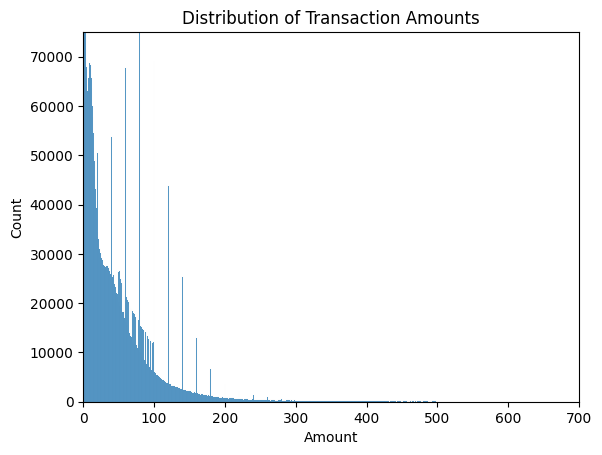

In [ ]:

# plot distplot
sns.histplot(data=df, x='Amount')

# change the limits of X-axis
plt.xlim(0, 700)
plt.ylim(0, 75000)
plt.title('Distribution of Transaction Amounts')
plt.show()

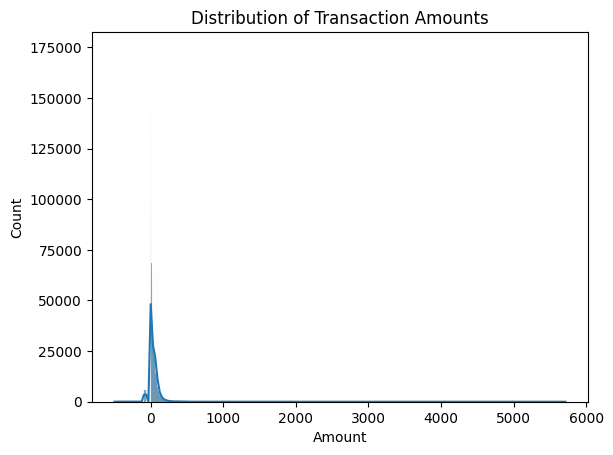

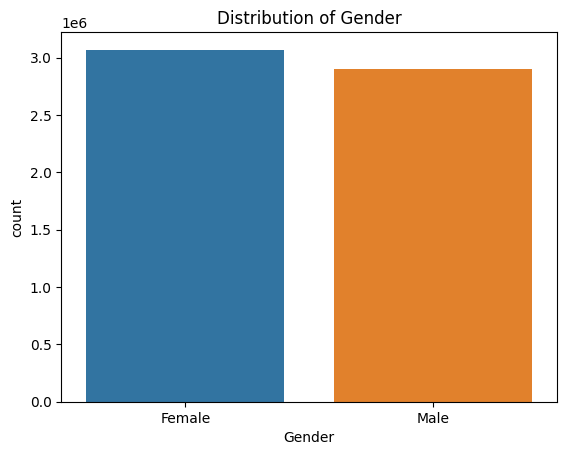

In [ ]:
# Histogram for a numerical variable
sns.histplot(df['Amount'], kde=True)
plt.title('Distribution of Transaction Amounts')
plt.show()

# Bar chart for a categorical variable
sns.countplot(x='Gender', data=df)
plt.title('Distribution of Gender')
plt.show()

Distribution of Transaction Amounts
*   Right-skewed distribution
*   Potential to observe otulier or decision driving factor


Distribution of Gender

*   Balaned distribution over classes



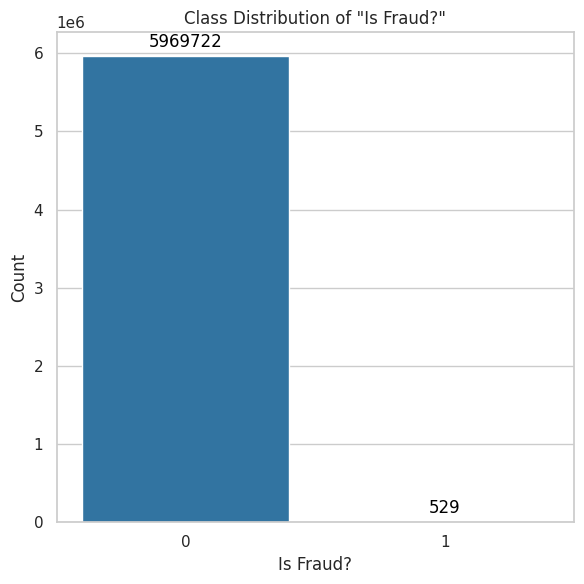

In [ ]:
# Assuming 'Is Fraud?' is the name of your target variable in the dataframe df
plt.figure(figsize=(6, 6))
ax = sns.countplot(x='Is Fraud?', data=df, palette=['#1f77b4', '#ff7f0e'])

# Annotating the bars with the count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.title('Class Distribution of "Is Fraud?"')
plt.xlabel('Is Fraud?')
plt.ylabel('Count')
plt.tight_layout()  # Adjusting layout to prevent clipping of tick-labels etc.
plt.show()

(array([16801., 16983., 17167., 17348., 17532., 17713., 17897., 18078.,
        18262.]),
 [Text(16801.0, 0, '2016-01'),
  Text(16983.0, 0, '2016-07'),
  Text(17167.0, 0, '2017-01'),
  Text(17348.0, 0, '2017-07'),
  Text(17532.0, 0, '2018-01'),
  Text(17713.0, 0, '2018-07'),
  Text(17897.0, 0, '2019-01'),
  Text(18078.0, 0, '2019-07'),
  Text(18262.0, 0, '2020-01')])

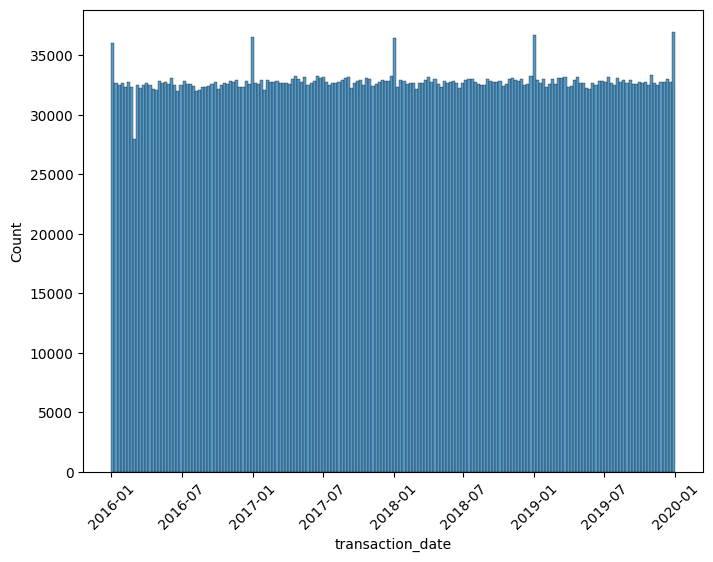

In [ ]:
#df['Acct Open Date'] = pd.to_datetime(df['Acct Open Date'])
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='transaction_date')
plt.xticks(rotation=45)

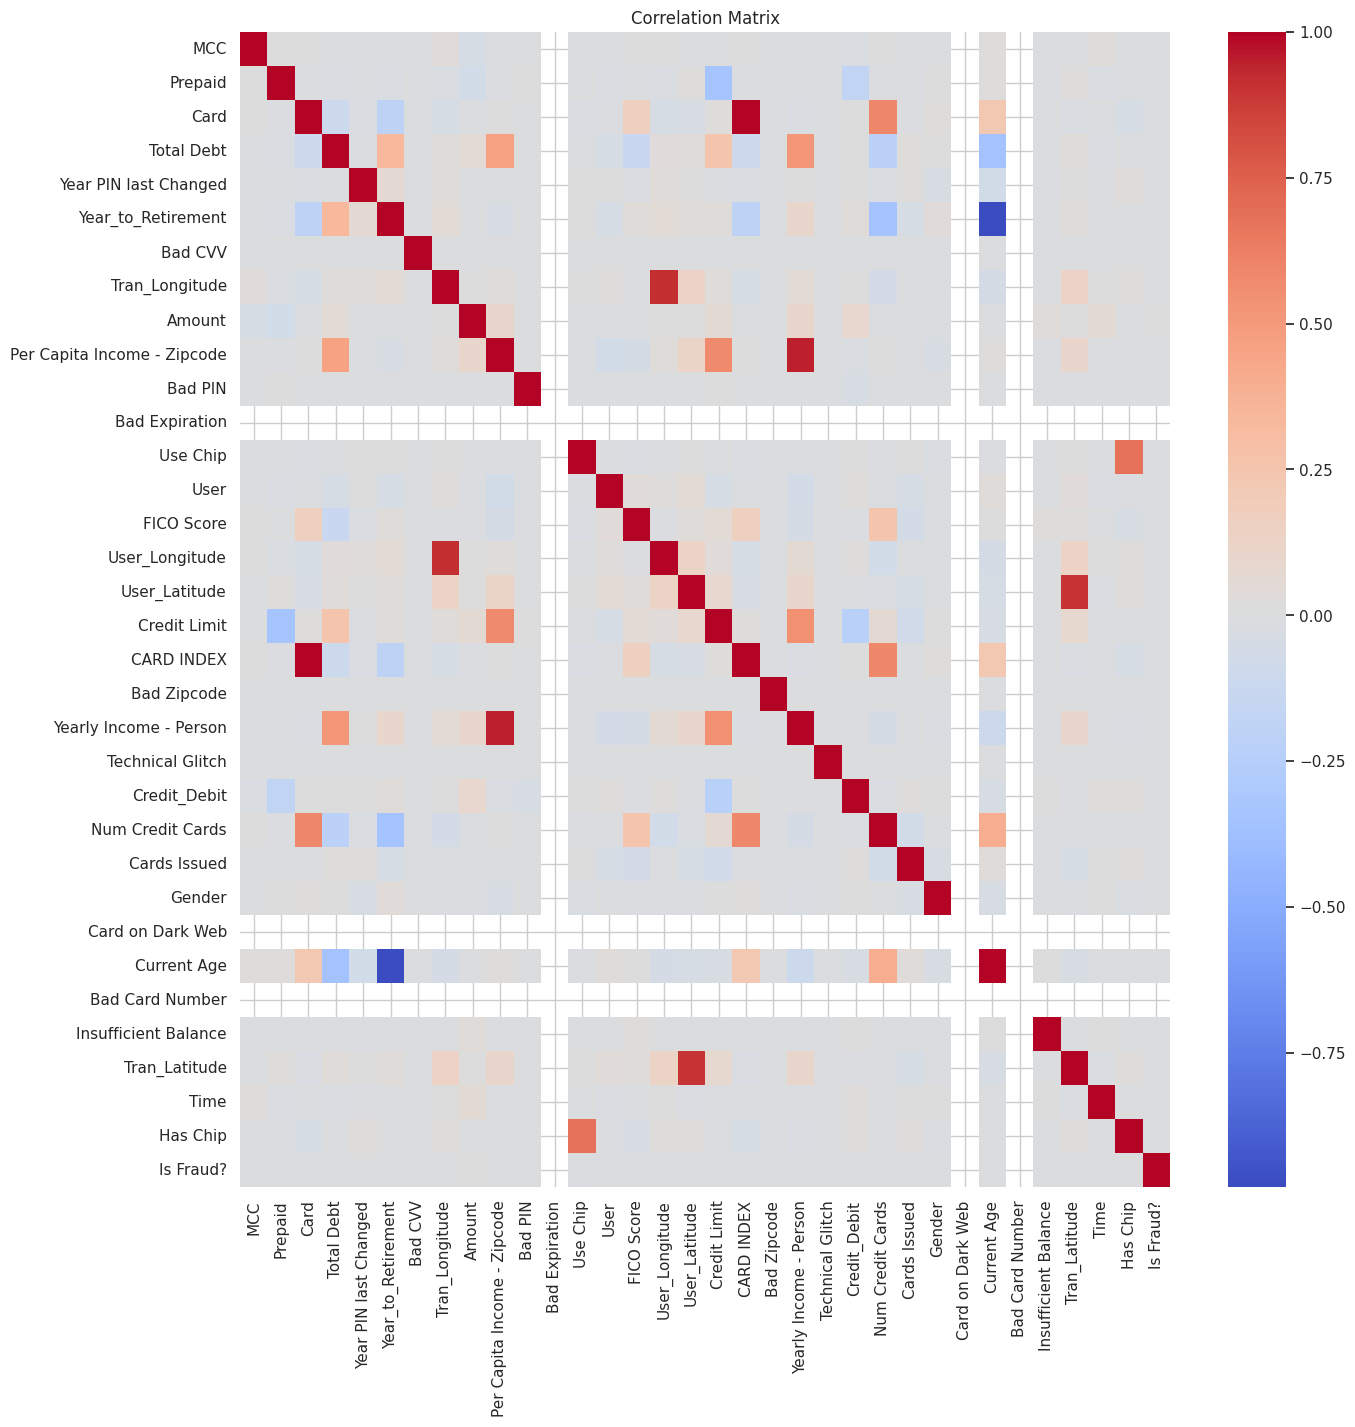

In [ ]:
# Correlation matrix
corr_matrix = round(df.corr(), 2)

# Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [41]:
user_cols = list(set(user_cols).difference({'User_Latitude', 'User_Longitude'}))

In [49]:
tran_cols = list(set(tran_cols).difference({'Tran_Latitude', 'Tran_Longitude', 'Is Fraud?'}))

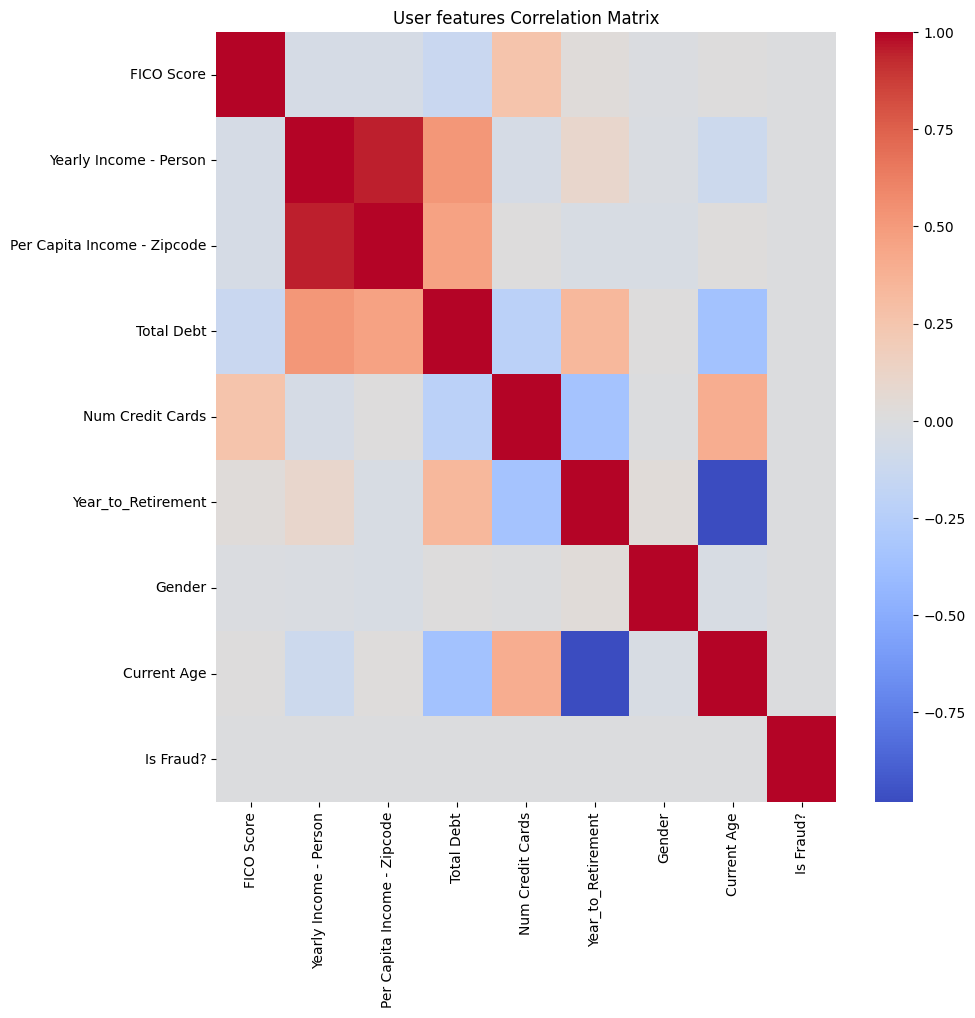

In [46]:
# Correlation matrix
corr_matrix = round(df[user_cols + ['Is Fraud?']].corr(), 2)

# Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('User features Correlation Matrix')
plt.show()

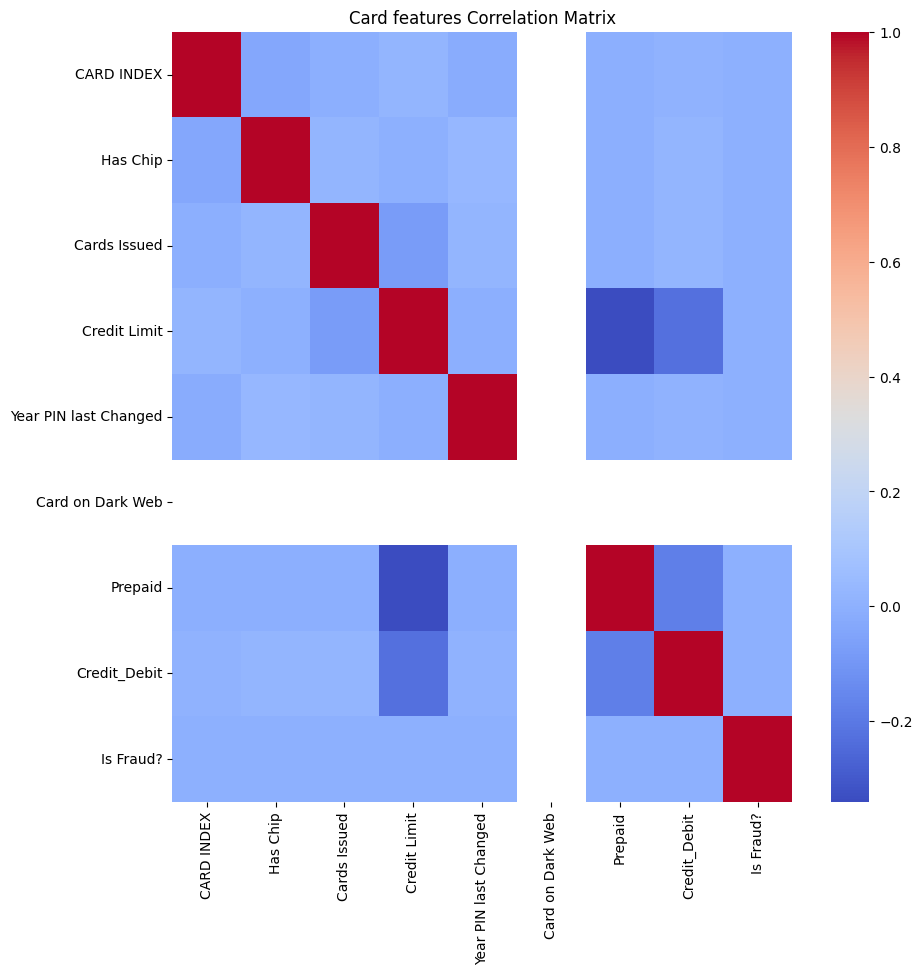

In [47]:
# Correlation matrix
corr_matrix = round(df[card_cols + ['Is Fraud?']].corr(), 2)

# Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Card features Correlation Matrix')
plt.show()

In [12]:
null_card_cols = ['Card on Dark Web']

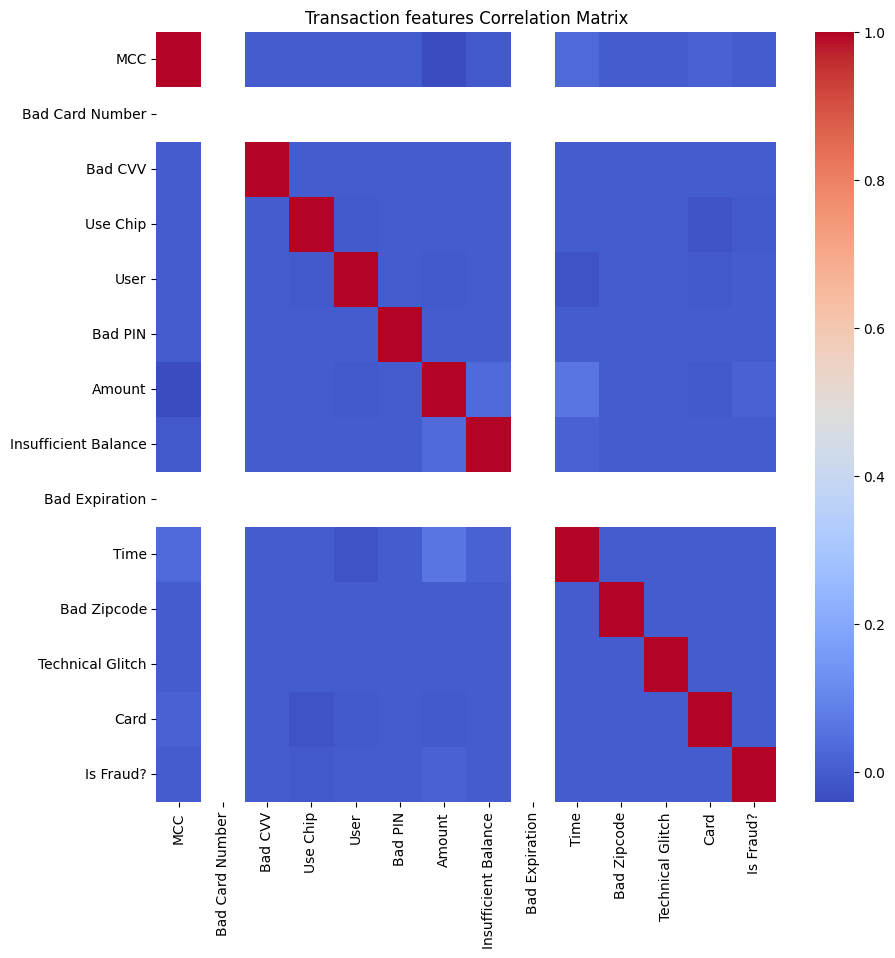

In [50]:
# Correlation matrix
corr_matrix = round(df[tran_cols + ['Is Fraud?']].corr(), 2)

# Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Transaction features Correlation Matrix')
plt.show()

In [13]:
null_tran_cols = ['Bad Card Number',
                  'Bad Expiration',]

In [15]:
null_cols = set()
null_cols.update(set(null_card_cols))
null_cols.update(set(null_tran_cols))

df.drop(list(null_cols), axis=1, inplace=True)

In [ ]:
import pickle

df_sampled_05 = pd.read_parquet('/content/df_SMOTEENN_05_vis.parquet')

In [ ]:
df_fraud = df[df['Is Fraud?']==1]
df_nonfraud = df[df['Is Fraud?']==0]

## Down Sampling - for visualization

In [ ]:
from sklearn.utils import resample

df_nonfraud = resample(df_nonfraud,
             replace=True,
             n_samples=len(df_fraud),
             random_state=42)

In [ ]:
df_downsample = pd.concat([df_fraud, df_nonfraud], axis=0)

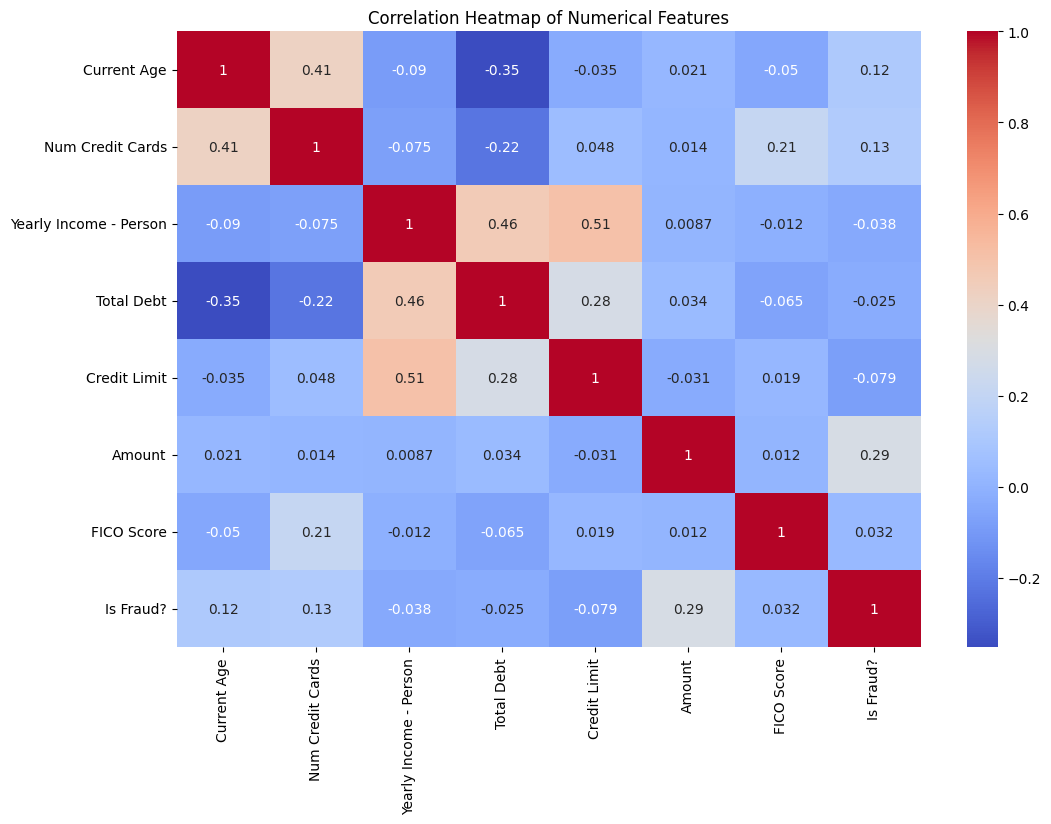

In [ ]:
numerical_cols = ['Current Age', 'Num Credit Cards', 'Yearly Income - Person', 'Total Debt', 'Credit Limit', 'Amount', 'FICO Score', 'Is Fraud?']
corr = df_downsample[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

Correlation Matrix


*   Low to none correlation between target variable and dependent variable => Linear modeling might not work
*   Higher the salary of people you live around with, higher the income you tend to have
*   Higher the income, higher the debt/credit limit people tend to addord



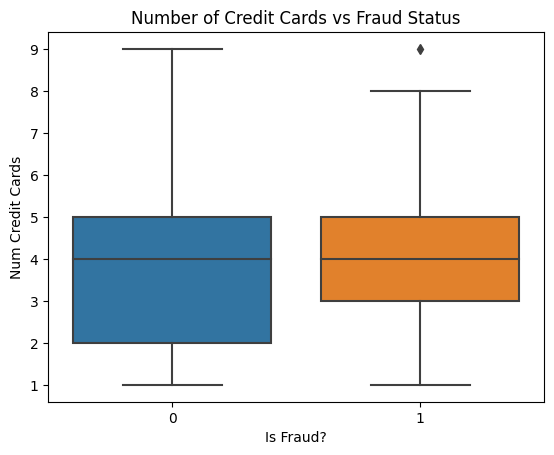

In [ ]:
# Analyzing number of credit cards
sns.boxplot(x='Is Fraud?', y='Num Credit Cards', data=df)
plt.title('Number of Credit Cards vs Fraud Status')
plt.show()

Number of Credit Cards vs Fraud Status


*   Less cards they have, less possible it is to be a fraud transaction => **people usually have a hard time managing account satefy over multiple credit cards**



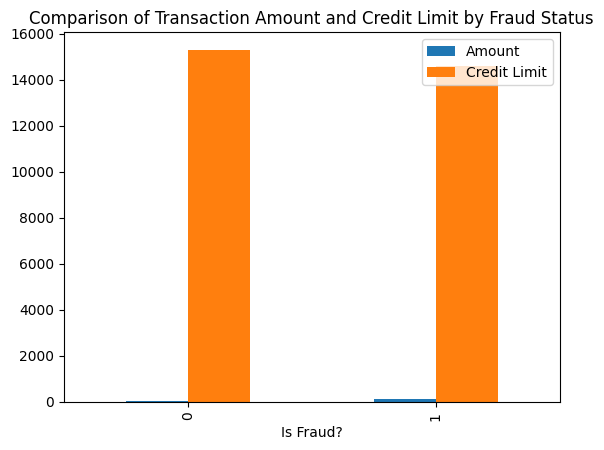

In [ ]:
 # Comparing averages
df.groupby('Is Fraud?')[['Amount', 'Credit Limit']].mean().plot(kind='bar')
plt.title('Comparison of Transaction Amount and Credit Limit by Fraud Status')
plt.show()

Comparison of Transaction Amount and Credit Limit by Fraud Status


*   Fradu transactions tend to have higher amount on the order


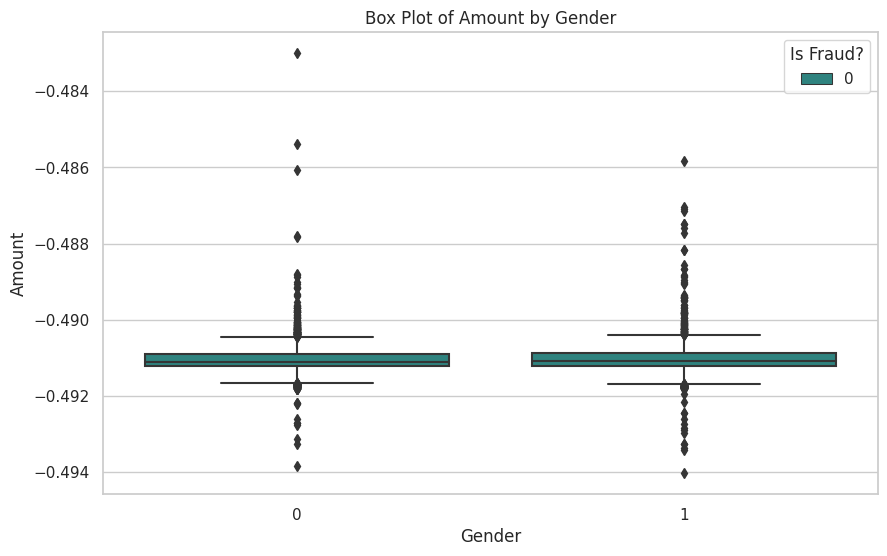

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='Amount', hue='Is Fraud?', data=df_sampled_05, palette='viridis')
plt.title('Box Plot of Amount by Gender')
plt.show()

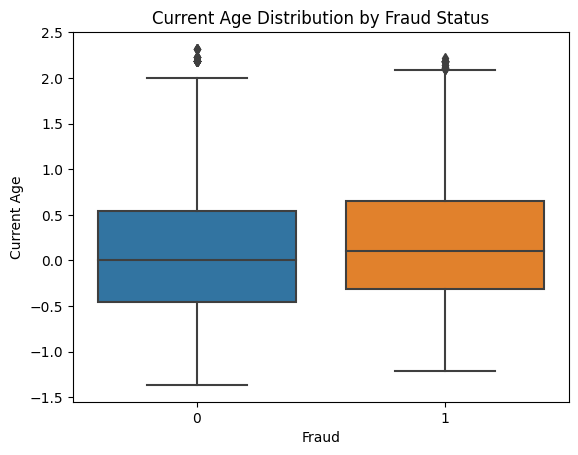

In [ ]:
# Example: Box plot of 'Current Age' with respect to 'Is Fraud?'
sns.boxplot(data=df_sampled_05, x='Fraud', y='Current Age')
plt.title('Current Age Distribution by Fraud Status')
plt.show()

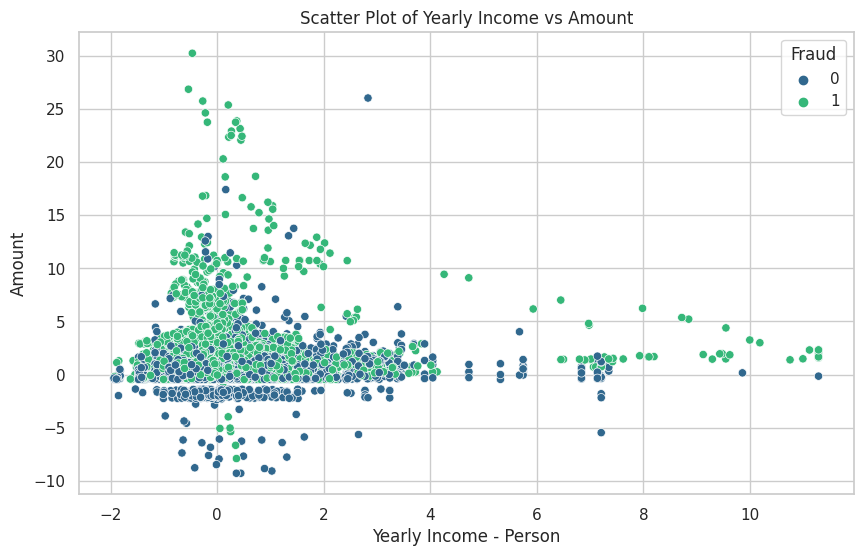

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Yearly Income - Person', y='Amount', hue='Fraud', data=df_sampled_05, palette='viridis')
plt.title('Scatter Plot of Yearly Income vs Amount')
plt.show()



*   Fraud transaction usually have higher transaction amount **... Despite ability of purchase of the card owner**
*   Fraud transaction for high income group, have relatively low purchase amount



## Feature Engineering

#### Groupby data - User-Card

In [109]:
df_user_card_gb = df.groupby(['User', 'Card']).agg({'Amount': 'mean',
                                               'Has Chip': 'max',
                                               'Use Chip': 'mean',
                                               'Year_to_Retirement': 'mean',
                                               'Current Age': 'max',
                                               'FICO Score': 'mean',
                                               'Year PIN last Changed': 'max',
                                               'Per Capita Income - Zipcode': 'mean',
                                               'Yearly Income - Person': 'mean',
                                               'Total Debt': 'mean',
                                               'MCC': pd.Series.mode,
                                               'Credit Limit': 'mean',
                                               'Prepaid': 'max',
                                               'Insufficient Balance': 'mean',
                                               'Cards Issued': 'max',
                                               'Bad CVV': 'mean',
                                               'Bad Zipcode': 'mean',
                                               'Bad PIN': 'mean',
                                               'Is Fraud?': 'max'
                                               })

In [110]:
df_user_card_gb.reset_index(inplace=True)

In [75]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()

X = robust_scaler.fit_transform(df_user_card_gb)

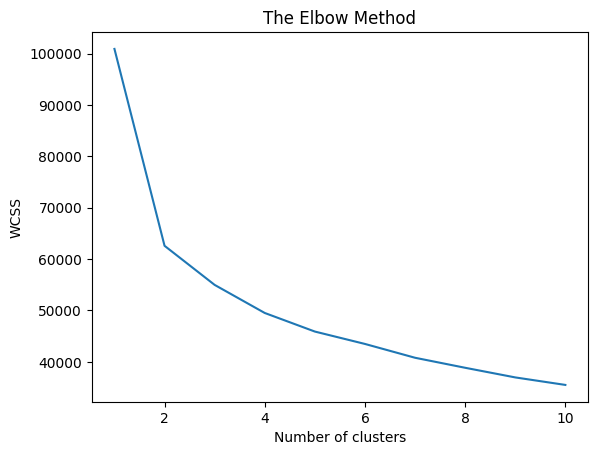

In [76]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Using the Elbow Method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [77]:
optimal_clusters = 2
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X)

# Adding the cluster labels to original dataframe for analysis
df_user_card_gb['Cluster'] = y_kmeans

In [78]:
df_user_card_gb_type1 = df_user_card_gb[df_user_card_gb['Cluster']==0]
df_user_card_gb_type2 = df_user_card_gb[df_user_card_gb['Cluster']==1]

In [90]:
from sklearn.utils import resample


df_user_card_gb_nonfraud = resample(df_user_card_gb[df_user_card_gb['Is Fraud?']==0],
             replace=False,
             n_samples=len(df_user_card_gb[df_user_card_gb['Is Fraud?']==1]),
             random_state=42)

In [91]:
df_user_card_gb_downsample = pd.concat([df_user_card_gb[df_user_card_gb['Is Fraud?']==1], df_user_card_gb_nonfraud], axis=0)

In [81]:
def plot_feature_distribution(df, feature, cluster_col = None):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=feature, hue = cluster_col, kde=False, element="bars", stat="count", common_norm=False)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


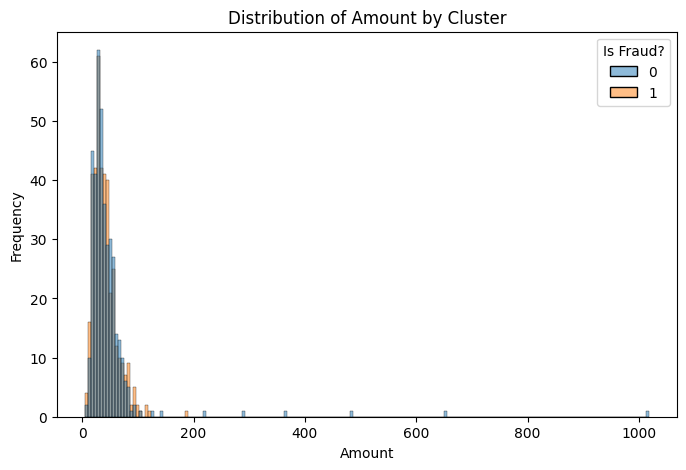

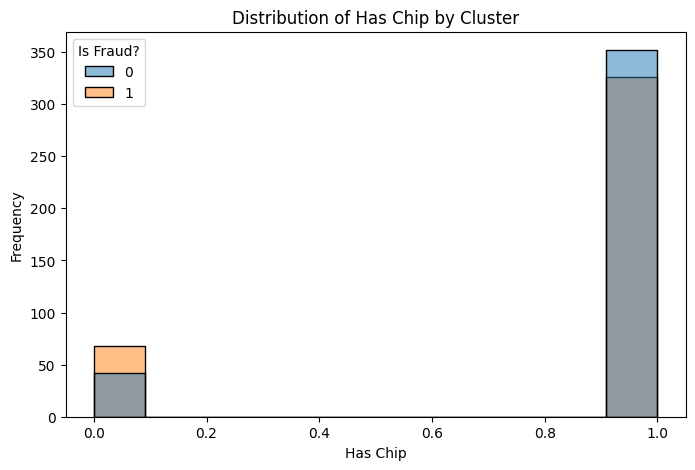

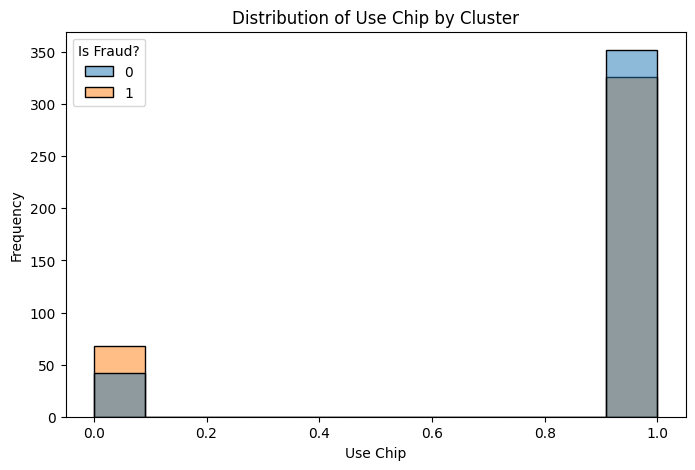

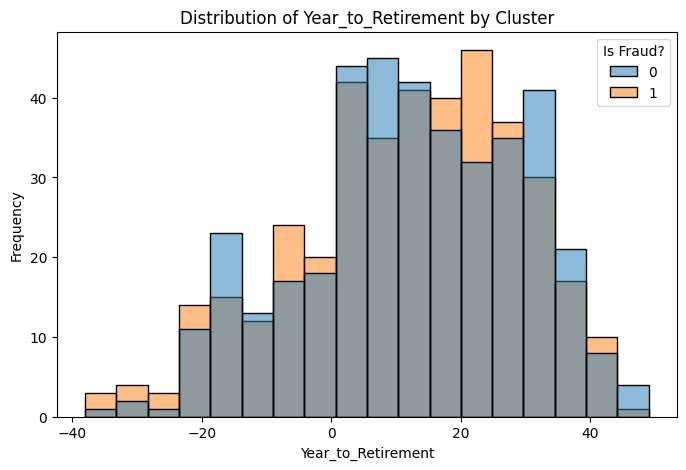

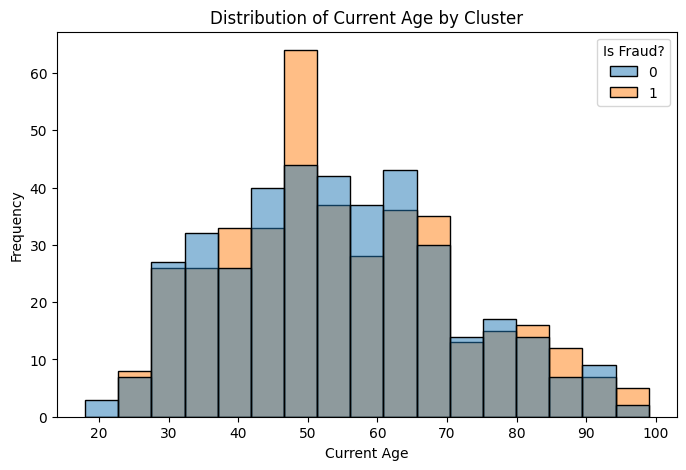

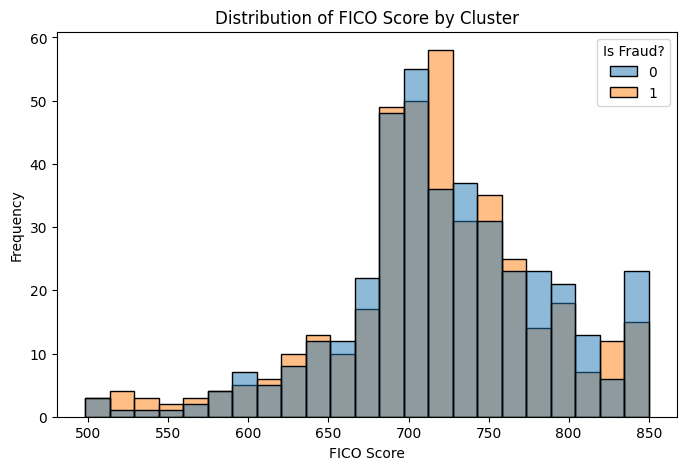

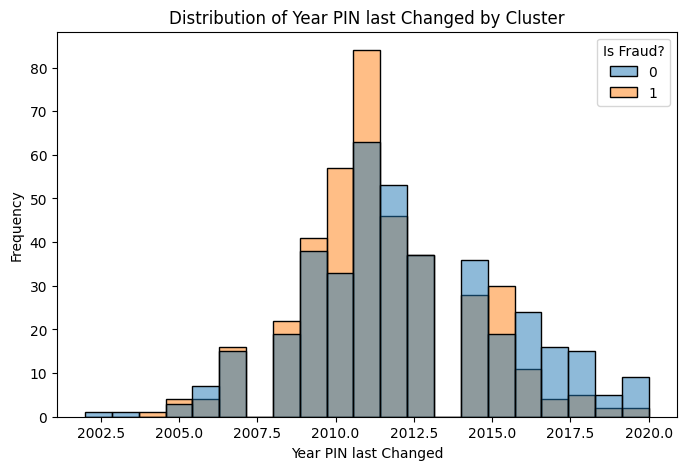

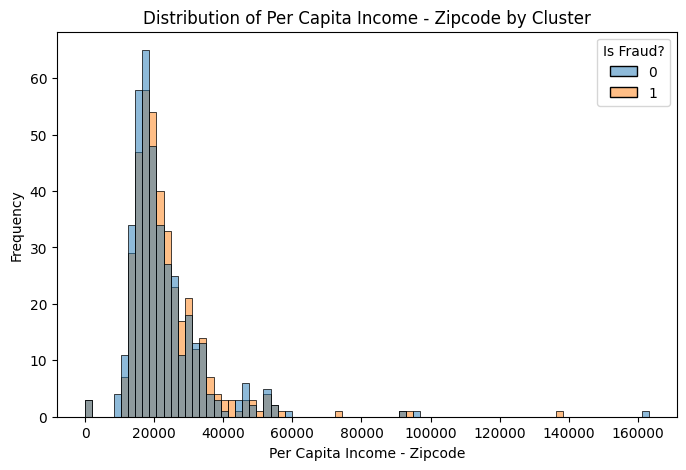

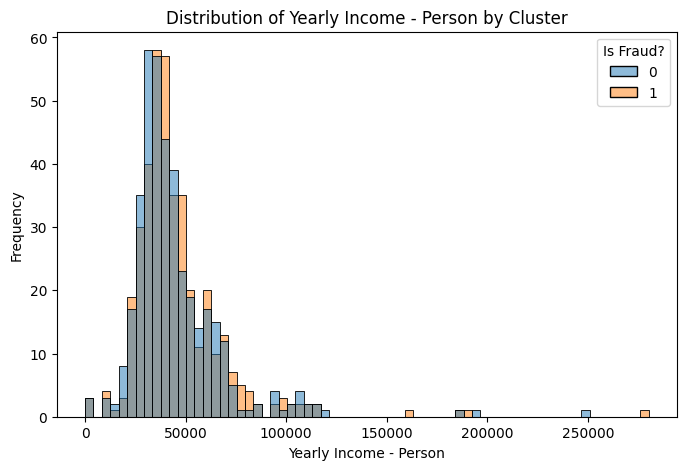

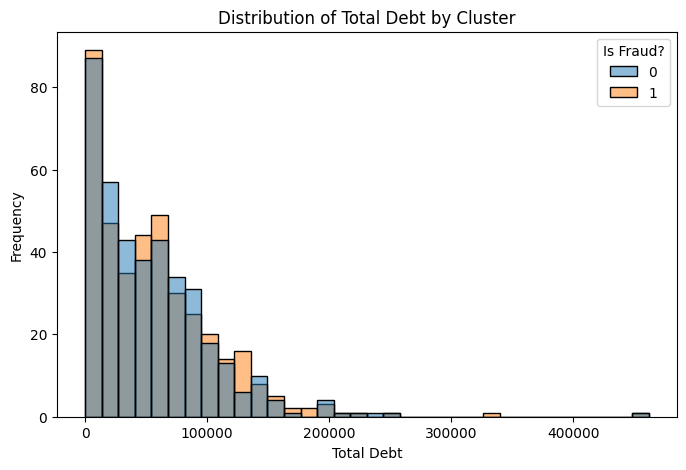

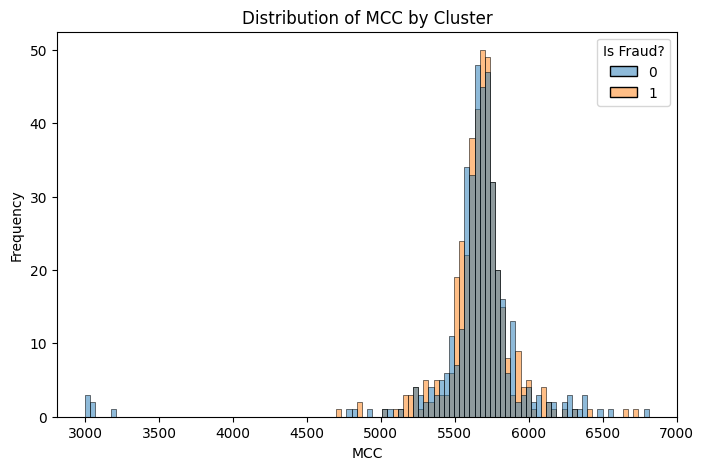

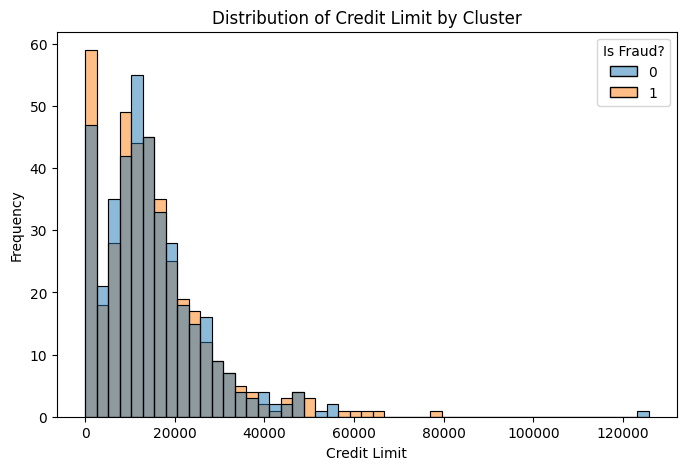

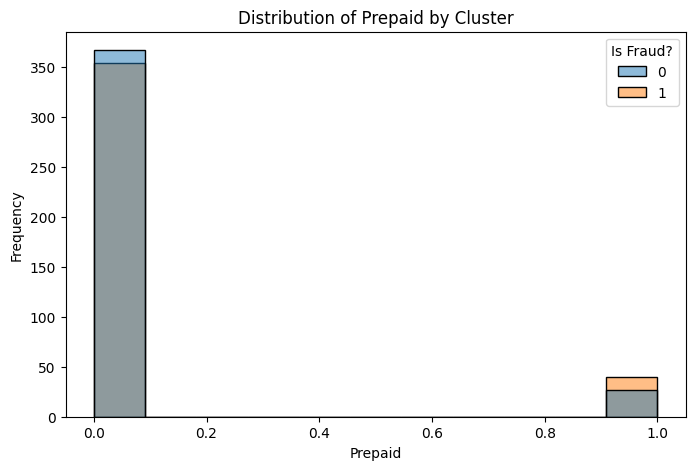

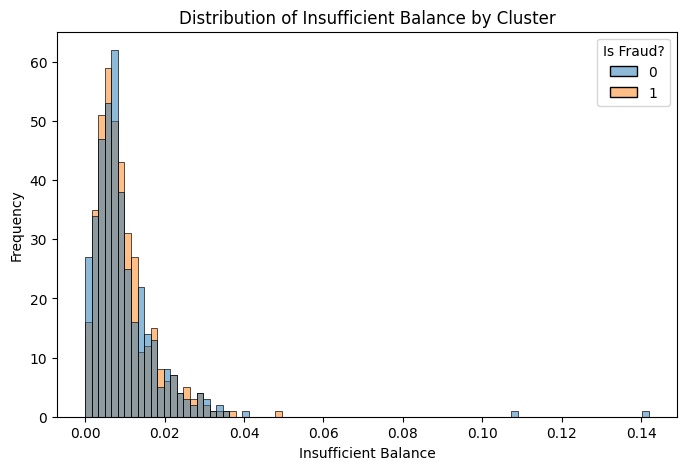

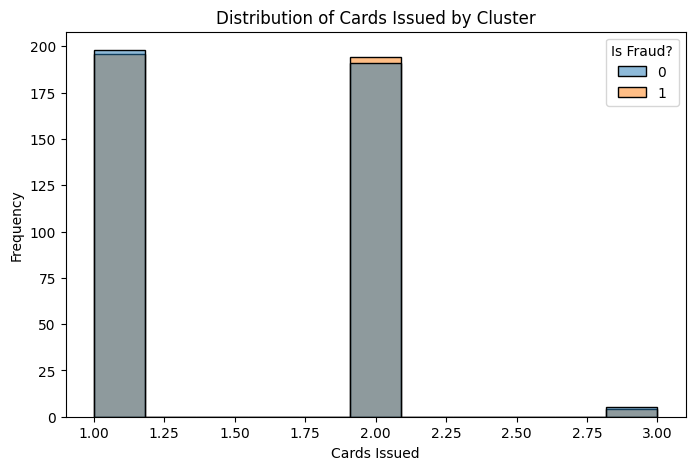

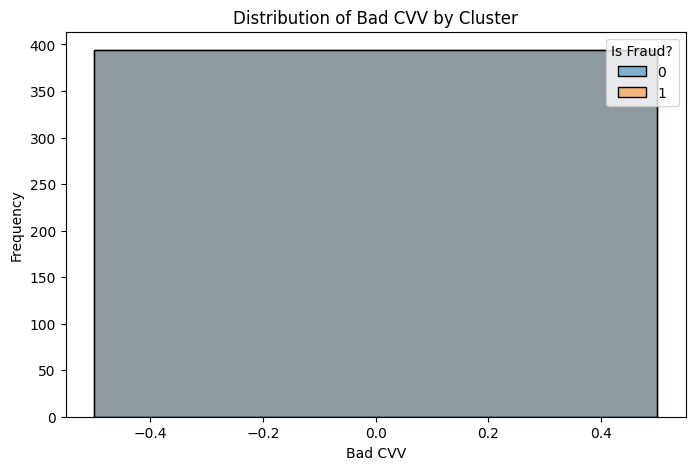

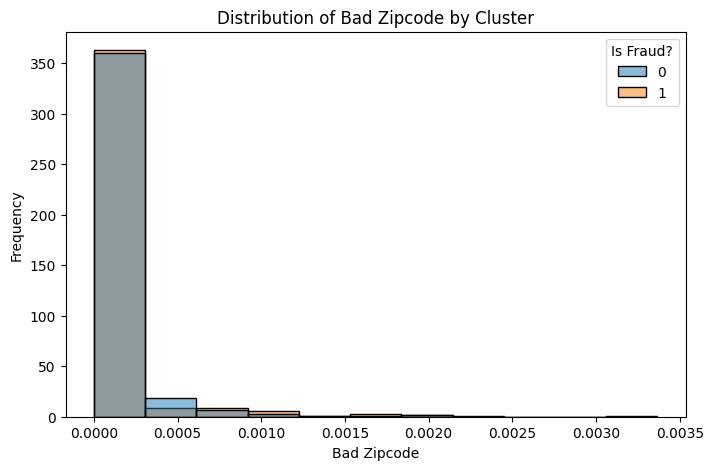

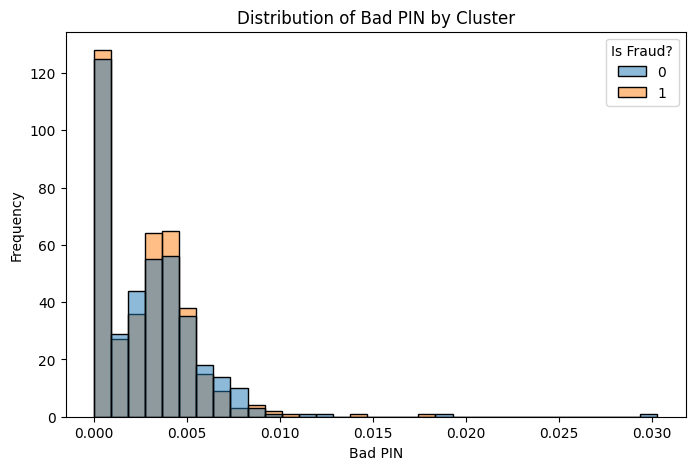

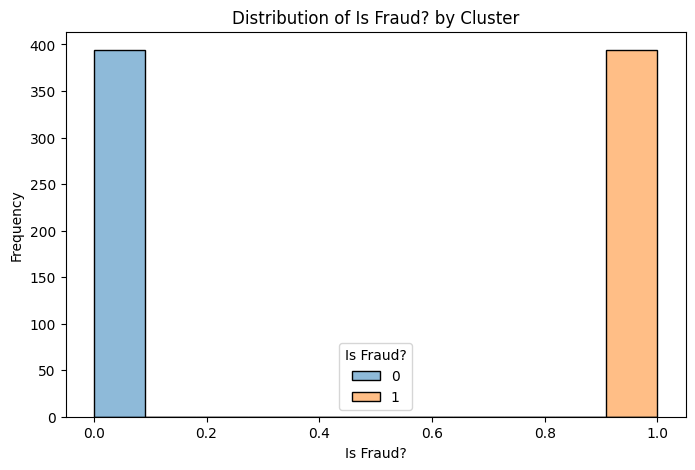

In [92]:
# List of features to plot
features_to_plot = ['Amount', 'Has Chip', 'Use Chip', 'Year_to_Retirement',
                    'Current Age', 'FICO Score', 'Year PIN last Changed',
                    'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt',
                    'MCC', 'Credit Limit', 'Prepaid', 'Insufficient Balance',
                    'Cards Issued', 'Bad CVV', 'Bad Zipcode', 'Bad PIN', 'Is Fraud?']

# Plotting each feature
for feature in features_to_plot:
    plot_feature_distribution(df_user_card_gb_downsample, feature, cluster_col = 'Is Fraud?')

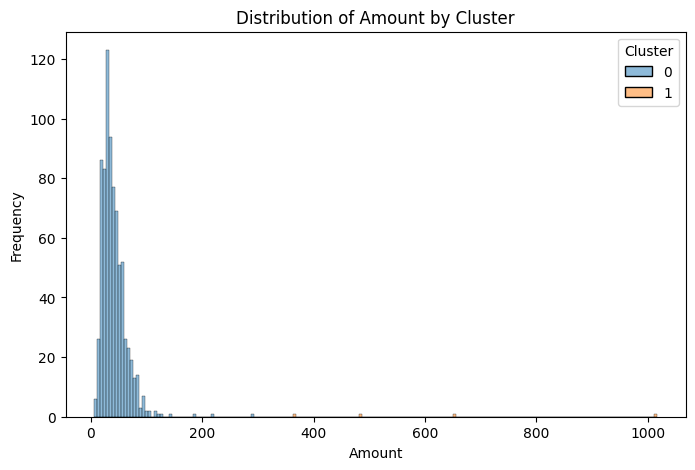

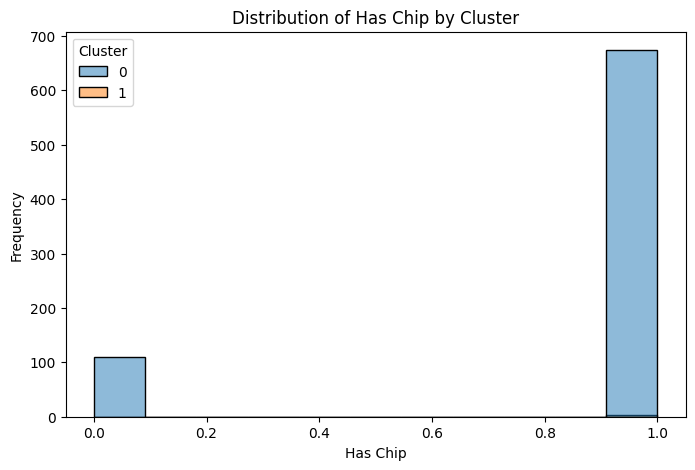

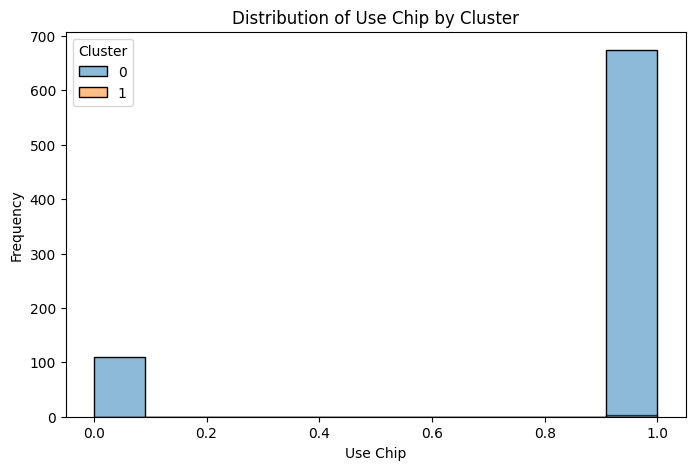

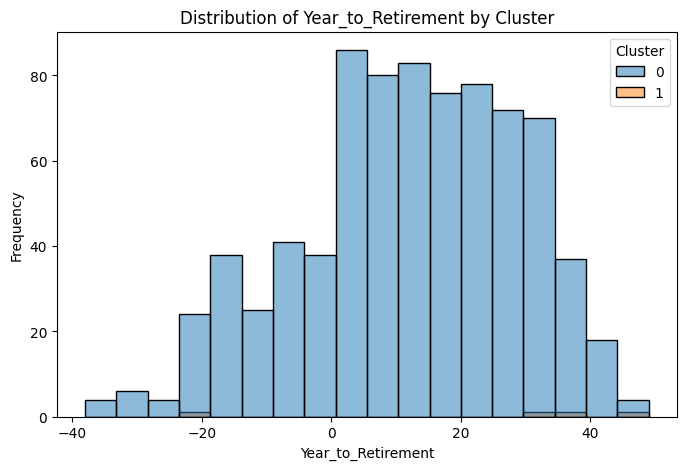

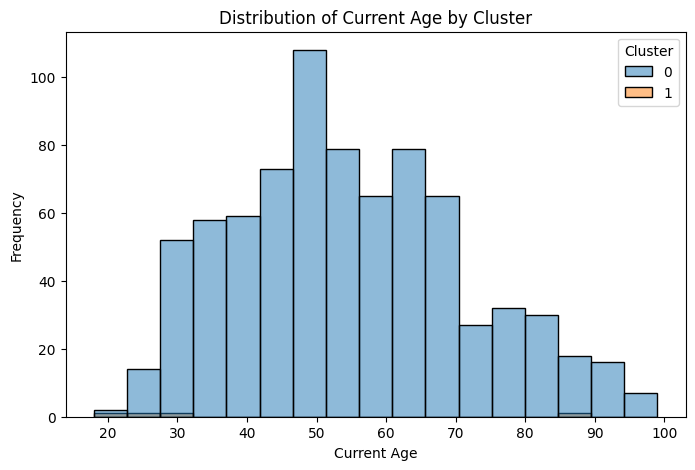

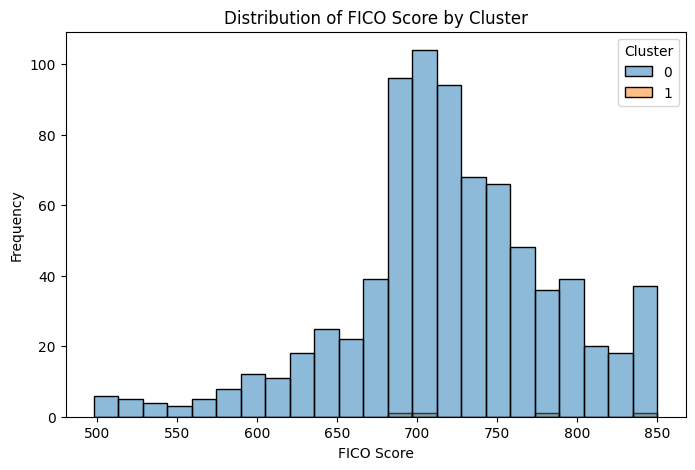

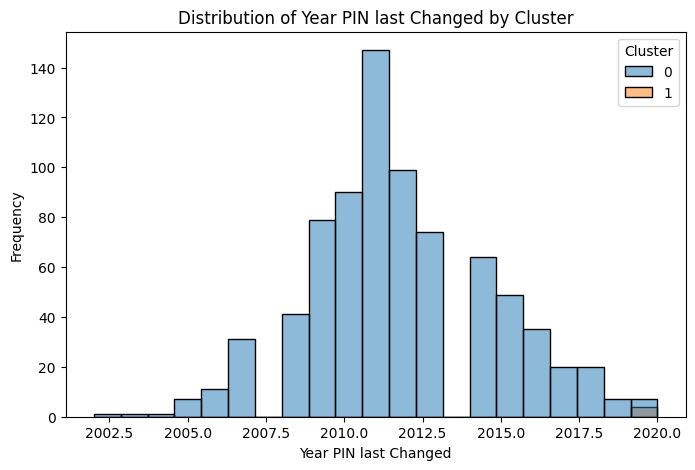

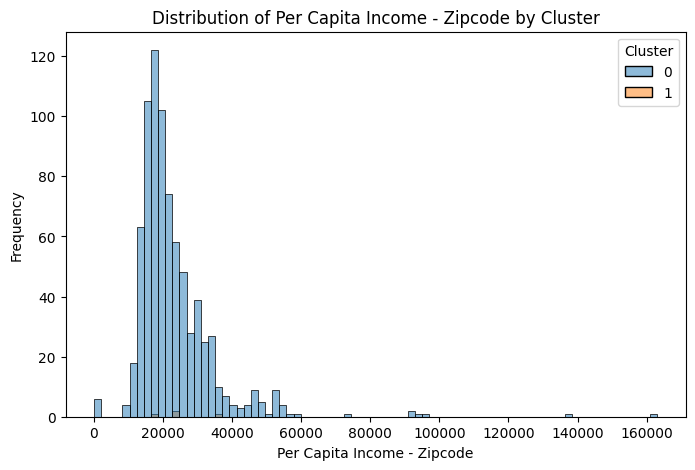

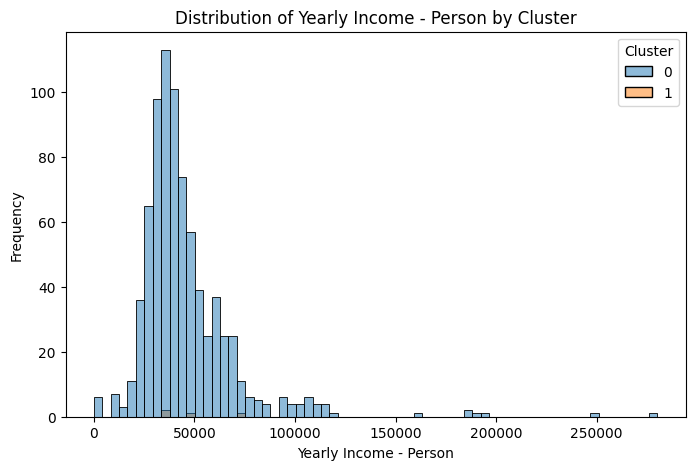

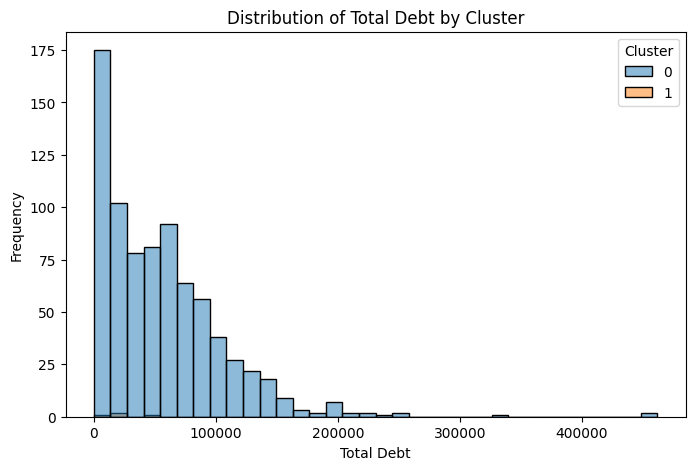

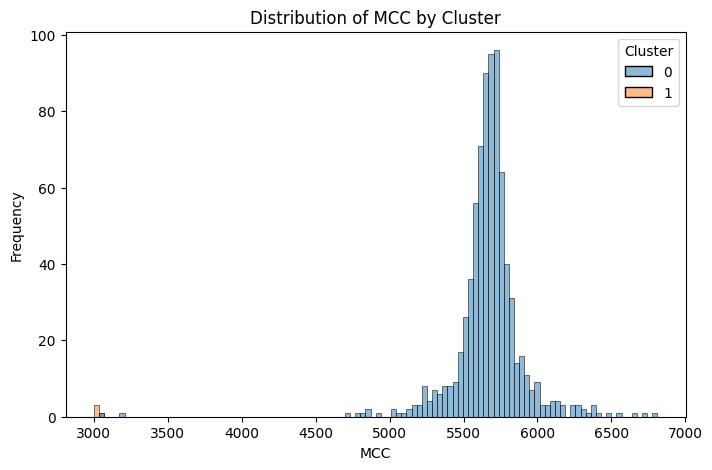

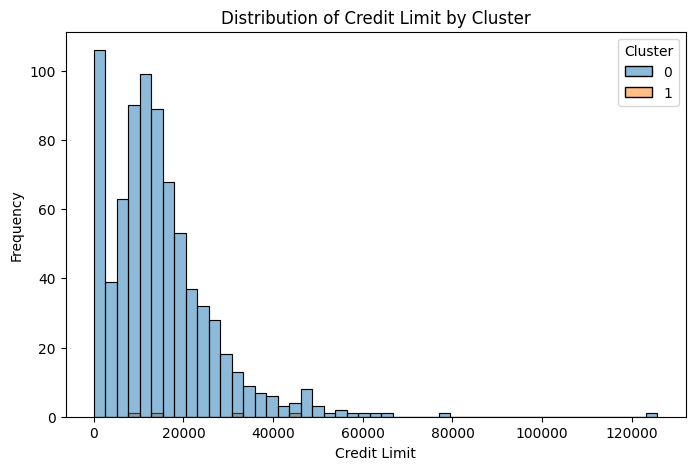

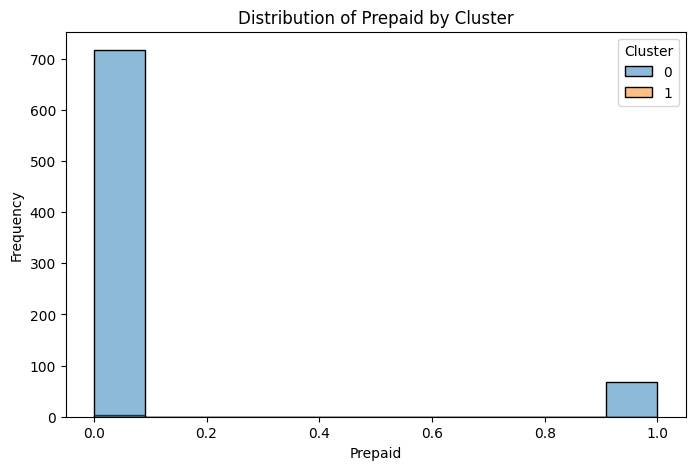

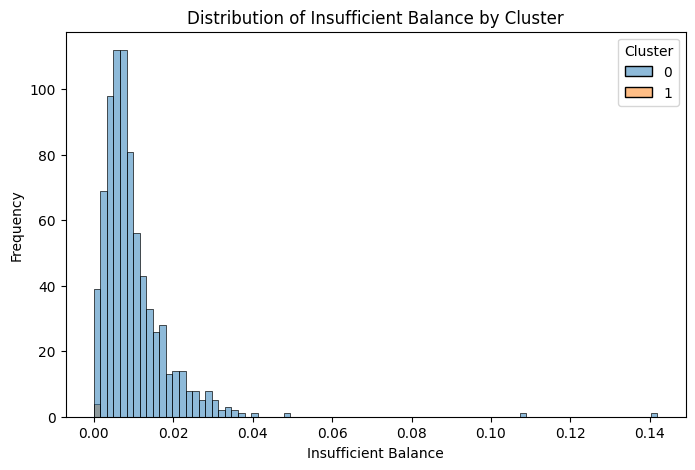

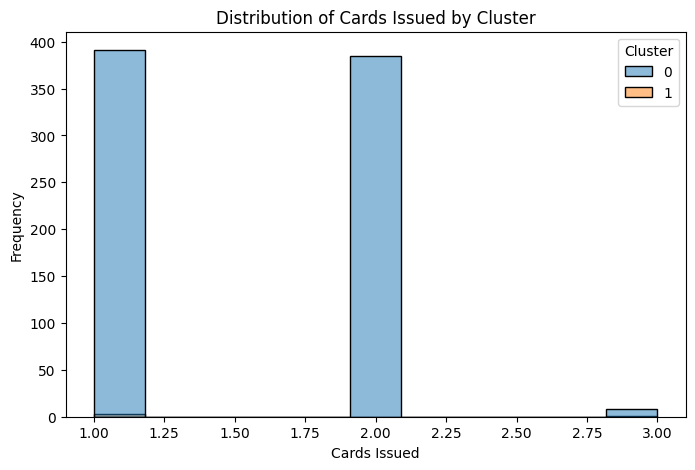

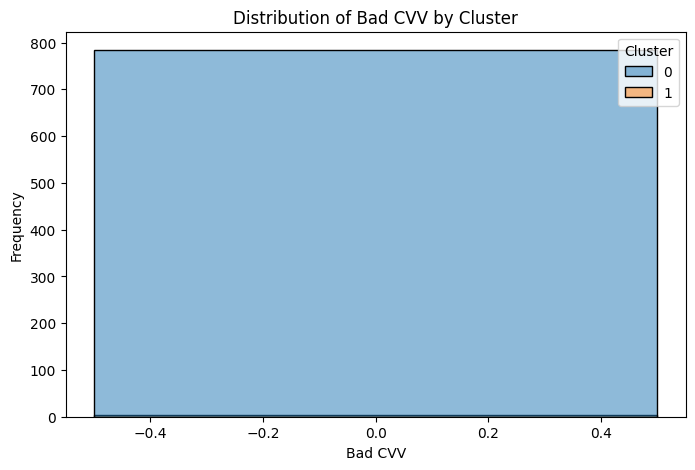

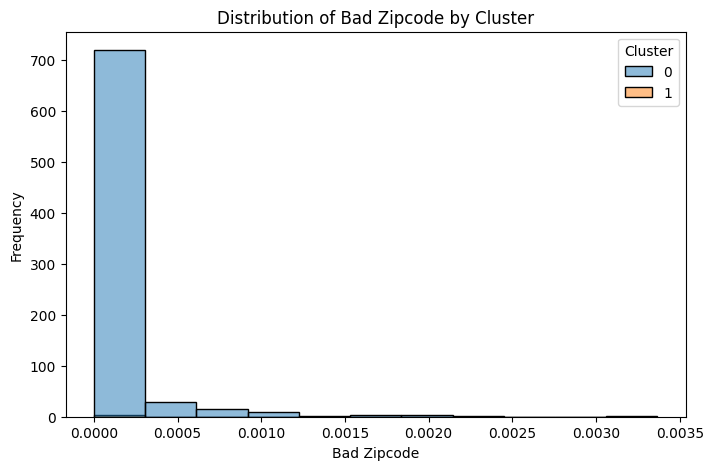

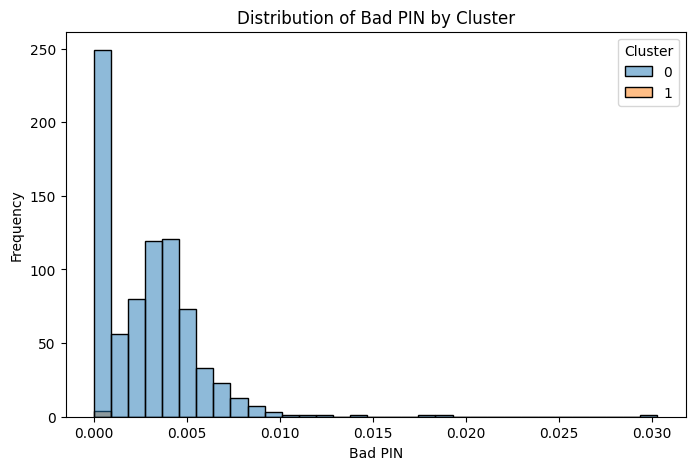

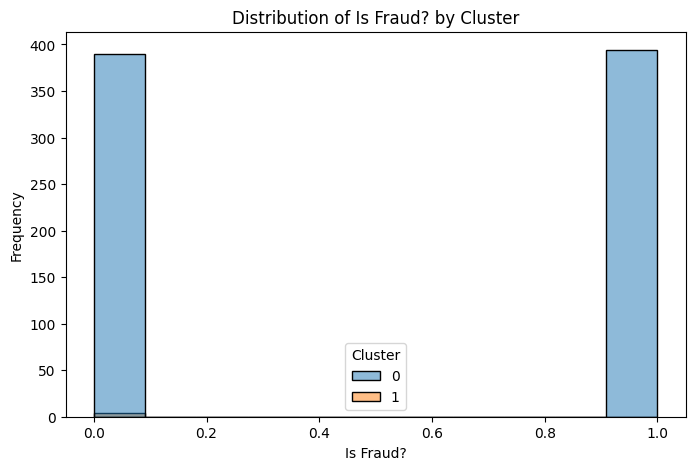

In [93]:
# List of features to plot
features_to_plot = ['Amount', 'Has Chip', 'Use Chip', 'Year_to_Retirement',
                    'Current Age', 'FICO Score', 'Year PIN last Changed',
                    'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt',
                    'MCC', 'Credit Limit', 'Prepaid', 'Insufficient Balance',
                    'Cards Issued', 'Bad CVV', 'Bad Zipcode', 'Bad PIN', 'Is Fraud?']

# Plotting each feature
for feature in features_to_plot:
    plot_feature_distribution(df_user_card_gb_downsample, feature, cluster_col = 'Cluster')

###### Demographics

In [127]:
count_stats = df_user_card_gb.groupby('Is Fraud?')[features_to_plot].count()
median_stats = df_user_card_gb.groupby('Is Fraud?')[features_to_plot].median()
quantile_stats = df_user_card_gb.groupby('Is Fraud?')[features_to_plot].quantile([0.25, 0.75])
sum_stats = df_user_card_gb.groupby('Is Fraud?')[features_to_plot].sum()
mean_stats = df_user_card_gb.groupby('Is Fraud?')[features_to_plot].mean()

In [128]:
custom_aggregation = df_user_card_gb.groupby('Is Fraud?')[features_to_plot].agg(['mean', 'std', 'min', 'max'])

In [129]:
custom_aggregation

Amount                                    Has Chip            \
                mean        std       min          max      mean       std   
Is Fraud?                                                                    
0          48.565459  82.901082  0.000000  2125.230000  0.904907  0.293380   
1          41.006557  21.623540  6.290321   183.914868  0.827411  0.378372   

                   Use Chip            ... Bad CVV           Bad Zipcode  \
          min max      mean       std  ...     min       max        mean   
Is Fraud?                              ...                                 
0           0   1  0.809289  0.276172  ...     0.0  0.001927    0.000094   
1           0   1  0.747383  0.348504  ...     0.0  0.000000    0.000078   

                                     Bad PIN                           
                std  min       max      mean       std  min       max  
Is Fraud?                                                              
0          0.000381  0.0  0.008772  0.002615  0.002587  0.0  0.030303  
1          0.000315  0.0  0.003367  0.002693  0.002457  0.0  0.018100  

[2 rows x 68 columns]

In [130]:
# List of features to plot
features_to_plot = ['Amount', 'Has Chip', 'Use Chip', 'Year_to_Retirement',
                    'Current Age', 'FICO Score', 'Year PIN last Changed',
                    'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt',
                    'MCC', 'Credit Limit', 'Prepaid', 'Insufficient Balance',
                    'Cards Issued', 'Bad CVV', 'Bad Zipcode', 'Bad PIN']

In [135]:
median_stats

Amount  Has Chip  Use Chip  Year_to_Retirement  Current Age  \
Is Fraud?                                                                   
0          37.679732       1.0  0.906834                13.0         53.0   
1          36.522330       1.0  0.908491                14.0         52.0   

           FICO Score  Year PIN last Changed  Per Capita Income - Zipcode  \
Is Fraud?                                                                   
0               717.0                 2012.0                      20531.0   
1               717.0                 2011.0                      20532.0   

           Yearly Income - Person  Total Debt  Credit Limit  Prepaid  \
Is Fraud?                                                              
0                         39661.0     46043.0       12754.0      0.0   
1                         40431.0     49274.0       12763.5      0.0   

           Insufficient Balance  Cards Issued  Bad CVV  Bad Zipcode   Bad PIN  
Is Fraud?                                                                      
0                      0.007583           1.0      0.0          0.0  0.002481  
1                      0.007507           2.0      0.0          0.0  0.002858

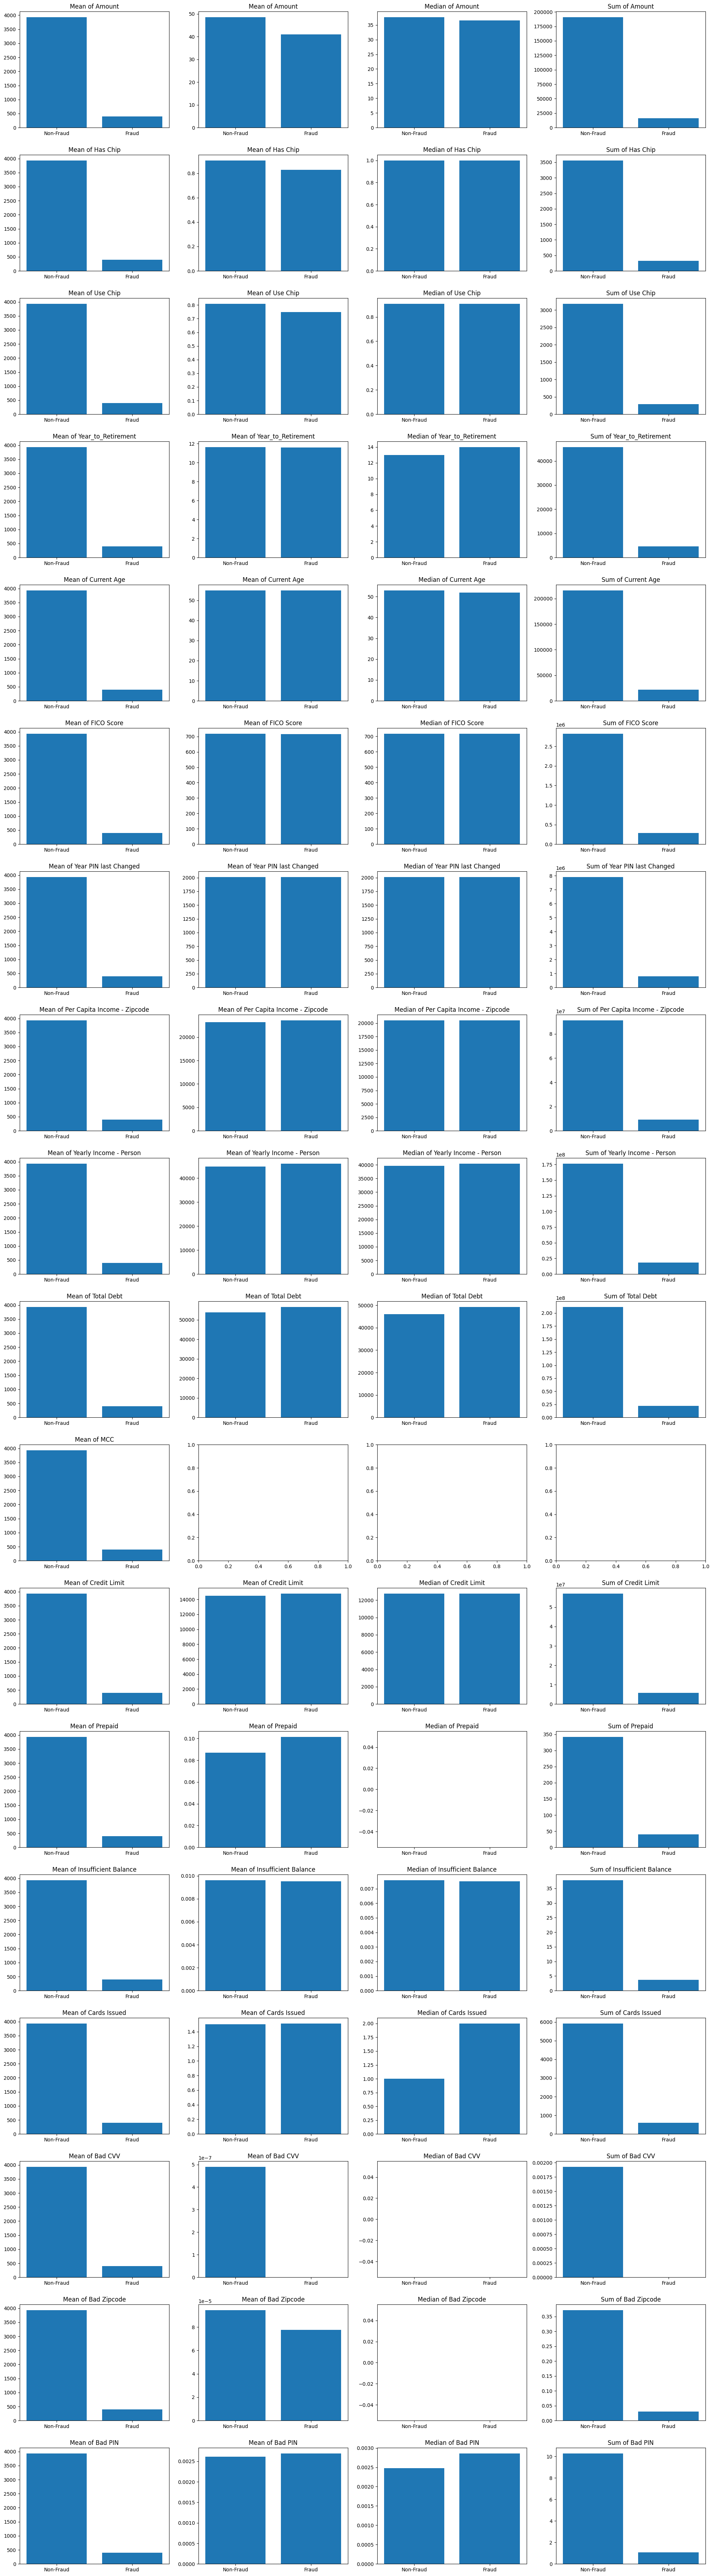

In [136]:

# Number of features and types of aggregations
num_features = len(features_to_plot)
num_aggregations = 4  # mean, median, sum, unique counts

# Create a figure with subplots
fig, axes = plt.subplots(nrows=num_features, ncols=num_aggregations, figsize=(20, 4 * num_features))

# Iterate over each feature and each type of aggregation
for i, feature in enumerate(features_to_plot):
    # Plot count
    if feature in count_stats.columns:
      axes[i, 0].bar(['Non-Fraud', 'Fraud'], count_stats[feature])
      axes[i, 0].set_title(f'Mean of {feature}')

    # Plot mean
    if feature in mean_stats.columns:
      axes[i, 1].bar(['Non-Fraud', 'Fraud'], mean_stats[feature])
      axes[i, 1].set_title(f'Mean of {feature}')

    # Plot median
    if feature in median_stats.columns:
      axes[i, 2].bar(['Non-Fraud', 'Fraud'], median_stats[feature])
      axes[i, 2].set_title(f'Median of {feature}')

    # Plot sum
    if feature in sum_stats.columns:
      axes[i, 3].bar(['Non-Fraud', 'Fraud'], sum_stats[feature])
      axes[i, 3].set_title(f'Sum of {feature}')


# Adjust layout for readability
plt.tight_layout()
plt.show()

#### Groupby data - User

In [63]:
df_user_gb = df.groupby(['User']).agg({'Amount': 'mean',
                                        'Has Chip': 'max',
                                        'Use Chip': 'max',
                                        'Year_to_Retirement': 'mean',
                                        'Current Age': 'max',
                                        'FICO Score': 'mean',
                                        'Year PIN last Changed': 'max',
                                        'Per Capita Income - Zipcode': 'mean',
                                        'Yearly Income - Person': 'mean',
                                        'Total Debt': 'mean',
                                        'MCC': 'mean',
                                        'Credit Limit': 'mean',
                                        'Prepaid': 'max',
                                        'Insufficient Balance': 'mean',
                                        'Cards Issued': 'max',
                                        'Bad CVV': 'mean',
                                        'Bad Zipcode': 'mean',
                                        'Bad PIN': 'mean',
                                        'Is Fraud?': 'max'
                                        })

In [66]:
df_user_gb.reset_index(inplace=True)

In [67]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()

X = robust_scaler.fit_transform(df_user_gb)

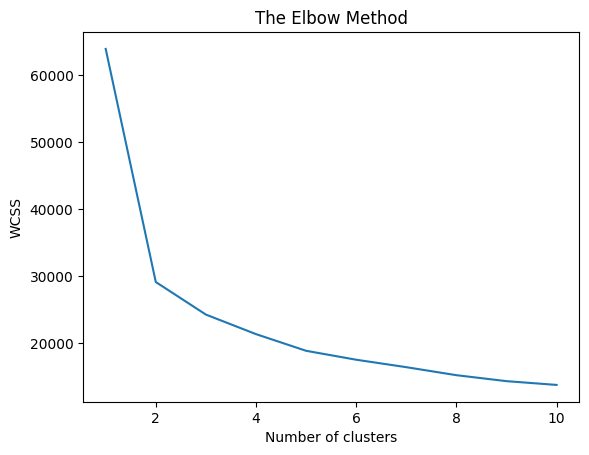

In [68]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Using the Elbow Method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [69]:
optimal_clusters = 2
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X)

# Adding the cluster labels to original dataframe for analysis
df_user_gb['Cluster'] = y_kmeans

In [ ]:
df_user_gb_type1 = df_user_gb[df_user_gb['Cluster']==0]
df_user_gb_type2 = df_user_gb[df_user_gb['Cluster']==1]

In [70]:
from sklearn.utils import resample

df_user_gb_nonfraud = resample(df_user_gb,
             replace=True,
             n_samples=len(df_user_gb[df_user_gb['Is Fraud?']==1]),
             random_state=42)

In [ ]:
df_user_gb_downsample = pd.concat([df_user_gb, df_user_gb_nonfraud], axis=0)

In [71]:
def plot_feature_distribution(df, feature, cluster_col = None):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=feature, hue = cluster_col, kde=False, element="bars", stat="count", common_norm=False)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


In [ ]:
# List of features to plot
features_to_plot = ['Amount', 'Has Chip', 'Use Chip', 'Year_to_Retirement',
                    'Current Age', 'FICO Score', 'Year PIN last Changed',
                    'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt',
                    'MCC', 'Credit Limit', 'Prepaid', 'Insufficient Balance',
                    'Cards Issued', 'Bad CVV', 'Bad Zipcode', 'Bad PIN', 'Is Fraud?']

# Plotting each feature
for feature in features_to_plot:
    plot_feature_distribution(df_user_gb_downsample, feature, cluster_col = 'Is Fraud?')

###### Demographics

In [137]:
count_stats = df_user_gb.groupby('Is Fraud?')[features_to_plot].count()
median_stats = df_user_gb.groupby('Is Fraud?')[features_to_plot].median()
quantile_stats = df_user_gb.groupby('Is Fraud?')[features_to_plot].quantile([0.25, 0.75])
sum_stats = df_user_gb.groupby('Is Fraud?')[features_to_plot].sum()
mean_stats = df_user_gb.groupby('Is Fraud?')[features_to_plot].mean()

In [138]:
custom_aggregation = df_user_gb.groupby('Is Fraud?')[features_to_plot].agg(['mean', 'std', 'min', 'max'])

In [139]:
custom_aggregation

Amount                                     Has Chip            \
                mean         std       min          max      mean       std   
Is Fraud?                                                                     
0          57.957771  118.951489  5.303726  2125.230000  0.967252  0.178046   
1          41.458893   17.399121  6.290321   117.411671  0.980114  0.139809   

                   Use Chip            ... Bad CVV           Bad Zipcode  \
          min max      mean       std  ...     min       max        mean   
Is Fraud?                              ...                                 
0           0   1  0.964058  0.186221  ...     0.0  0.000000    0.000095   
1           0   1  0.980114  0.139809  ...     0.0  0.000337    0.000090   

                                     Bad PIN                           
                std  min       max      mean       std  min       max  
Is Fraud?                                                              
0          0.000241  0.0  0.001935  0.002604  0.001631  0.0  0.010050  
1          0.000215  0.0  0.001283  0.002817  0.001425  0.0  0.007658  

[2 rows x 72 columns]

In [140]:
# List of features to plot
features_to_plot = ['Amount', 'Has Chip', 'Use Chip', 'Year_to_Retirement',
                    'Current Age', 'FICO Score', 'Year PIN last Changed',
                    'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt',
                    'MCC', 'Credit Limit', 'Prepaid', 'Insufficient Balance',
                    'Cards Issued', 'Bad CVV', 'Bad Zipcode', 'Bad PIN']

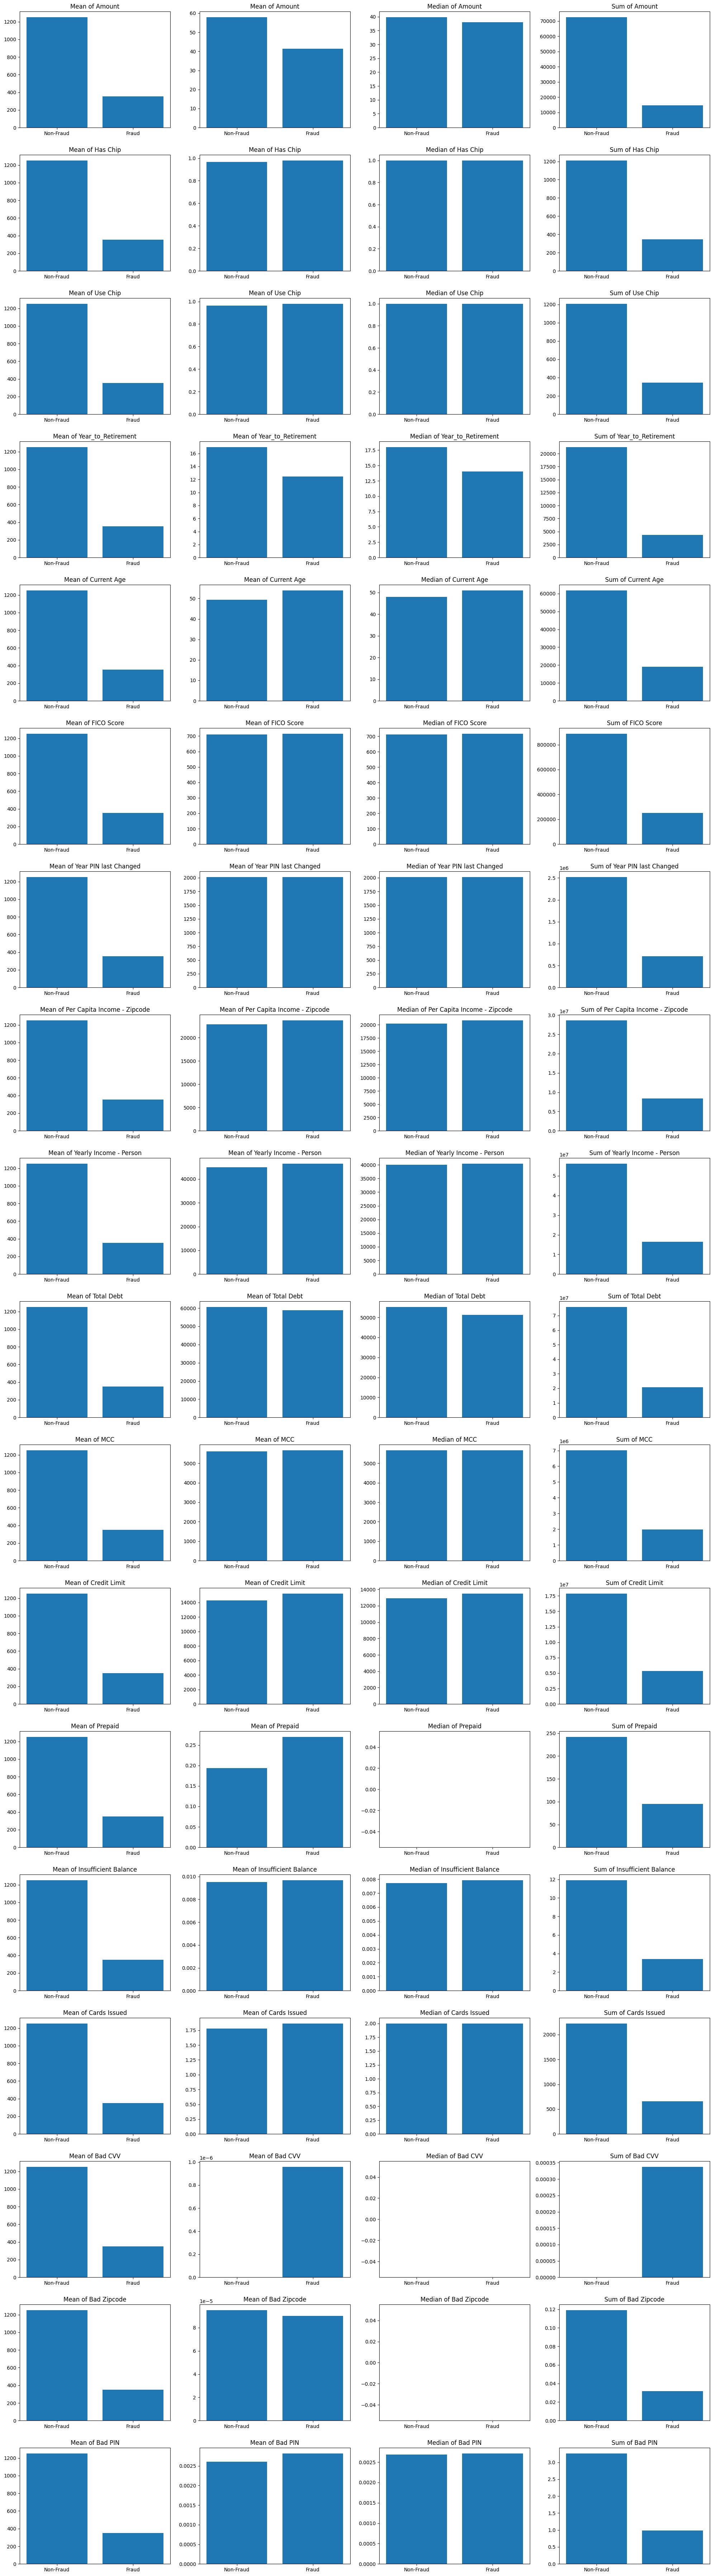

In [141]:

# Number of features and types of aggregations
num_features = len(features_to_plot)
num_aggregations = 4  # mean, median, sum, unique counts

# Create a figure with subplots
fig, axes = plt.subplots(nrows=num_features, ncols=num_aggregations, figsize=(20, 4 * num_features))

# Iterate over each feature and each type of aggregation
for i, feature in enumerate(features_to_plot):
    # Plot count
    if feature in count_stats.columns:
      axes[i, 0].bar(['Non-Fraud', 'Fraud'], count_stats[feature])
      axes[i, 0].set_title(f'Mean of {feature}')

    # Plot mean
    if feature in mean_stats.columns:
      axes[i, 1].bar(['Non-Fraud', 'Fraud'], mean_stats[feature])
      axes[i, 1].set_title(f'Mean of {feature}')

    # Plot median
    if feature in median_stats.columns:
      axes[i, 2].bar(['Non-Fraud', 'Fraud'], median_stats[feature])
      axes[i, 2].set_title(f'Median of {feature}')

    # Plot sum
    if feature in sum_stats.columns:
      axes[i, 3].bar(['Non-Fraud', 'Fraud'], sum_stats[feature])
      axes[i, 3].set_title(f'Sum of {feature}')


# Adjust layout for readability
plt.tight_layout()
plt.show()

#### Feature Engineering - Robust Scaling

https://proclusacademy.com/blog/robust-scaler-outliers/

In [ ]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()

df[scaled_cols] = robust_scaler.fit_transform(df[scaled_cols])

In [ ]:
import pickle

with open('RobustScaler.pkl', 'wb') as file:
  pickle.dump(robust_scaler, file)

### Robust Scaling - checkpoint restore

In [ ]:
df_sampled_05 = pd.read_parquet('/content/df_SMOTEENN_05_vis.parquet')
df_sampled_05.columns

Index(['Amount', 'Use Chip', 'Total Debt', 'Year_to_Retirement',
       'Credit Limit', 'Insufficient Balance', 'Credit_Debit',
       'Yearly Income - Person', 'Cards Issued', 'Current Age',
       'Per Capita Income - Zipcode', 'Year PIN last Changed',
       'Num Credit Cards', 'FICO Score', 'Fraud'],
      dtype='object')

In [ ]:
df.columns

Index(['Use Chip', 'Bad CVV', 'Bad Expiration', 'Current Age',
       'Insufficient Balance', 'Num Credit Cards', 'Prepaid', 'Bad PIN',
       'Yearly Income - Person', 'Technical Glitch', 'Tran_Longitude',
       'Tran_Latitude', 'Acct Open Date', 'User', 'MCC', 'Gender',
       'Year_to_Retirement', 'Has Chip', 'User_Latitude', 'Merchant City',
       'Time', 'Credit Limit', 'Bad Zipcode', 'Card on Dark Web',
       'Credit_Debit', 'Card', 'CARD INDEX', 'Bad Card Number', 'Total Debt',
       'Expires', 'User_Longitude', 'Merchant State', 'Cards Issued', 'Amount',
       'Year PIN last Changed', 'Per Capita Income - Zipcode', 'FICO Score',
       'Is Fraud?'],
      dtype='object')

In [ ]:
import pickle

with open('/content/RobustScaler.pkl', 'rb') as file:
  robust_scaler = pickle.load(file)

In [ ]:
df_transformed = pd.DataFrame(robust_scaler.transform(df[scaled_cols]), columns = scaled_cols)

In [ ]:
df_transformed['Is Fraud?'] = df['Is Fraud?']
df_transformed = df_transformed.sample(frac=1, random_state=1)

In [ ]:
Y_transformed = df_transformed['Is Fraud?']
df_transformed = df_transformed.drop('Is Fraud?', axis=1)

In [ ]:
display(len(df_transformed)*0.7)
display(len(df_transformed)*0.85)
display(df_transformed.shape)

4179175.6999999997

5074713.35

(5970251, 15)

In [ ]:
trainX, validateX, testX = df_transformed[:4200000], df_transformed[4200000 : 5100000], df_transformed[5100000 :]
trainY, validateY, testY = Y_transformed[:4200000], Y_transformed[4200000 : 5100000], Y_transformed[5100000 :]

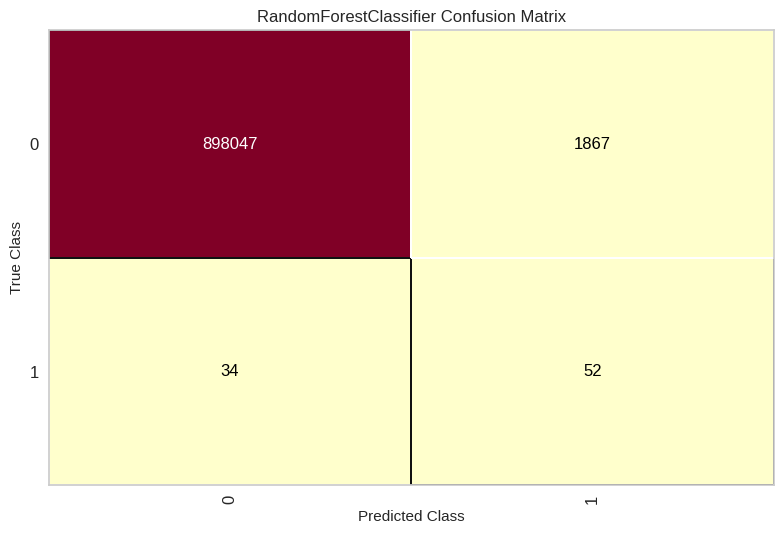

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
from yellowbrick.classifier import ConfusionMatrix, ROCAUC

cm = ConfusionMatrix(rf_model)
cm.fit(trainX, trainY)
cm.score(validateX, validateY)
cm.show()

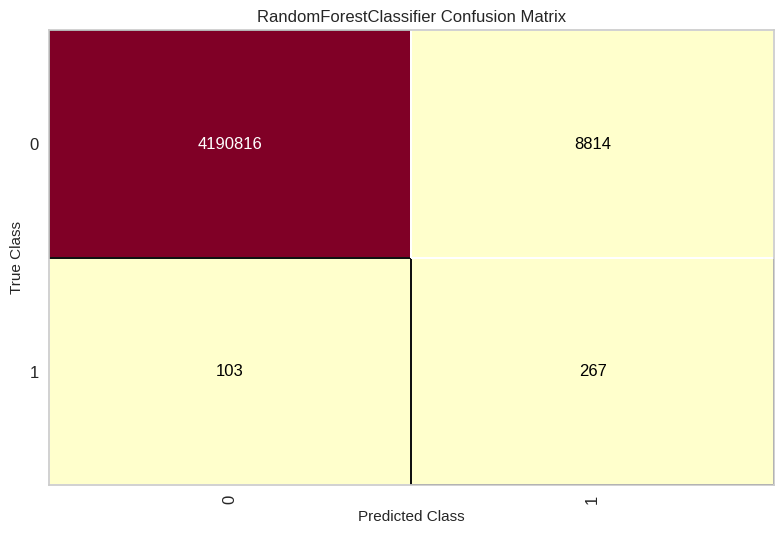

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
cm = ConfusionMatrix(rf_model)
cm.fit(trainX, trainY)
cm.score(trainX, trainY)
cm.show()

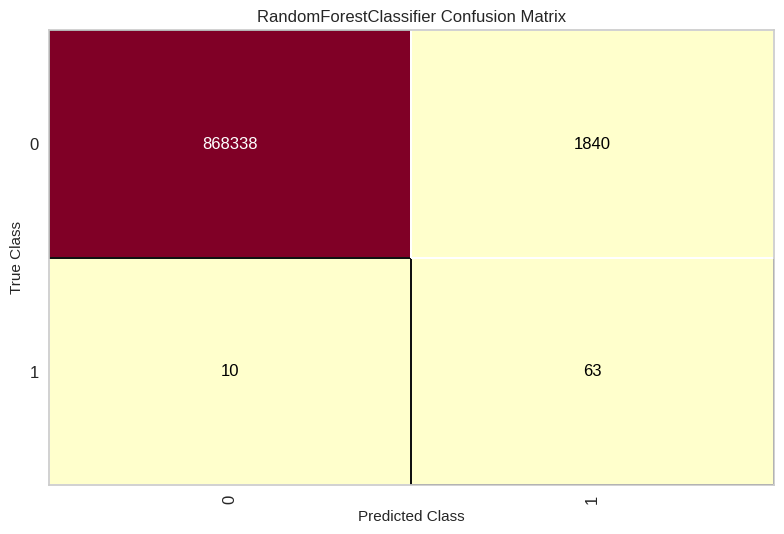

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
cm = ConfusionMatrix(rf_model)
cm.fit(trainX, trainY)
cm.score(testX, testY)
cm.show()

In [ ]:
df[scaled_cols].columns

Index(['Amount', 'Use Chip', 'Total Debt', 'Year_to_Retirement',
       'Credit Limit', 'Insufficient Balance', 'Credit_Debit',
       'Yearly Income - Person', 'Cards Issued', 'Current Age',
       'Per Capita Income - Zipcode', 'Year PIN last Changed',
       'Num Credit Cards', 'FICO Score'],
      dtype='object')

In [ ]:
df_vis = df[scaled_cols].copy()
df_vis = df_vis.sample(frac=1, random_state=1)
df_vis['Fraud'] = Y_transformed
df_vis['predicted_Fraud'] = rf_model.predict(df_transformed)

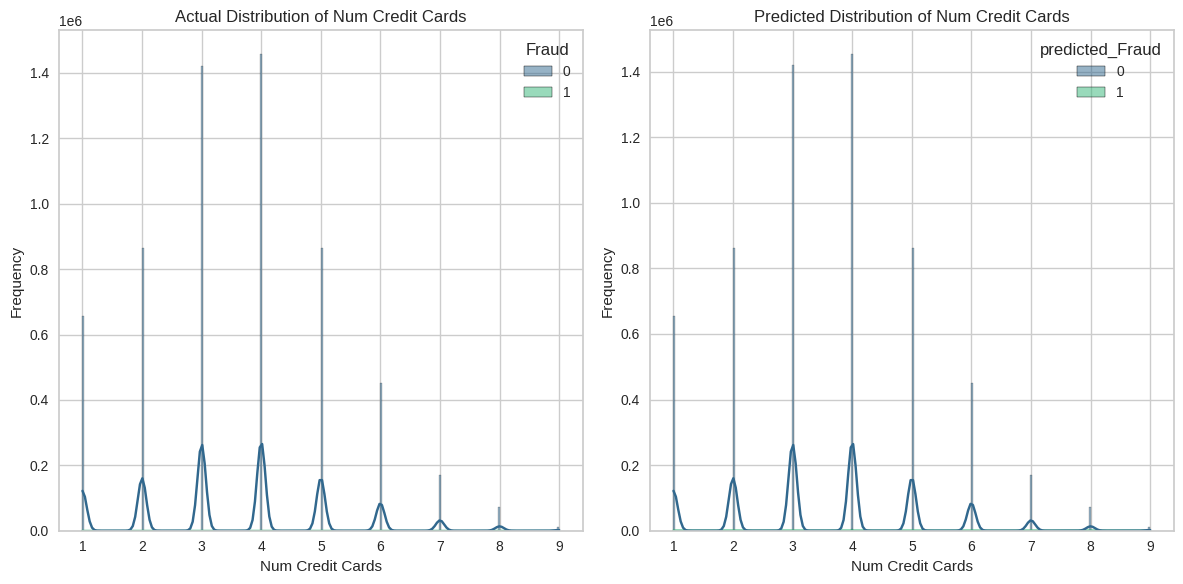

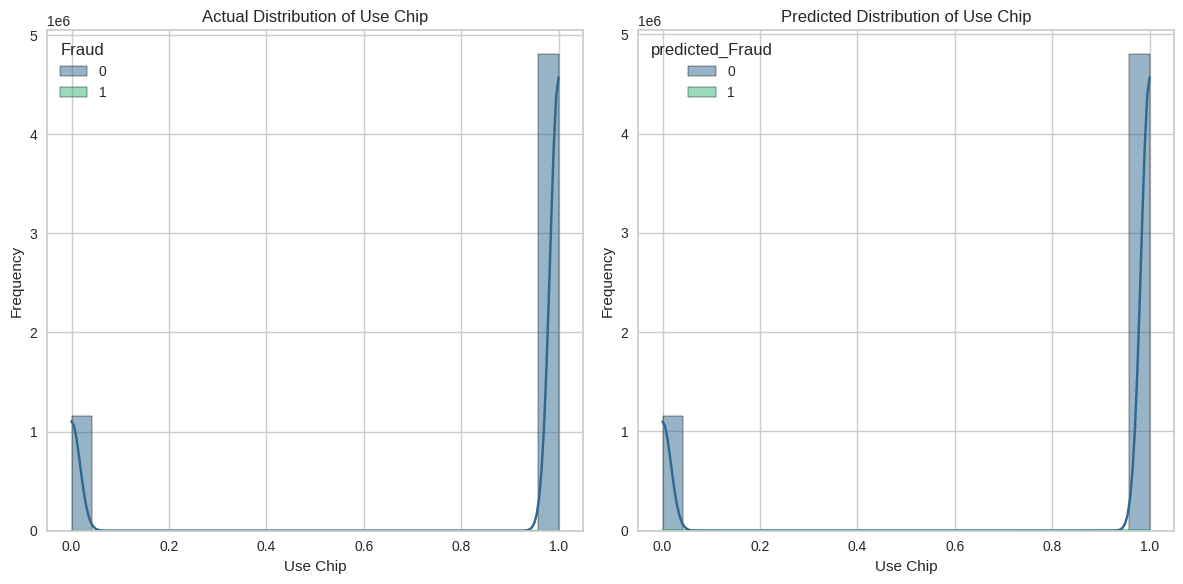

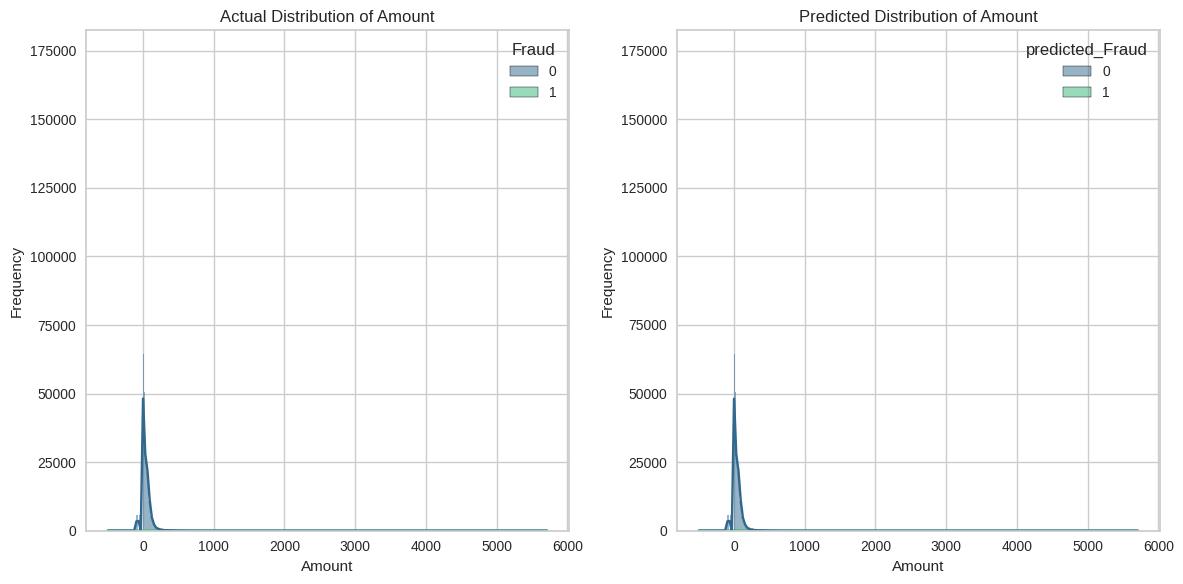

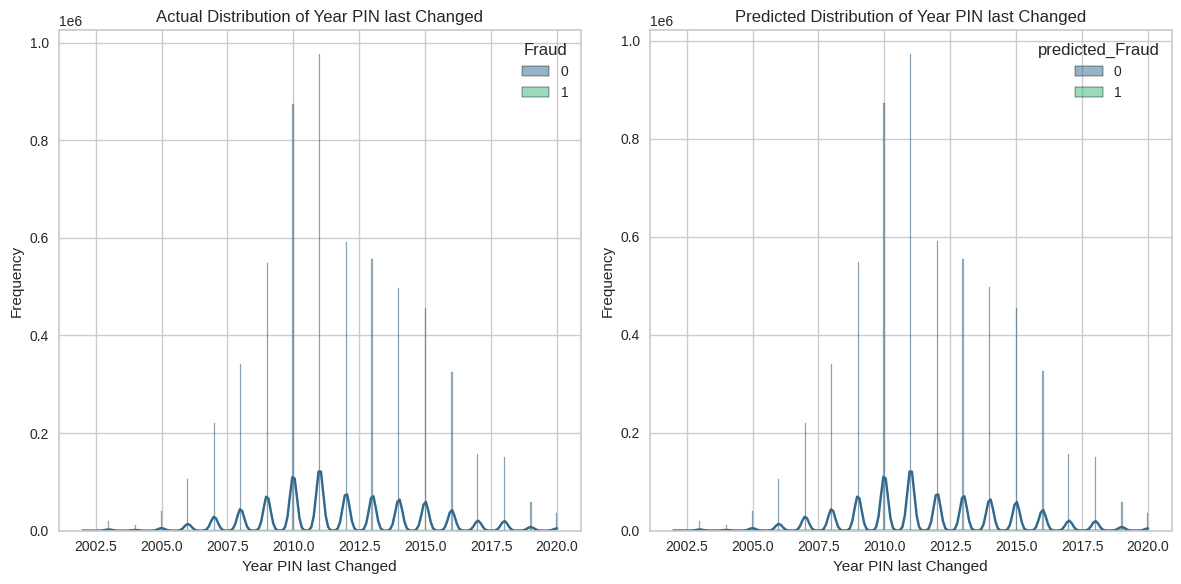

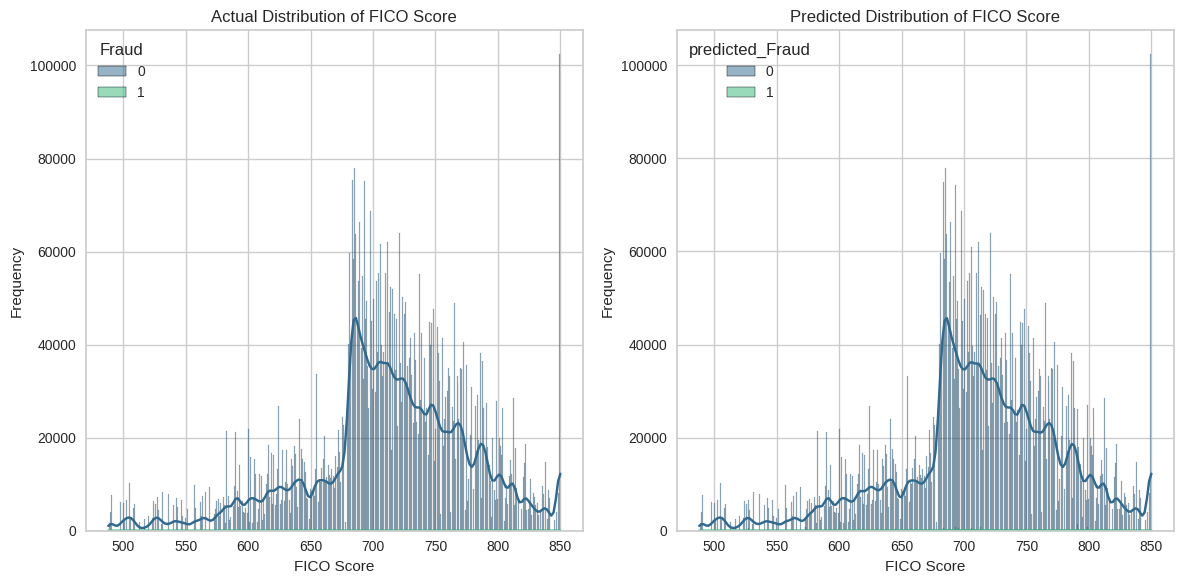

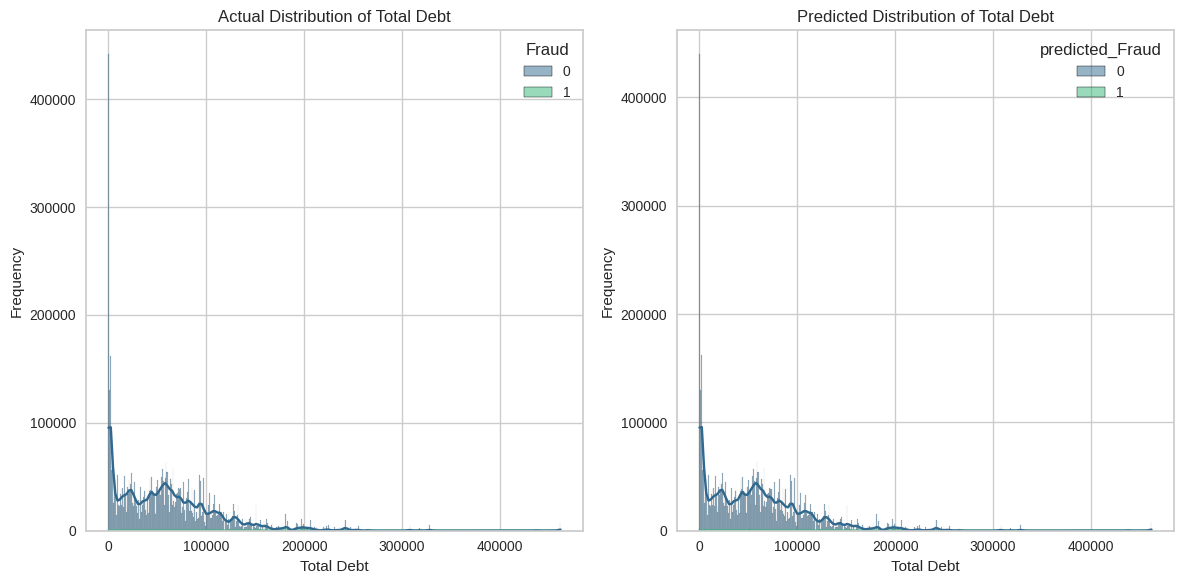

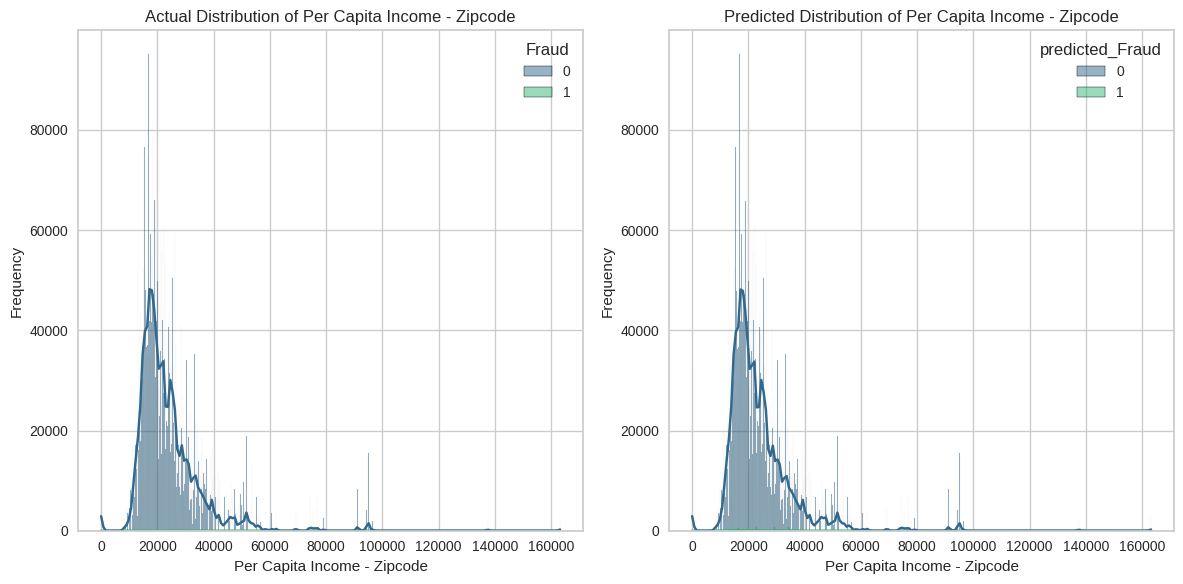

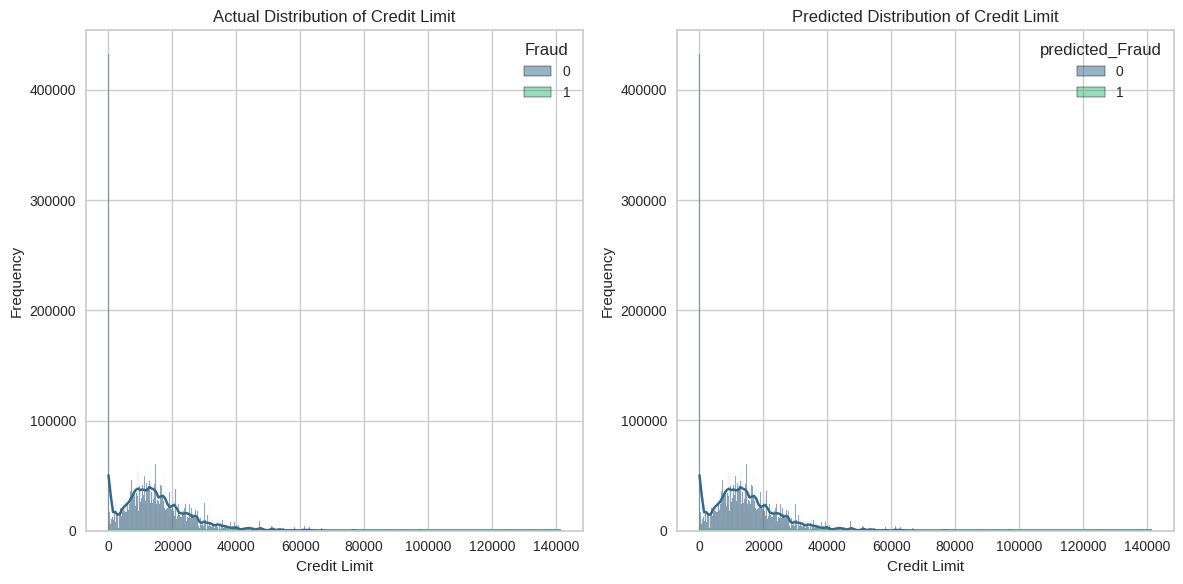

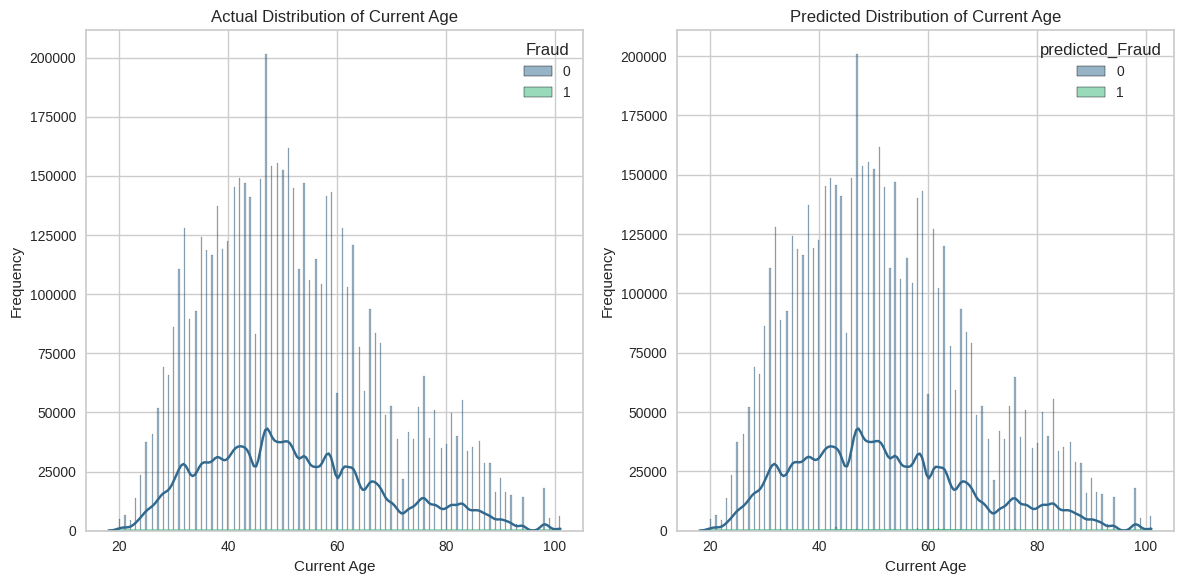

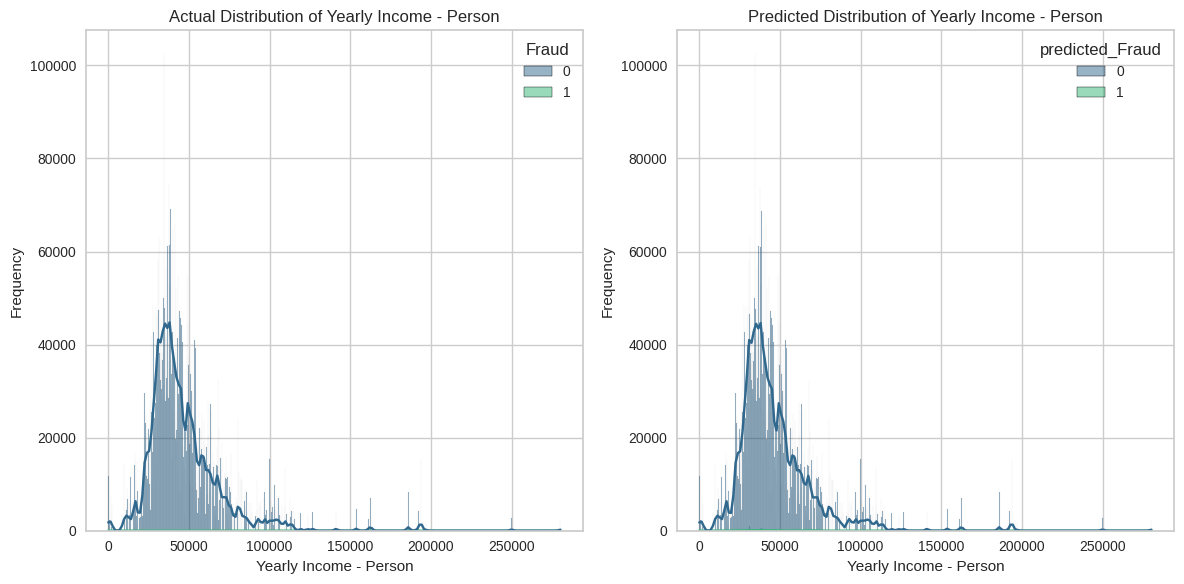

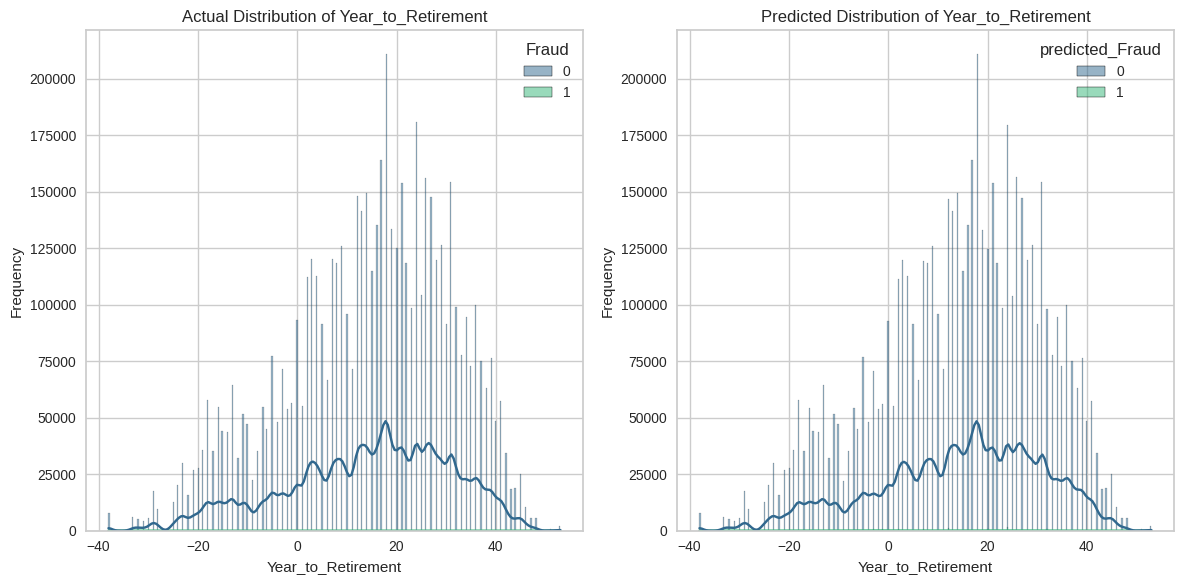

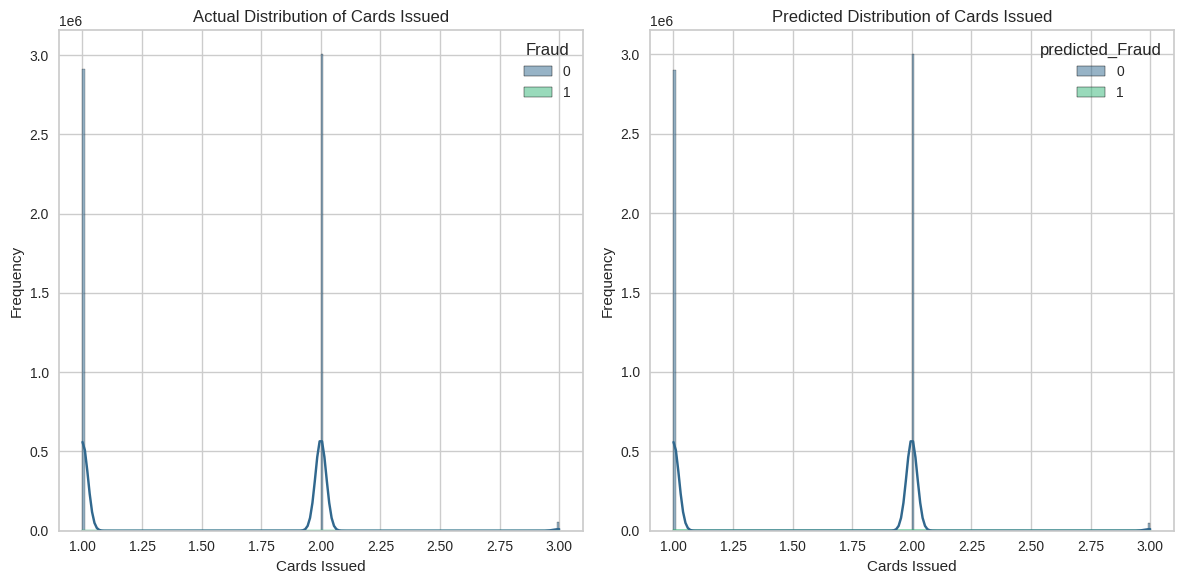

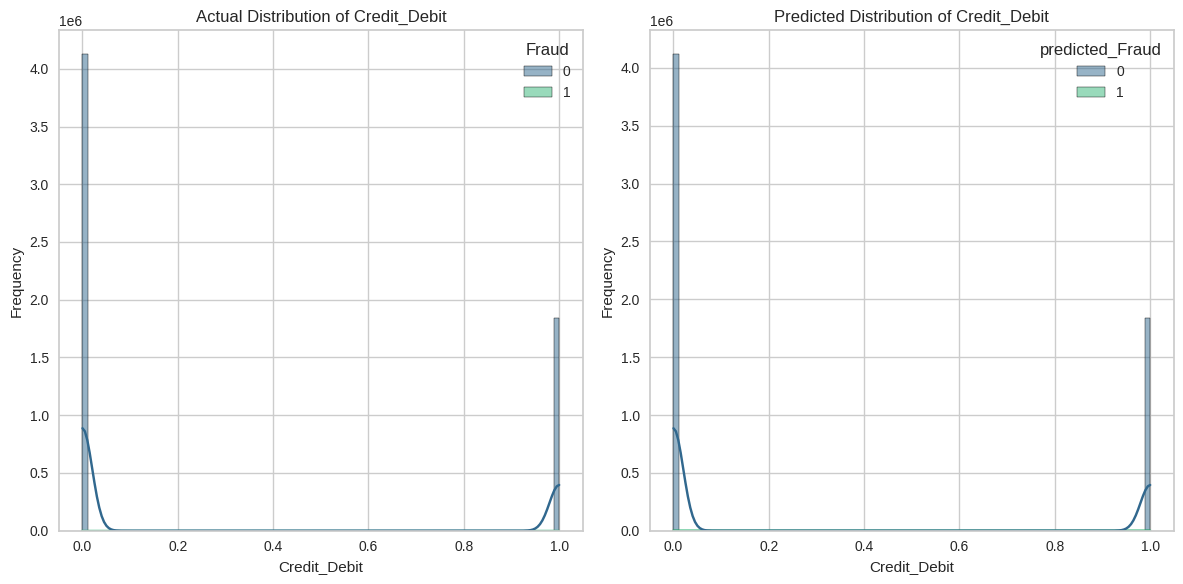

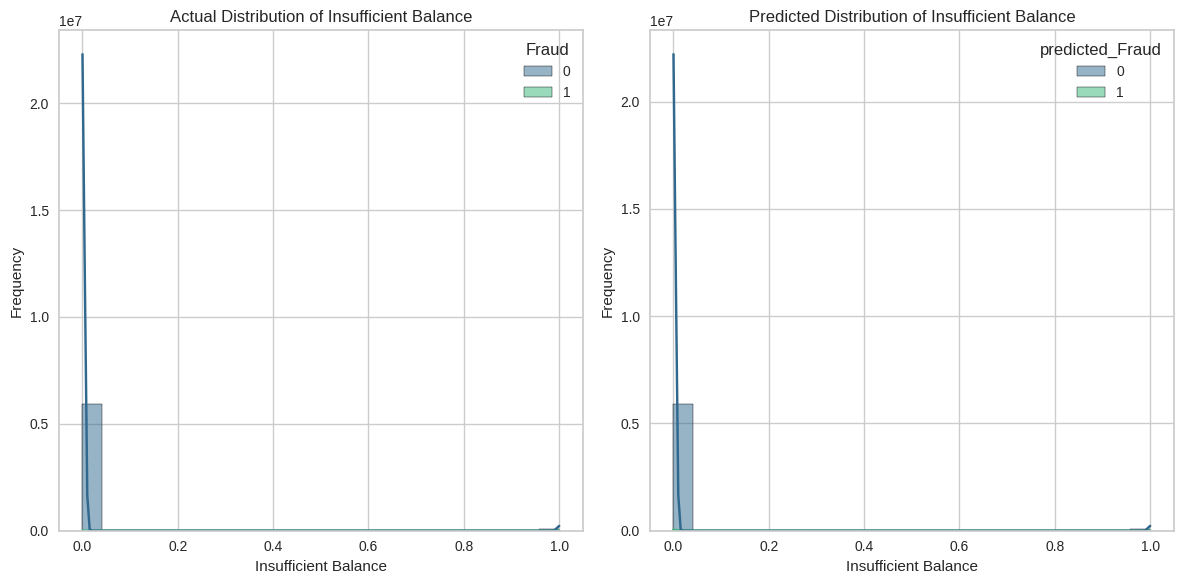

In [ ]:
# List of features based on their importance
important_features = ['Num Credit Cards', 'Use Chip', 'Amount',
                      'Year PIN last Changed', 'FICO Score', 'Total Debt',
                      'Per Capita Income - Zipcode', 'Credit Limit',
                      'Current Age', 'Yearly Income - Person',
                      'Year_to_Retirement', 'Cards Issued', 'Credit_Debit',
                      'Insufficient Balance']


for feature in important_features:
    plt.figure(figsize=(12, 6))

    # Plotting actual distribution
    plt.subplot(1, 2, 1)
    sns.histplot(df_vis, x=feature, hue='Fraud', palette='viridis', kde=True)
    plt.title(f'Actual Distribution of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Frequency')


    # Plotting predicted distribution
    plt.subplot(1, 2, 2)
    sns.histplot(df_vis, x=feature, hue='predicted_Fraud', palette='viridis', kde=True)
    plt.title(f'Predicted Distribution of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Frequency')


    plt.tight_layout()
    plt.show()

In [ ]:
# List of features based on their importance
important_features = ['Num Credit Cards', 'Use Chip', 'Amount',
                      'Year PIN last Changed', 'FICO Score', 'Total Debt',
                      'Per Capita Income - Zipcode', 'Credit Limit',
                      'Current Age', 'Yearly Income - Person',
                      'Year_to_Retirement', 'Cards Issued', 'Credit_Debit',
                      'Insufficient Balance']


for feature in important_features:
    plt.figure(figsize=(12, 6))

    # Plotting actual distribution
    plt.subplot(1, 2, 1)
    sns.histplot(df_vis[df_vis['Fraud']==1], x=feature, hue='Fraud', palette='viridis', kde=True)
    plt.title(f'Actual Distribution of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Frequency')


    # Plotting predicted distribution
    plt.subplot(1, 2, 2)
    sns.histplot(df_vis[df_vis['Fraud']==1], x=feature, hue='predicted_Fraud', palette='viridis', kde=True)
    plt.title(f'Predicted Distribution of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Frequency')


    plt.tight_layout()
    plt.show()

In [ ]:
for feature in important_features:
    plt.figure(figsize=(14, 7))

    # Plotting actual fraud distribution
    plt.subplot(1, 2, 1)
    sns.histplot(df_vis[df_vis['Fraud'] == 1], x=feature, kde=True, palette='viridis', label='Actual Fraud')
    plt.title(f'Actual Fraud Distribution of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Frequency')
    plt.legend()

    sns.histplot(df_vis[df_vis['predicted_Fraud'] == 1], x=feature, kde=True, palette='viridis', label='Actual Fraud')
    plt.title(f'Actual Fraud Distribution of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Frequency')
    plt.legend()

    """# Plotting predicted to be fraud distribution
    plt.subplot(1, 2, 2)
    sns.histplot(df_vis[df_vis['predicted_Fraud'] == 1], x=feature, kde=True, palette='viridis', label='Predicted Fraud')
    plt.title(f'Predicted Fraud Distribution of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Frequency')
    plt.legend()"""

    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import classification_report

predictions = rf_model.predict(validateX)
print(classification_report(validateY, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    899914
           1       0.03      0.60      0.05        86

    accuracy                           1.00    900000
   macro avg       0.51      0.80      0.53    900000
weighted avg       1.00      1.00      1.00    900000



In [ ]:
predictions = xgb_model.predict(validateX)
print(classification_report(validateY, predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    899914
           1       0.00      0.30      0.01        86

    accuracy                           0.99    900000
   macro avg       0.50      0.65      0.50    900000
weighted avg       1.00      0.99      0.99    900000



In [ ]:
df_resampled = pd.read_parquet("/content/df_SMOTEENN_resampled.parquet")

In [ ]:
df[scaled_cols] = robust_scaler.transform(df[scaled_cols])
scaled_df = df[scaled_cols]
scaled_df['Raw'] = 1
scaled_df['Fraud'] = df['Is Fraud?']

In [ ]:
df[scaled_cols] = robust_scaler.transform(df[scaled_cols])
df_sampled_05 = df_resampled.sample(frac=0.001, random_state=1)

### Feature Engineering - SMOTE ENN
https://towardsdatascience.com/imbalanced-classification-in-python-smote-enn-method-db5db06b8d50
https://datascience.stackexchange.com/questions/120359/i-used-smote-enn-to-balance-my-dataset-and-it-improved-the-performance-metrics

In [ ]:
from imblearn.combine import SMOTEENN

X, Y = sclaed_df, df['Is Fraud?']

smote_enn = SMOTEENN(random_state=42)
X_resampled, Y_resampled = smote_enn.fit_resample(X, Y)

In [ ]:
X_resampled['Fraud'] = Y_resampled
X_resampled.to_parquet('df_SMOTEENN_resampled.parquet')

## Model Preparation

### All data

In [ ]:
X_resampled = df_resampled.drop('Fraud', axis=1)
Y_resampled = df_resampled['Fraud']

In [ ]:
df_resampled.columns

Index(['Amount', 'Use Chip', 'Total Debt', 'Year_to_Retirement',
       'Credit Limit', 'Insufficient Balance', 'Credit_Debit',
       'Yearly Income - Person', 'Cards Issued', 'Current Age',
       'Per Capita Income - Zipcode', 'Year PIN last Changed',
       'Num Credit Cards', 'FICO Score', 'Fraud'],
      dtype='object')

In [ ]:
trainX, validateX, testX = X_resampled[:8300000], X_resampled[8300000 : 10100000], X_resampled[10100000 :]
trainY, validateY, testY = Y_resampled[:8300000], Y_resampled[8300000 : 10100000], Y_resampled[10100000 :]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(random_state=42)
model.fit(trainX, trainY)

predictions = model.predict(validateX)
print(classification_report(validateY, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00   1800000

    accuracy                           1.00   1800000
   macro avg       0.50      0.50      0.50   1800000
weighted avg       1.00      1.00      1.00   1800000



In [ ]:
df_resampled = pd.read_parquet('df_SMOTEENN_resampled.parquet')

In [ ]:
df_resampled = df_resampled.sample(frac=1, random_state=1)

In [ ]:
scaled_cols = [
 'Amount',
 'Use Chip',
 'Total Debt',
 'Year_to_Retirement',
 'Credit Limit',
 'Insufficient Balance',
 'Credit_Debit',
 'Yearly Income - Person',
 'Cards Issued',
 'Current Age',
 'Per Capita Income - Zipcode',
 'Year PIN last Changed',
 'Num Credit Cards',
 'FICO Score']

In [ ]:
X, Y = df_resampled[scaled_cols], df_resampled['Fraud']

In [ ]:
trainX, validateX, testX = X[:8300000], X[8300000 : 10100000], X[10100000 :]
trainY, validateY, testY = Y[:8300000], Y[8300000 : 10100000], Y[10100000 :]

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Initialize Linear SVM
svm_model = LinearSVC(random_state=42)

svm_model.fit(trainX, trainY)

# Predictions and Evaluation
predictions = svm_model.predict(validateX)
print(classification_report(validateY, predictions))

              precision    recall  f1-score   support

           0       0.67      0.76      0.71    900468
           1       0.72      0.63      0.68    899532

    accuracy                           0.70   1800000
   macro avg       0.70      0.70      0.69   1800000
weighted avg       0.70      0.70      0.69   1800000



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(trainX, trainY)

predictions = rf_model.predict(validateX)
print(classification_report(validateY, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    900468
           1       1.00      1.00      1.00    899532

    accuracy                           1.00   1800000
   macro avg       1.00      1.00      1.00   1800000
weighted avg       1.00      1.00      1.00   1800000



In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(trainX, trainY)

predictions = xgb_model.predict(validateX)
print(classification_report(validateY, predictions))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    900468
           1       0.99      0.97      0.98    899532

    accuracy                           0.98   1800000
   macro avg       0.98      0.98      0.98   1800000
weighted avg       0.98      0.98      0.98   1800000



In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=trainX.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(trainX, trainY, epochs=10, batch_size=32)

loss, accuracy = model.evaluate(validateX, validateY)
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
259375/259375 [==============================] - 569s 2ms/step - loss: 0.0905 - accuracy: 0.9687
Epoch 2/10
259375/259375 [==============================] - 555s 2ms/step - loss: 0.0485 - accuracy: 0.9849
Epoch 3/10
259375/259375 [==============================] - 557s 2ms/step - loss: 0.0410 - accuracy: 0.9875
Epoch 4/10
259375/259375 [==============================] - 549s 2ms/step - loss: 0.0370 - accuracy: 0.9888
Epoch 5/10
259375/259375 [==============================] - 555s 2ms/step - loss: 0.0343 - accuracy: 0.9897
Epoch 6/10
259375/259375 [==============================] - 557s 2ms/step - loss: 0.0323 - accuracy: 0.9903
Epoch 7/10
259375/259375 [==============================] - 554s 2ms/step - loss: 0.0306 - accuracy: 0.9908
Epoch 8/10
259375/259375 [==============================] - 554s 2ms/step - loss: 0.0294 - accuracy: 0.9912
Epoch 9/10
259375/259375 [==============================] - 553s 2ms/step - loss: 0.0283 - accuracy: 0.9915
Epoch 10/10
56250/56250 [===

### Groupby data - User

In [14]:
df_user_gb_resampled = df_user_gb.sample(frac=1, random_state=1)

In [30]:
X_resample, Y_resample = df_user_gb_resampled.drop(['Is Fraud?'], axis=1), df_user_gb_resampled['Is Fraud?']

In [33]:
trainX, validateX, testX = X_resample[:len(X_resample)*8 // 10], X_resample[len(X_resample)*8 // 10 : len(X_resample)*9 // 10], X_resample[len(X_resample)*9 // 10 :]
trainY, validateY, testY = Y_resample[:len(Y_resample)*8 // 10], Y_resample[len(Y_resample)*8 // 10 : len(Y_resample)*9 // 10], Y_resample[len(Y_resample)*9 // 10 :]

In [36]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Initialize Linear SVM
svm_model = LinearSVC(random_state=42)

svm_model.fit(trainX, trainY)

# Predictions and Evaluation
predictions = svm_model.predict(validateX)
print(classification_report(validateY, predictions))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87       122
           1       1.00      0.05      0.10        38

    accuracy                           0.78       160
   macro avg       0.89      0.53      0.49       160
weighted avg       0.83      0.78      0.69       160



In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(trainX, trainY)

predictions = rf_model.predict(validateX)
print(classification_report(validateY, predictions))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87       122
           1       1.00      0.03      0.05        38

    accuracy                           0.77       160
   macro avg       0.88      0.51      0.46       160
weighted avg       0.82      0.77      0.67       160



In [38]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(trainX, trainY)

predictions = xgb_model.predict(validateX)
print(classification_report(validateY, predictions))

              precision    recall  f1-score   support

           0       0.76      0.97      0.85       122
           1       0.20      0.03      0.05        38

    accuracy                           0.74       160
   macro avg       0.48      0.50      0.45       160
weighted avg       0.63      0.74      0.66       160



In [39]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=trainX.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(trainX, trainY, epochs=10, batch_size=32)

loss, accuracy = model.evaluate(validateX, validateY)
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
41/41 [==============================] - 2s 4ms/step - loss: 297.8326 - accuracy: 0.6516
Epoch 2/10
41/41 [==============================] - 0s 3ms/step - loss: 134.5935 - accuracy: 0.6477
Epoch 3/10
41/41 [==============================] - 0s 3ms/step - loss: 133.3710 - accuracy: 0.6812
Epoch 4/10
41/41 [==============================] - 0s 3ms/step - loss: 111.0643 - accuracy: 0.6602
Epoch 5/10
41/41 [==============================] - 0s 3ms/step - loss: 170.3529 - accuracy: 0.6516
Epoch 6/10
41/41 [==============================] - 0s 4ms/step - loss: 144.7170 - accuracy: 0.6750
Epoch 7/10
41/41 [==============================] - 0s 3ms/step - loss: 86.2191 - accuracy: 0.6859
Epoch 8/10
41/41 [==============================] - 0s 3ms/step - loss: 142.2004 - accuracy: 0.6812
Epoch 9/10
41/41 [==============================] - 0s 3ms/step - loss: 110.7016 - accuracy: 0.6703
Epoch 10/10
5/5 [==============================] - 0s 5ms/step - loss: 232.5163 - accuracy: 0.7625
Te

### Groupby data - User+Card

#### Without SMOTEENN

In [15]:
df_user_card_gb_resampled = df_user_card_gb.sample(frac=1, random_state=1)

In [32]:
X_resample, Y_resample = df_user_card_gb_resampled.drop(['Is Fraud?'], axis=1), df_user_card_gb_resampled['Is Fraud?']

In [17]:
trainX, validateX, testX = X_resample[:len(X_resample)*8 // 10], X_resample[len(X_resample)*8 // 10 : len(X_resample)*9 // 10], X_resample[len(X_resample)*9 // 10 :]
trainY, validateY, testY = Y_resample[:len(Y_resample)*8 // 10], Y_resample[len(Y_resample)*8 // 10 : len(Y_resample)*9 // 10], Y_resample[len(Y_resample)*9 // 10 :]

In [44]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Initialize Linear SVM
svm_model = LinearSVC(random_state=42)

svm_model.fit(trainX, trainY)

# Predictions and Evaluation
predictions = svm_model.predict(validateX)
print(classification_report(validateY, predictions))

              precision    recall  f1-score   support

           0       0.92      0.61      0.73       402
           1       0.05      0.29      0.09        31

    accuracy                           0.59       433
   macro avg       0.49      0.45      0.41       433
weighted avg       0.86      0.59      0.69       433



In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(trainX, trainY)

predictions = rf_model.predict(validateX)
print(classification_report(validateY, predictions))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       402
           1       0.00      0.00      0.00        31

    accuracy                           0.93       433
   macro avg       0.46      0.50      0.48       433
weighted avg       0.86      0.93      0.89       433



In [46]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(trainX, trainY)

predictions = xgb_model.predict(validateX)
print(classification_report(validateY, predictions))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       402
           1       0.00      0.00      0.00        31

    accuracy                           0.92       433
   macro avg       0.46      0.50      0.48       433
weighted avg       0.86      0.92      0.89       433



In [47]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=trainX.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(trainX, trainY, epochs=10, batch_size=32)

loss, accuracy = model.evaluate(validateX, validateY)
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
109/109 [==============================] - 1s 2ms/step - loss: 162.7849 - accuracy: 0.8076
Epoch 2/10
109/109 [==============================] - 0s 2ms/step - loss: 63.9074 - accuracy: 0.8327
Epoch 3/10
109/109 [==============================] - 0s 2ms/step - loss: 50.7634 - accuracy: 0.8307
Epoch 4/10
109/109 [==============================] - 0s 2ms/step - loss: 55.9394 - accuracy: 0.8347
Epoch 5/10
109/109 [==============================] - 0s 2ms/step - loss: 28.8066 - accuracy: 0.8356
Epoch 6/10
109/109 [==============================] - 0s 2ms/step - loss: 56.3248 - accuracy: 0.8292
Epoch 7/10
109/109 [==============================] - 0s 2ms/step - loss: 36.1409 - accuracy: 0.8272
Epoch 8/10
109/109 [==============================] - 0s 2ms/step - loss: 49.7616 - accuracy: 0.8264
Epoch 9/10
109/109 [==============================] - 0s 2ms/step - loss: 40.2934 - accuracy: 0.8353
Epoch 10/10
14/14 [==============================] - 0s 2ms/step - loss: 20.9585 - accurac

#### With SMOTEENN

In [18]:
df_user_card_gb_resampled = df_user_card_gb.sample(frac=1, random_state=1)

In [54]:
from imblearn.combine import SMOTEENN

X, Y = df_user_card_gb_resampled.drop(['Is Fraud?'], axis=1), df_user_card_gb_resampled['Is Fraud?']

smote_enn = SMOTEENN(random_state=42)
X_resample_SMOTE, Y_resample_SMOTE = smote_enn.fit_resample(X, Y)

In [55]:
X_resample_SMOTE['Is Fraud?'] = Y_resample_SMOTE
X_resample_SMOTE = X_resample_SMOTE.sample(frac=1, random_state=1)

X_resample_SMOTE, Y_resample_SMOTE = X_resample_SMOTE.drop(['Is Fraud?'], axis=1), X_resample_SMOTE['Is Fraud?']

In [56]:
trainX, validateX, testX = X_resample_SMOTE[:len(X_resample_SMOTE)*8 // 10], \
                            X_resample_SMOTE[len(X_resample_SMOTE)*8 // 10 : len(X_resample_SMOTE)*9 // 10], \
                            X_resample_SMOTE[len(X_resample_SMOTE)*9 // 10 :]

trainY, validateY, testY = Y_resample_SMOTE[:len(Y_resample_SMOTE)*8 // 10], \
                            Y_resample_SMOTE[len(Y_resample_SMOTE)*8 // 10 : len(Y_resample_SMOTE)*9 // 10], \
                            Y_resample_SMOTE[len(Y_resample_SMOTE)*9 // 10 :]

In [59]:
print(f"train: {len(trainX)}, validate: {len(validateX)}, test: {len(testX)}")
print(f"train: {len(trainY)}, validate: {len(validateY)}, test: {len(testY)}")

train: 4012, validate: 502, test: 502
train: 4012, validate: 502, test: 502


In [57]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Initialize Linear SVM
svm_model = LinearSVC(random_state=42)

svm_model.fit(trainX, trainY)

# Predictions and Evaluation
predictions = svm_model.predict(validateX)
print(classification_report(validateY, predictions))

              precision    recall  f1-score   support

           0       0.41      0.44      0.42       215
           1       0.56      0.53      0.54       287

    accuracy                           0.49       502
   macro avg       0.48      0.48      0.48       502
weighted avg       0.49      0.49      0.49       502



In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(trainX, trainY)

predictions = rf_model.predict(validateX)
print(classification_report(validateY, predictions))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85       215
           1       0.86      0.94      0.90       287

    accuracy                           0.88       502
   macro avg       0.88      0.87      0.87       502
weighted avg       0.88      0.88      0.88       502



In [59]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(trainX, trainY)

predictions = xgb_model.predict(validateX)
print(classification_report(validateY, predictions))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82       215
           1       0.84      0.94      0.89       287

    accuracy                           0.86       502
   macro avg       0.87      0.85      0.86       502
weighted avg       0.87      0.86      0.86       502



In [60]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=trainX.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(trainX, trainY, epochs=10, batch_size=32)

loss, accuracy = model.evaluate(validateX, validateY)
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
126/126 [==============================] - 1s 2ms/step - loss: 221.6646 - accuracy: 0.5376
Epoch 2/10
126/126 [==============================] - 0s 2ms/step - loss: 55.6345 - accuracy: 0.5683
Epoch 3/10
126/126 [==============================] - 0s 2ms/step - loss: 53.8939 - accuracy: 0.5638
Epoch 4/10
126/126 [==============================] - 0s 2ms/step - loss: 50.3145 - accuracy: 0.5803
Epoch 5/10
126/126 [==============================] - 0s 2ms/step - loss: 51.7715 - accuracy: 0.5641
Epoch 6/10
126/126 [==============================] - 0s 2ms/step - loss: 53.3048 - accuracy: 0.5785
Epoch 7/10
126/126 [==============================] - 0s 2ms/step - loss: 65.3836 - accuracy: 0.5606
Epoch 8/10
126/126 [==============================] - 0s 2ms/step - loss: 48.9394 - accuracy: 0.5992
Epoch 9/10
126/126 [==============================] - 0s 4ms/step - loss: 45.6636 - accuracy: 0.5962
Epoch 10/10
16/16 [==============================] - 0s 2ms/step - loss: 106.7338 - accura

###### Retro model evaludation - Raw data

In [33]:
t_trainX, t_validateX, t_testX = X_resample[:len(X_resample)*8 // 10], X_resample[len(X_resample)*8 // 10 : len(X_resample)*9 // 10], X_resample[len(X_resample)*9 // 10 :]
t_trainY, t_validateY, t_testY = Y_resample[:len(Y_resample)*8 // 10], Y_resample[len(Y_resample)*8 // 10 : len(Y_resample)*9 // 10], Y_resample[len(Y_resample)*9 // 10 :]

predictions = rf_model.predict(t_validateX)
print(classification_report(t_validateY, predictions))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92       402
           1       0.31      0.81      0.45        31

    accuracy                           0.86       433
   macro avg       0.65      0.83      0.68       433
weighted avg       0.93      0.86      0.88       433



### Groupby data - User

#### Without SMOTEENN

In [37]:
df_user_gb_resampled = df_user_gb.sample(frac=1, random_state=1)

In [38]:
X_resample, Y_resample = df_user_gb_resampled.drop(['Is Fraud?'], axis=1), df_user_gb_resampled['Is Fraud?']

In [39]:
trainX, validateX, testX = X_resample[:len(X_resample)*8 // 10], X_resample[len(X_resample)*8 // 10 : len(X_resample)*9 // 10], X_resample[len(X_resample)*9 // 10 :]
trainY, validateY, testY = Y_resample[:len(Y_resample)*8 // 10], Y_resample[len(Y_resample)*8 // 10 : len(Y_resample)*9 // 10], Y_resample[len(Y_resample)*9 // 10 :]

In [40]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Initialize Linear SVM
svm_model = LinearSVC(random_state=42)

svm_model.fit(trainX, trainY)

# Predictions and Evaluation
predictions = svm_model.predict(validateX)
print(classification_report(validateY, predictions))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87       122
           1       1.00      0.03      0.05        38

    accuracy                           0.77       160
   macro avg       0.88      0.51      0.46       160
weighted avg       0.82      0.77      0.67       160



In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(trainX, trainY)

predictions = rf_model.predict(validateX)
print(classification_report(validateY, predictions))

              precision    recall  f1-score   support

           0       0.76      1.00      0.87       122
           1       0.00      0.00      0.00        38

    accuracy                           0.76       160
   macro avg       0.38      0.50      0.43       160
weighted avg       0.58      0.76      0.66       160



In [42]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(trainX, trainY)

predictions = xgb_model.predict(validateX)
print(classification_report(validateY, predictions))

              precision    recall  f1-score   support

           0       0.76      0.97      0.85       122
           1       0.20      0.03      0.05        38

    accuracy                           0.74       160
   macro avg       0.48      0.50      0.45       160
weighted avg       0.63      0.74      0.66       160



In [43]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=trainX.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(trainX, trainY, epochs=10, batch_size=32)

loss, accuracy = model.evaluate(validateX, validateY)
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
41/41 [==============================] - 1s 3ms/step - loss: 359.5093 - accuracy: 0.6532
Epoch 2/10
41/41 [==============================] - 0s 3ms/step - loss: 103.2626 - accuracy: 0.6641
Epoch 3/10
41/41 [==============================] - 0s 3ms/step - loss: 251.7460 - accuracy: 0.6578
Epoch 4/10
41/41 [==============================] - 0s 2ms/step - loss: 102.6874 - accuracy: 0.6734
Epoch 5/10
41/41 [==============================] - 0s 3ms/step - loss: 48.8479 - accuracy: 0.6703
Epoch 6/10
41/41 [==============================] - 0s 3ms/step - loss: 53.3220 - accuracy: 0.6742
Epoch 7/10
41/41 [==============================] - 0s 3ms/step - loss: 54.3059 - accuracy: 0.6726
Epoch 8/10
41/41 [==============================] - 0s 3ms/step - loss: 48.5763 - accuracy: 0.6687
Epoch 9/10
41/41 [==============================] - 0s 3ms/step - loss: 56.6647 - accuracy: 0.6851
Epoch 10/10
5/5 [==============================] - 0s 4ms/step - loss: 56.7703 - accuracy: 0.7625
Test Ac

#### With SMOTEENN

In [44]:
df_user_gb_resampled = df_user_gb.sample(frac=1, random_state=1)

In [45]:
from imblearn.combine import SMOTEENN

X, Y = df_user_gb_resampled.drop(['Is Fraud?'], axis=1), df_user_gb_resampled['Is Fraud?']

user_smote_enn = SMOTEENN(random_state=42)
X_resample_SMOTE, Y_resample_SMOTE = user_smote_enn.fit_resample(X, Y)

In [46]:
X_resample_SMOTE['Is Fraud?'] = Y_resample_SMOTE
X_resample_SMOTE = X_resample_SMOTE.sample(frac=1, random_state=1)

X_resample_SMOTE, Y_resample_SMOTE = X_resample_SMOTE.drop(['Is Fraud?'], axis=1), X_resample_SMOTE['Is Fraud?']

In [47]:
trainX, validateX, testX = X_resample_SMOTE[:len(X_resample_SMOTE)*8 // 10], \
                            X_resample_SMOTE[len(X_resample_SMOTE)*8 // 10 : len(X_resample_SMOTE)*9 // 10], \
                            X_resample_SMOTE[len(X_resample_SMOTE)*9 // 10 :]

trainY, validateY, testY = Y_resample_SMOTE[:len(Y_resample_SMOTE)*8 // 10], \
                            Y_resample_SMOTE[len(Y_resample_SMOTE)*8 // 10 : len(Y_resample_SMOTE)*9 // 10], \
                            Y_resample_SMOTE[len(Y_resample_SMOTE)*9 // 10 :]

In [48]:
print(f"train: {len(trainX)}, validate: {len(validateX)}, test: {len(testX)}")
print(f"train: {len(trainY)}, validate: {len(validateY)}, test: {len(testY)}")

train: 952, validate: 119, test: 120
train: 952, validate: 119, test: 120


In [49]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Initialize Linear SVM
svm_model = LinearSVC(random_state=42)

svm_model.fit(trainX, trainY)

# Predictions and Evaluation
predictions = svm_model.predict(validateX)
print(classification_report(validateY, predictions))

              precision    recall  f1-score   support

           0       0.44      0.40      0.42        47
           1       0.63      0.67      0.65        72

    accuracy                           0.56       119
   macro avg       0.54      0.54      0.54       119
weighted avg       0.56      0.56      0.56       119



In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(trainX, trainY)

predictions = rf_model.predict(validateX)
print(classification_report(validateY, predictions))

              precision    recall  f1-score   support

           0       0.92      0.51      0.66        47
           1       0.75      0.97      0.85        72

    accuracy                           0.79       119
   macro avg       0.84      0.74      0.75       119
weighted avg       0.82      0.79      0.77       119



In [51]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(trainX, trainY)

predictions = xgb_model.predict(validateX)
print(classification_report(validateY, predictions))

              precision    recall  f1-score   support

           0       0.87      0.57      0.69        47
           1       0.77      0.94      0.85        72

    accuracy                           0.80       119
   macro avg       0.82      0.76      0.77       119
weighted avg       0.81      0.80      0.79       119



In [52]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=trainX.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(trainX, trainY, epochs=10, batch_size=32)

loss, accuracy = model.evaluate(validateX, validateY)
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
30/30 [==============================] - 1s 5ms/step - loss: 462.1775 - accuracy: 0.5399
Epoch 2/10
30/30 [==============================] - 0s 4ms/step - loss: 115.4606 - accuracy: 0.5777
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 93.0709 - accuracy: 0.6534
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 123.2041 - accuracy: 0.5924
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 86.2578 - accuracy: 0.6092
Epoch 6/10
30/30 [==============================] - 0s 4ms/step - loss: 67.8283 - accuracy: 0.6460
Epoch 7/10
30/30 [==============================] - 1s 24ms/step - loss: 93.3035 - accuracy: 0.6134
Epoch 8/10
30/30 [==============================] - 1s 22ms/step - loss: 190.3819 - accuracy: 0.5872
Epoch 9/10
30/30 [==============================] - 0s 7ms/step - loss: 75.6371 - accuracy: 0.6418
Epoch 10/10
4/4 [==============================] - 0s 4ms/step - loss: 63.6176 - accuracy: 0.5462
Test 

###### Retro model evaludation - Raw data

In [53]:
t_trainX, t_validateX, t_testX = X_resample[:len(X_resample)*8 // 10], X_resample[len(X_resample)*8 // 10 : len(X_resample)*9 // 10], X_resample[len(X_resample)*9 // 10 :]
t_trainY, t_validateY, t_testY = Y_resample[:len(Y_resample)*8 // 10], Y_resample[len(Y_resample)*8 // 10 : len(Y_resample)*9 // 10], Y_resample[len(Y_resample)*9 // 10 :]

predictions = rf_model.predict(t_validateX)
print(classification_report(t_validateY, predictions))

              precision    recall  f1-score   support

           0       0.94      0.69      0.80       122
           1       0.46      0.87      0.61        38

    accuracy                           0.73       160
   macro avg       0.70      0.78      0.70       160
weighted avg       0.83      0.73      0.75       160



### Model checkpoint

In [ ]:
import pickle

# Save the Random Forest model
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

# Save the XGBoost model
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

# Save the entire model (architecture + weights + optimizer state)
model.save('nn_64_32')

In [ ]:
!zip -r /content/nn_64_32.zip /content/nn_64_32

  adding: content/nn_64_32/ (stored 0%)
  adding: content/nn_64_32/fingerprint.pb (stored 0%)
  adding: content/nn_64_32/variables/ (stored 0%)
  adding: content/nn_64_32/variables/variables.data-00000-of-00001 (deflated 14%)
  adding: content/nn_64_32/variables/variables.index (deflated 60%)
  adding: content/nn_64_32/assets/ (stored 0%)
  adding: content/nn_64_32/saved_model.pb (deflated 86%)
  adding: content/nn_64_32/keras_metadata.pb (deflated 86%)


In [ ]:
from google.colab import files
files.download("/content/nn_64_32.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model Restore

In [ ]:
import pickle

rf_model = pickle.load(open('random_forest_model.pkl', 'rb'))
xgb_model = pickle.load(open('xgboost_model.pkl', 'rb'))

## Model visualization

### All data

##### Heatmap

In [ ]:
!pip install yellowbrick

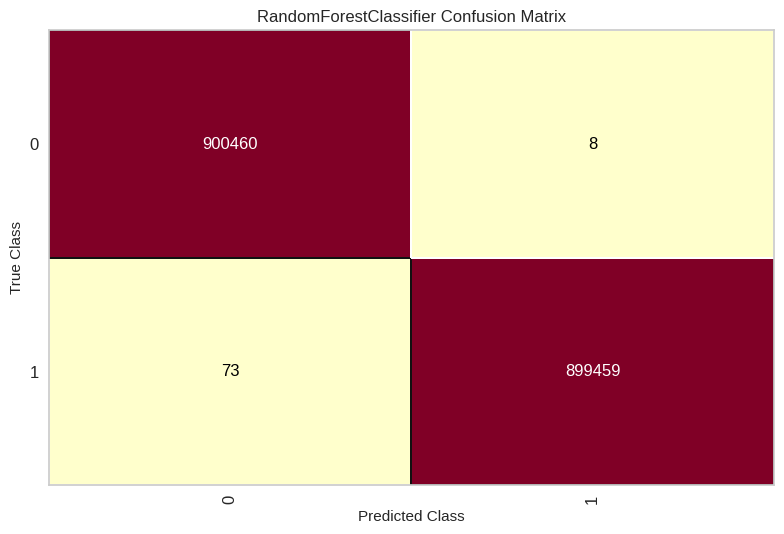

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
from yellowbrick.classifier import ConfusionMatrix, ROCAUC

cm = ConfusionMatrix(rf_model)
cm.fit(trainX, trainY)
cm.score(validateX, validateY)
cm.show()

##### ROCAUC

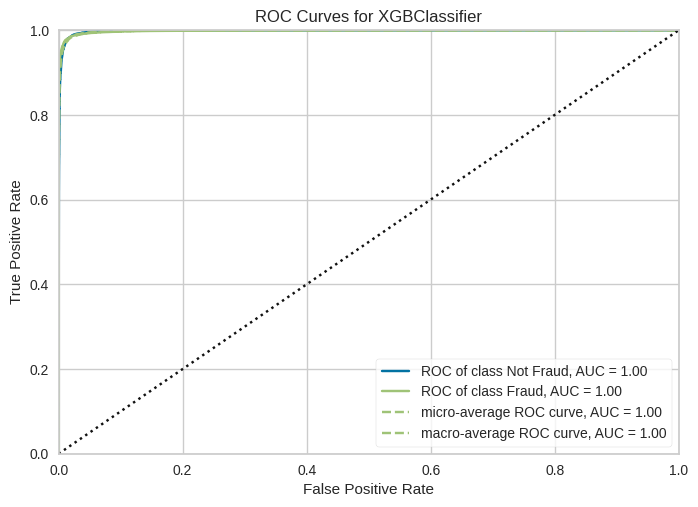

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
from yellowbrick.classifier import ROCAUC

# ROC Curve
visualizer = ROCAUC(xgb_model, classes=['Not Fraud', 'Fraud'])
visualizer.fit(trainX, trainY)
visualizer.score(testX, testY)
visualizer.show()

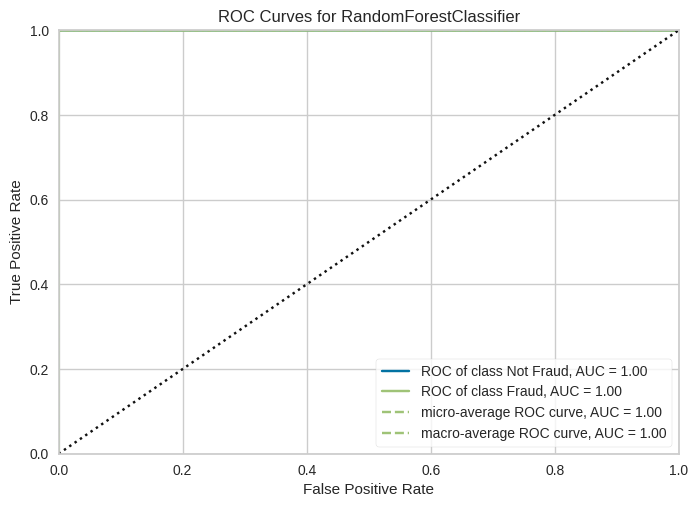

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
# ROC Curve
visualizer = ROCAUC(rf_model, classes=['Not Fraud', 'Fraud'])
visualizer.fit(trainX, trainY)
visualizer.score(testX, testY)
visualizer.show()

In [ ]:
trainX.columns

Index(['Amount', 'Use Chip', 'Total Debt', 'Year_to_Retirement',
       'Credit Limit', 'Insufficient Balance', 'Credit_Debit',
       'Yearly Income - Person', 'Cards Issued', 'Current Age',
       'Per Capita Income - Zipcode', 'Year PIN last Changed',
       'Num Credit Cards', 'FICO Score'],
      dtype='object')

##### eli5

In [ ]:
!pip install eli5

In [ ]:
import eli5

eli5.show_weights(rf_model, feature_names = scaled_cols)

##### shap

In [ ]:
!pip install shap

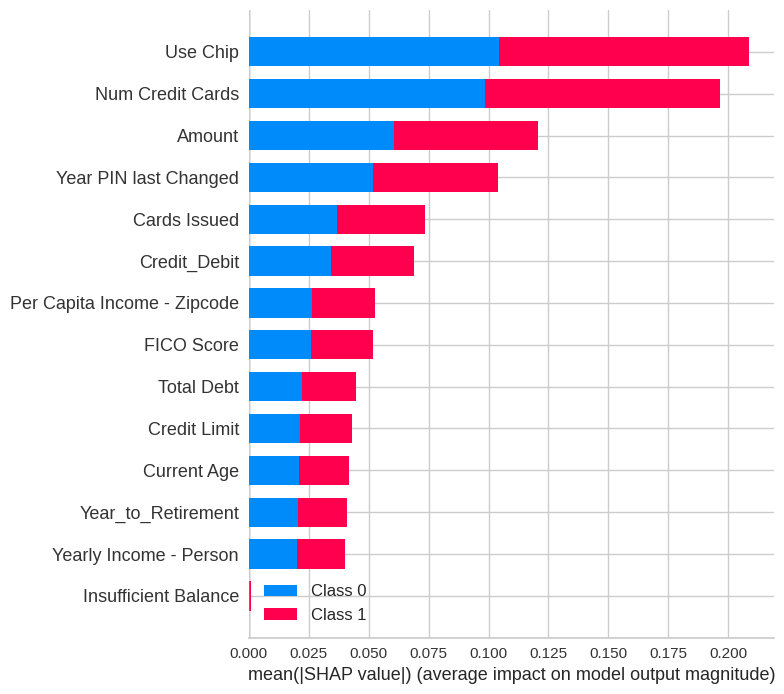

In [ ]:
import shap


# Create a shap explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(validateX)

# Visualize the first prediction's explanation
shap.force_plot(explainer.expected_value[1], shap_values[1][0], validateX.iloc[0])
shap.summary_plot(shap_values, trainX, feature_names=scaled_cols)

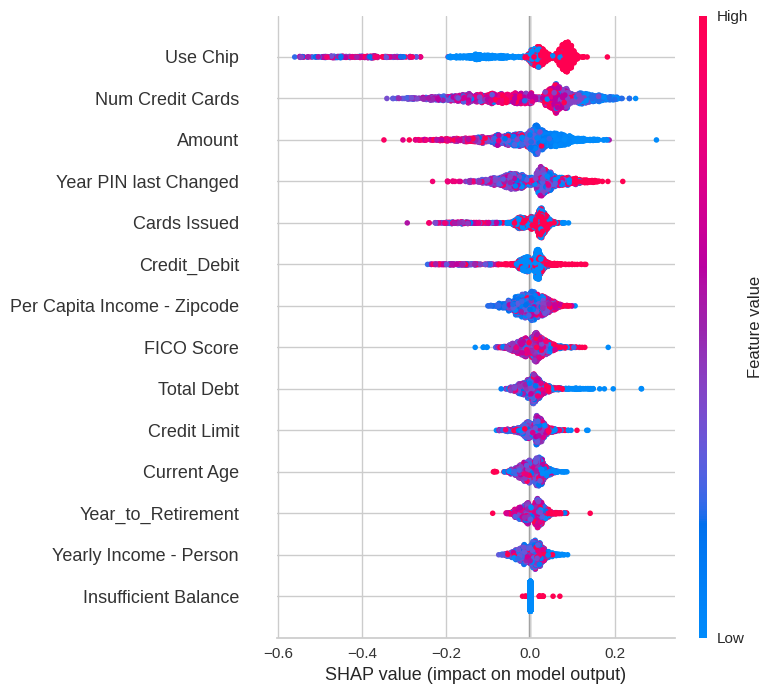

In [ ]:
shap.summary_plot(shap_values[0], validateX)

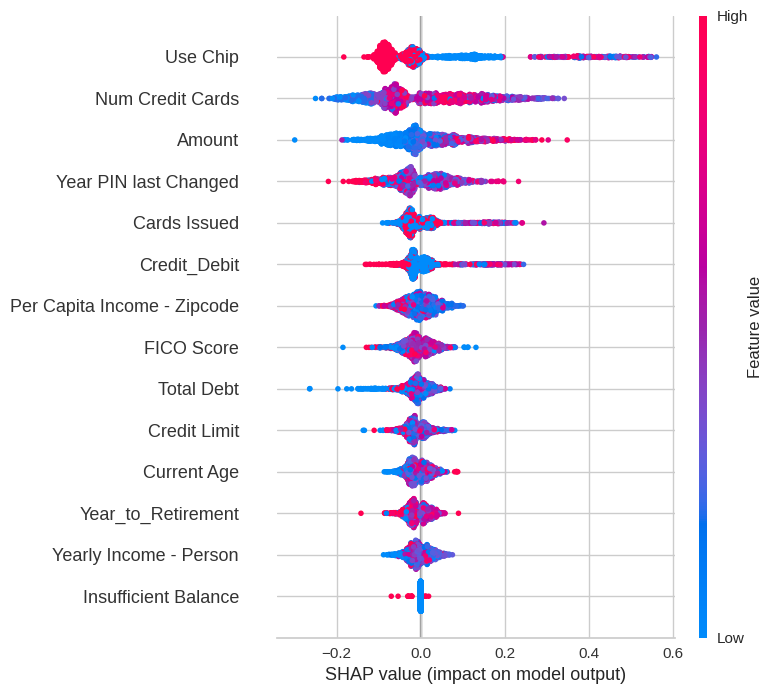

In [ ]:
shap.summary_plot(shap_values[1], validateX)

### Groupby data - User + Card

#### with SMOTEENN

##### Heatmap

In [ ]:
!pip install yellowbrick

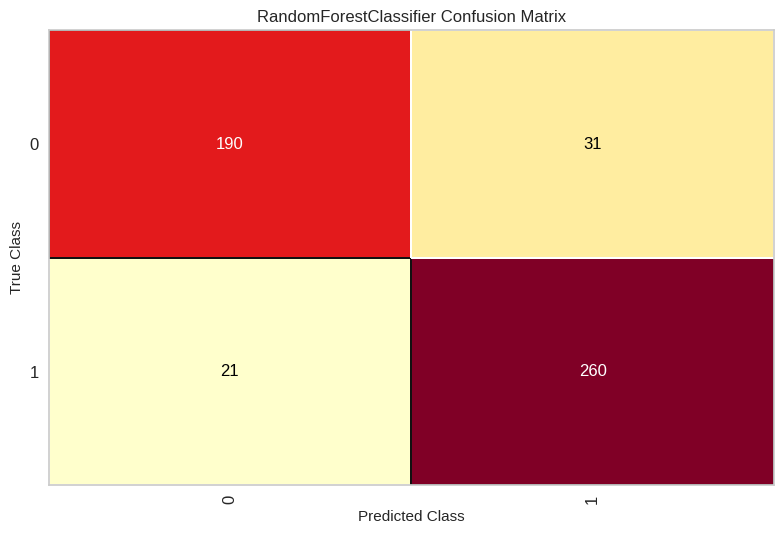

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [79]:
from yellowbrick.classifier import ConfusionMatrix, ROCAUC

cm = ConfusionMatrix(rf_model)
cm.fit(trainX, trainY)
cm.score(validateX, validateY)
cm.show()

##### ROCAUC

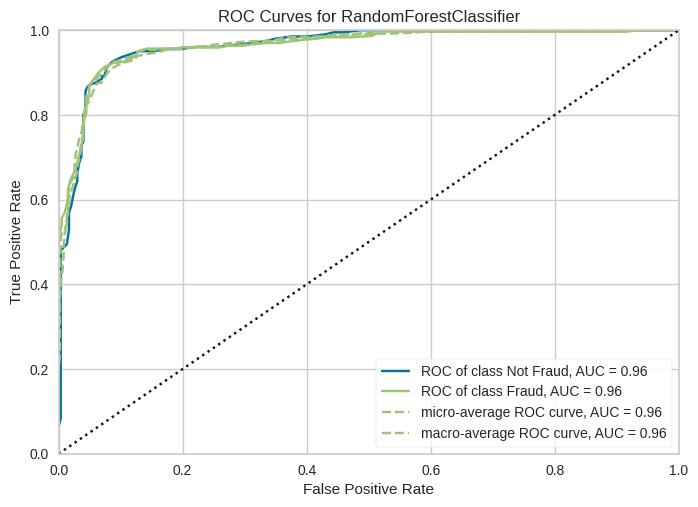

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [81]:
# ROC Curve
visualizer = ROCAUC(rf_model, classes=['Not Fraud', 'Fraud'])
visualizer.fit(trainX, trainY)
visualizer.score(testX, testY)
visualizer.show()

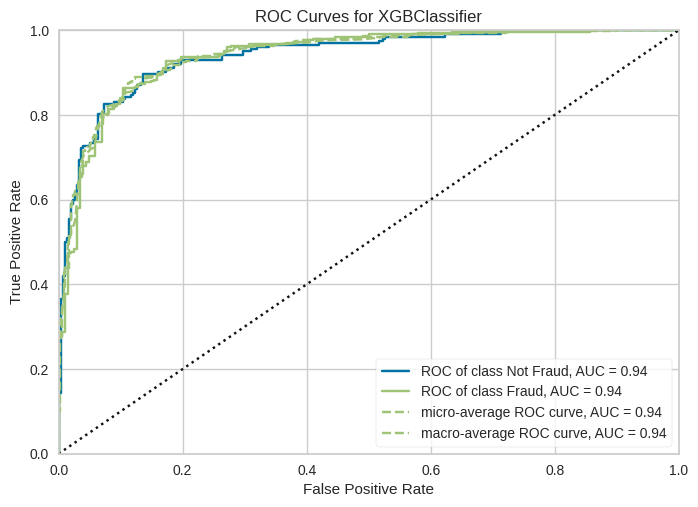

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [80]:
from yellowbrick.classifier import ROCAUC

# ROC Curve
visualizer = ROCAUC(xgb_model, classes=['Not Fraud', 'Fraud'])
visualizer.fit(trainX, trainY)
visualizer.score(testX, testY)
visualizer.show()

##### eli5

In [ ]:
!pip install eli5

In [62]:
import eli5

eli5.show_weights(rf_model, feature_names = list(X_resample_SMOTE.columns))

##### shap score

In [ ]:
!pip install shap

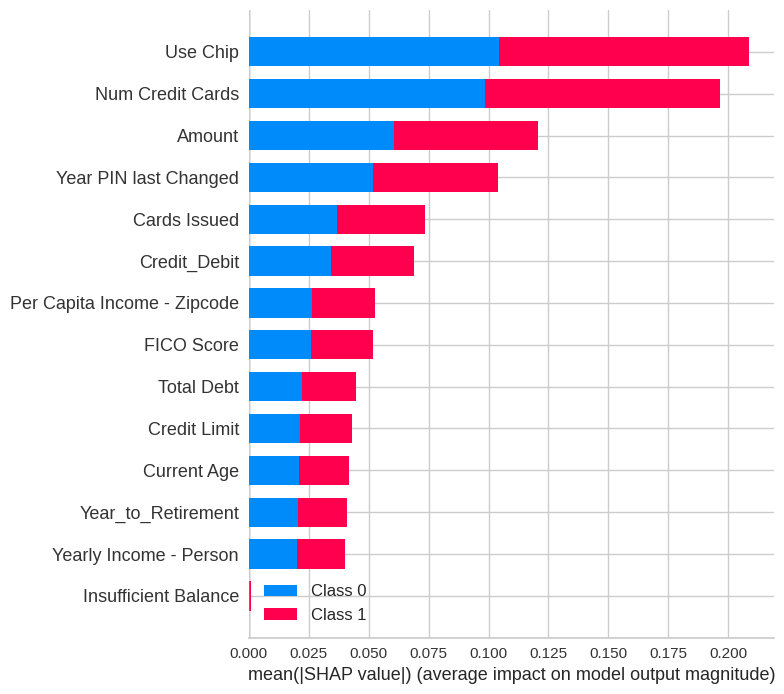

In [ ]:
import shap


# Create a shap explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(validateX)

# Visualize the first prediction's explanation
shap.force_plot(explainer.expected_value[1], shap_values[1][0], validateX.iloc[0])
shap.summary_plot(shap_values, trainX, feature_names=scaled_cols)

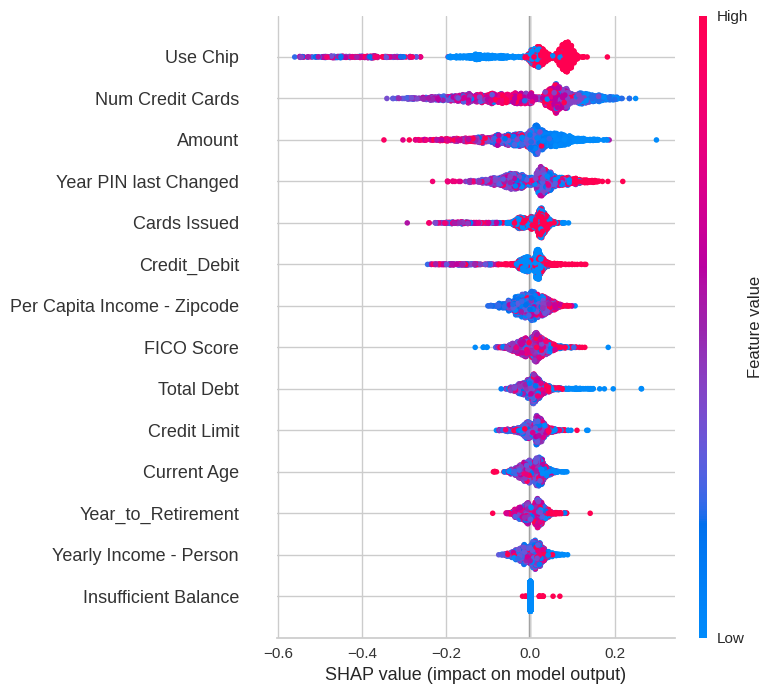

In [ ]:
shap.summary_plot(shap_values[0], validateX)

#### Without SMOTEENN

In [146]:
df_user_card_gb_resampled = df_user_card_gb.sample(frac=1, random_state=1)

In [147]:
X_resample, Y_resample = df_user_card_gb_resampled.drop(['Is Fraud?'], axis=1), df_user_card_gb_resampled['Is Fraud?']

In [168]:
trainX, validateX, testX = X_resample[:len(X_resample)*8 // 10], X_resample[len(X_resample)*8 // 10 : len(X_resample)*9 // 10], X_resample[len(X_resample)*9 // 10 :]
trainY, validateY, testY = Y_resample[:len(Y_resample)*8 // 10], Y_resample[len(Y_resample)*8 // 10 : len(Y_resample)*9 // 10], Y_resample[len(Y_resample)*9 // 10 :]

##### Heatmap

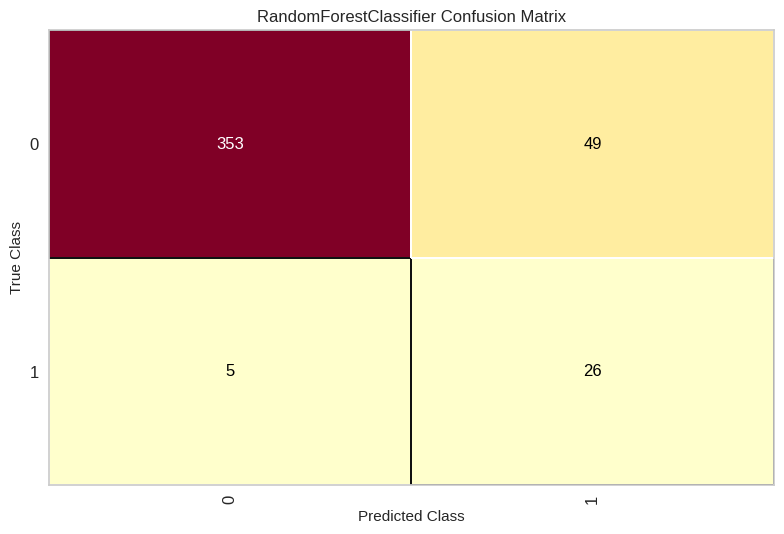

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [89]:
from yellowbrick.classifier import ConfusionMatrix, ROCAUC

cm = ConfusionMatrix(rf_model)
cm.fit(trainX, trainY)
cm.score(validateX, validateY)
cm.show()

##### ROCAUC

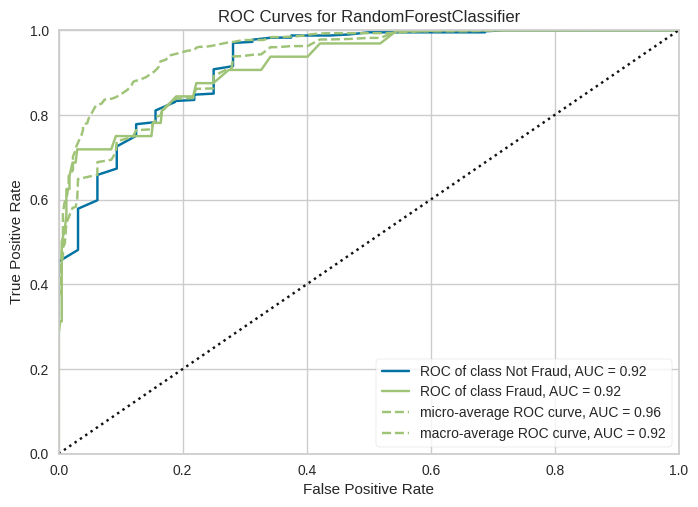

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [90]:
# ROC Curve
visualizer = ROCAUC(rf_model, classes=['Not Fraud', 'Fraud'])
visualizer.fit(trainX, trainY)
visualizer.score(testX, testY)
visualizer.show()

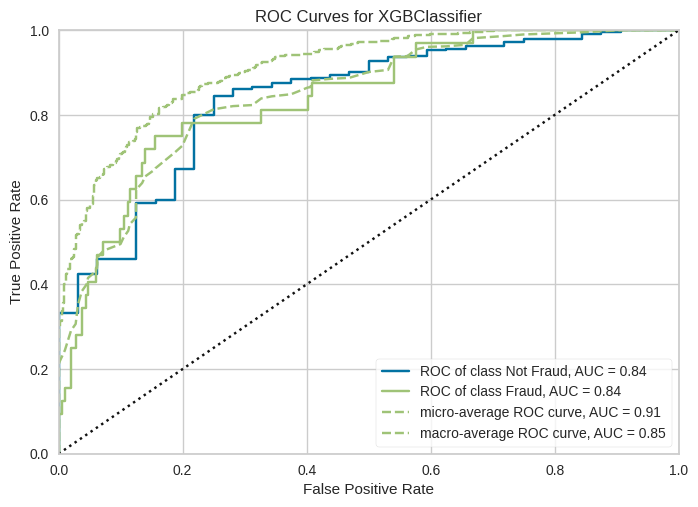

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [91]:
from yellowbrick.classifier import ROCAUC

# ROC Curve
visualizer = ROCAUC(xgb_model, classes=['Not Fraud', 'Fraud'])
visualizer.fit(trainX, trainY)
visualizer.score(testX, testY)
visualizer.show()

##### shap score

In [181]:
features = df_user_gb.columns.difference(['User', 'Card', 'Is Fraud?'])

In [ ]:
!pip install shap

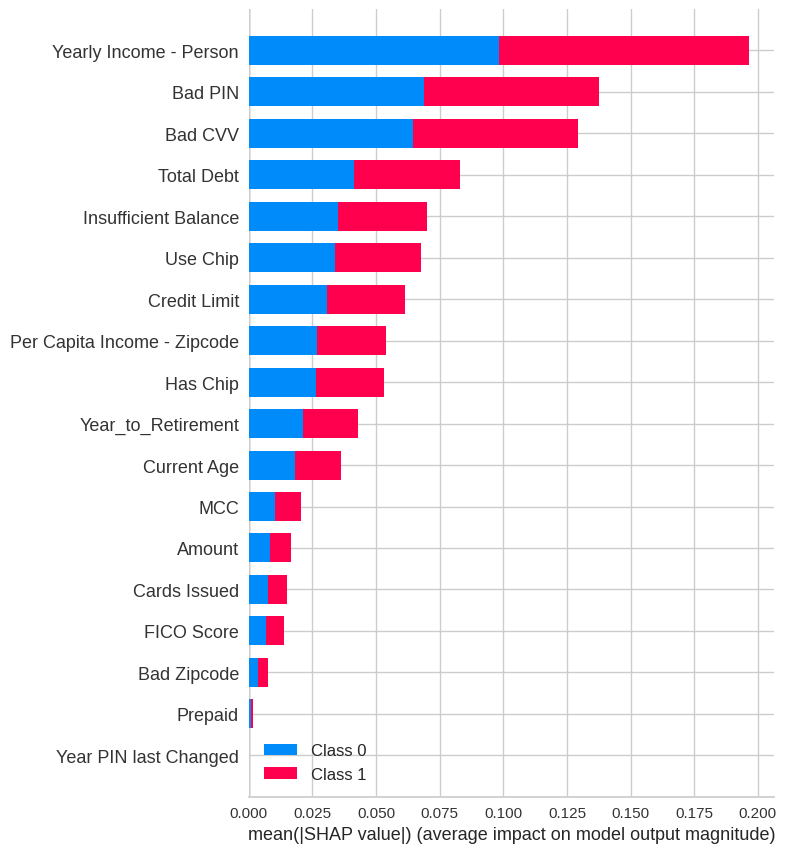

In [183]:
import shap


# Create a shap explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(validateX[features])

# Visualize the first prediction's explanation
#shap.force_plot(explainer.expected_value[1], shap_values[1][0], validateX.iloc[0])
shap.summary_plot(shap_values, validateX[features], feature_names=features)

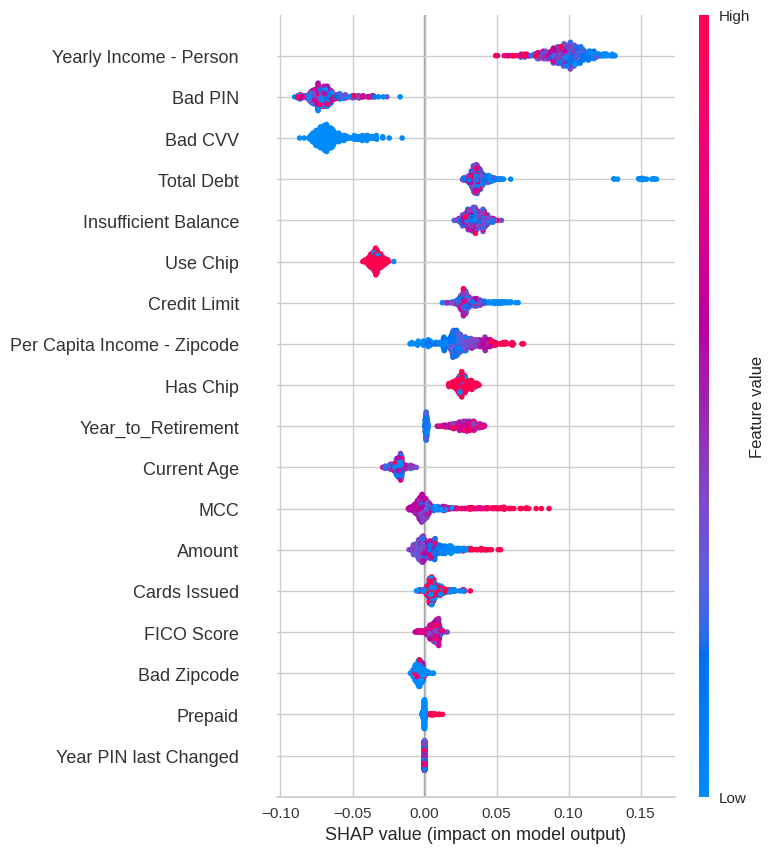

In [184]:
shap.summary_plot(shap_values[0], validateX[features])

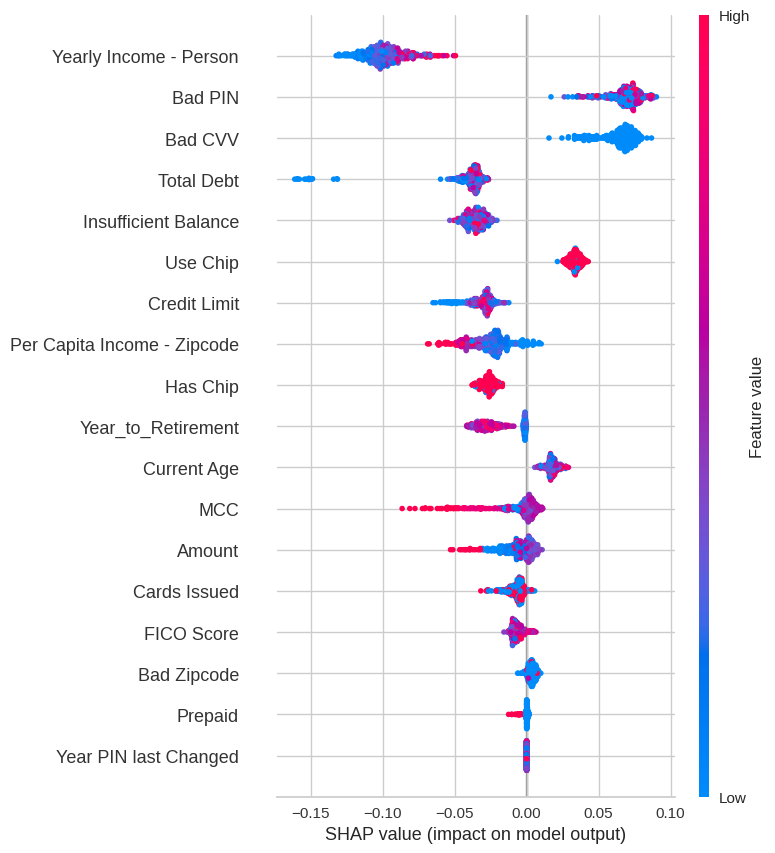

In [185]:
shap.summary_plot(shap_values[1], validateX[features])

In [157]:
# Selecting SHAP values for the positive class
# shap_values[1] corresponds to the SHAP values for the class labeled as '1' (usually the positive class in binary classification)
shap_values_positive_class = shap_values[1]

# Convert the selected SHAP values to a DataFrame
shap_df = pd.DataFrame(shap_values_positive_class, columns=validateX.columns)

# Concatenate SHAP values DataFrame with the original validation data
validateX_with_shap = pd.concat([validateX.reset_index(drop=True), shap_df], axis=1)

In [162]:
# Sum of absolute SHAP values for each instance
validateX_with_shap['sum_shap'] = shap_df.sum(axis=1)
validateX_with_shap['Is Fraud?'] = validateY.reset_index(drop=True)

# Sort by sum of absolute SHAP values
validateX_sorted_by_shap = validateX_with_shap.sort_values(by='sum_shap', ascending=False)

### Model Decision Visualization

In [ ]:
# List of features based on their importance
important_features = ['Num Credit Cards', 'Use Chip', 'Amount',
                      'Year PIN last Changed', 'FICO Score', 'Total Debt',
                      'Per Capita Income - Zipcode', 'Credit Limit',
                      'Current Age', 'Yearly Income - Person',
                      'Year_to_Retirement', 'Cards Issued', 'Credit_Debit',
                      'Insufficient Balance']

# Setting a common style
sns.set(style="whitegrid")

In [ ]:
predictions = rf_model.predict(df_sampled_05.drop('Fraud', axis=1))
df_sampled_05['predicted_Fraud'] = predictions

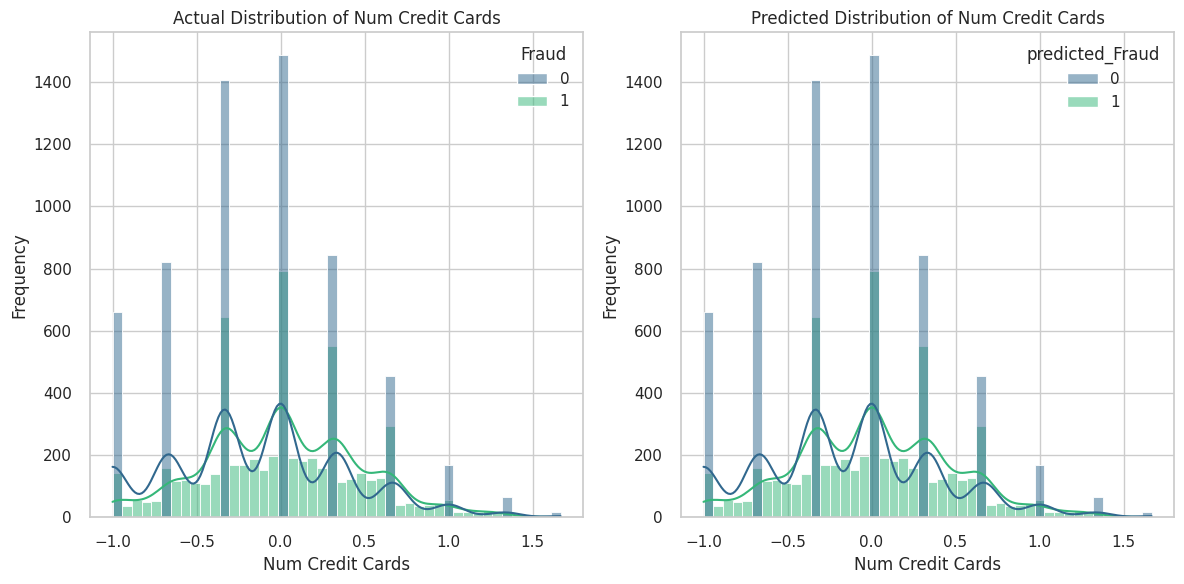

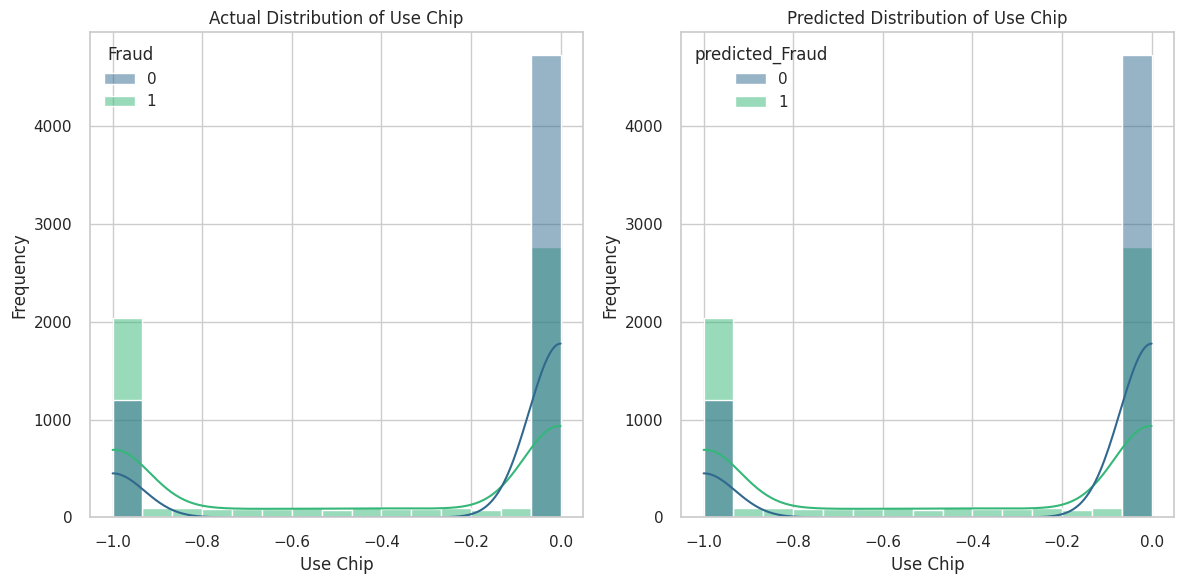

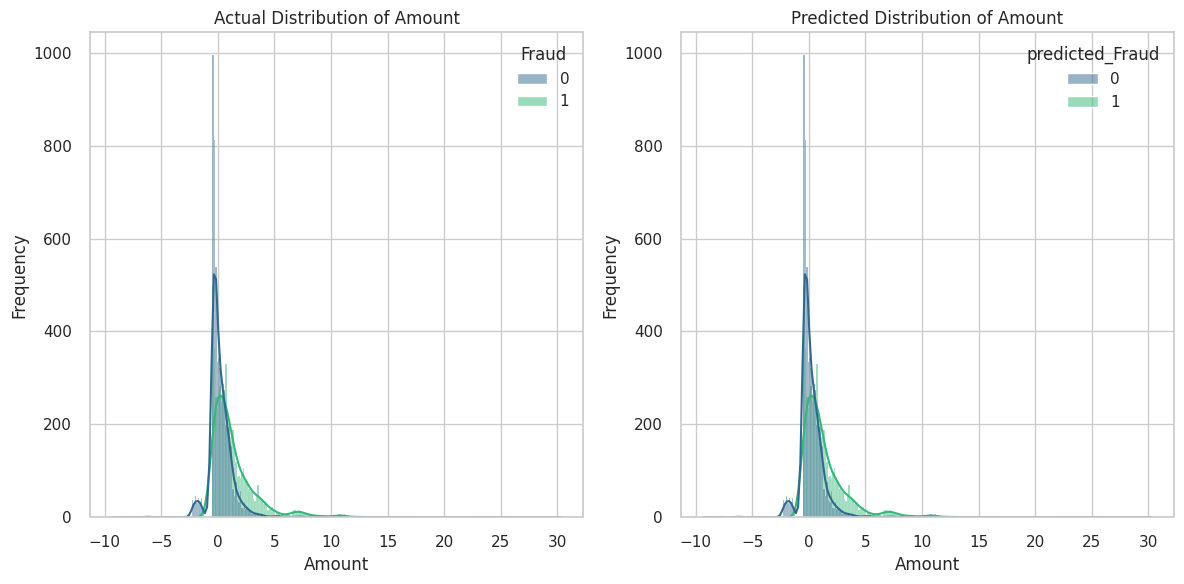

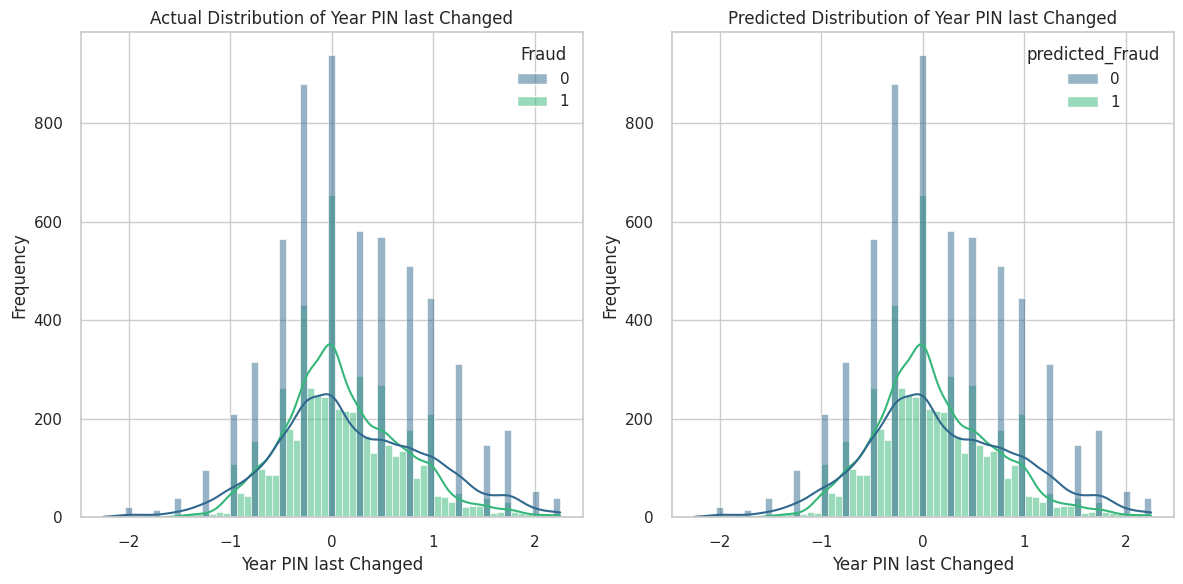

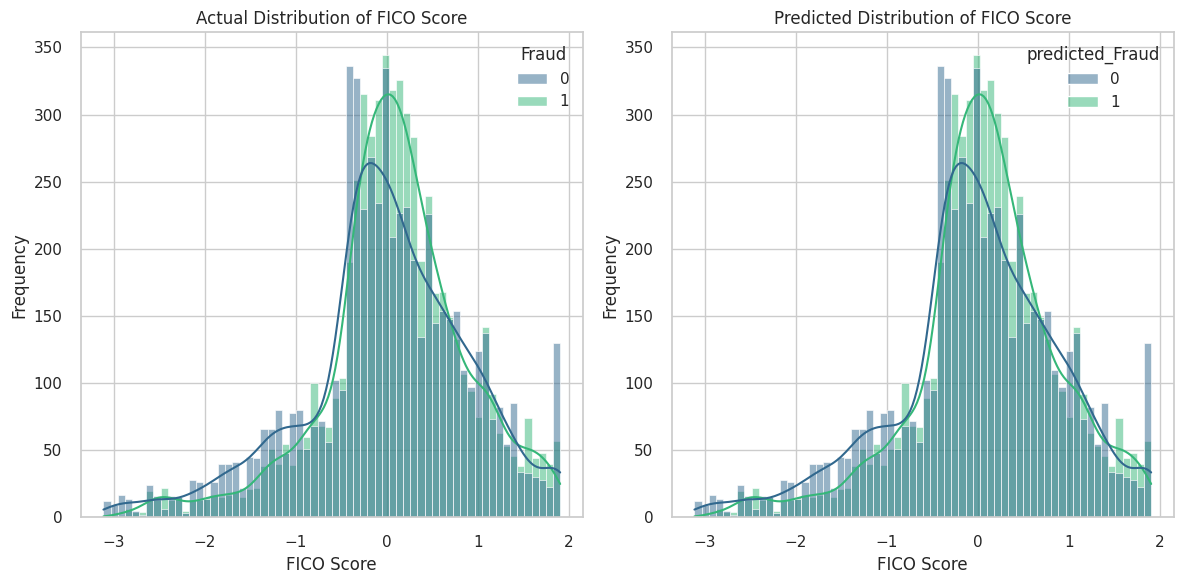

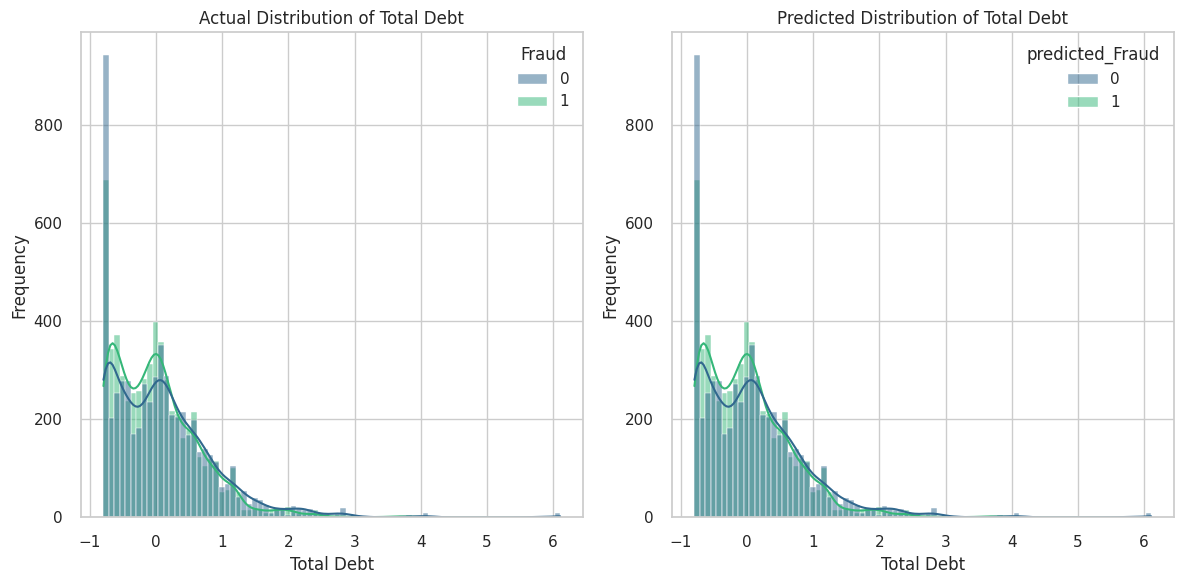

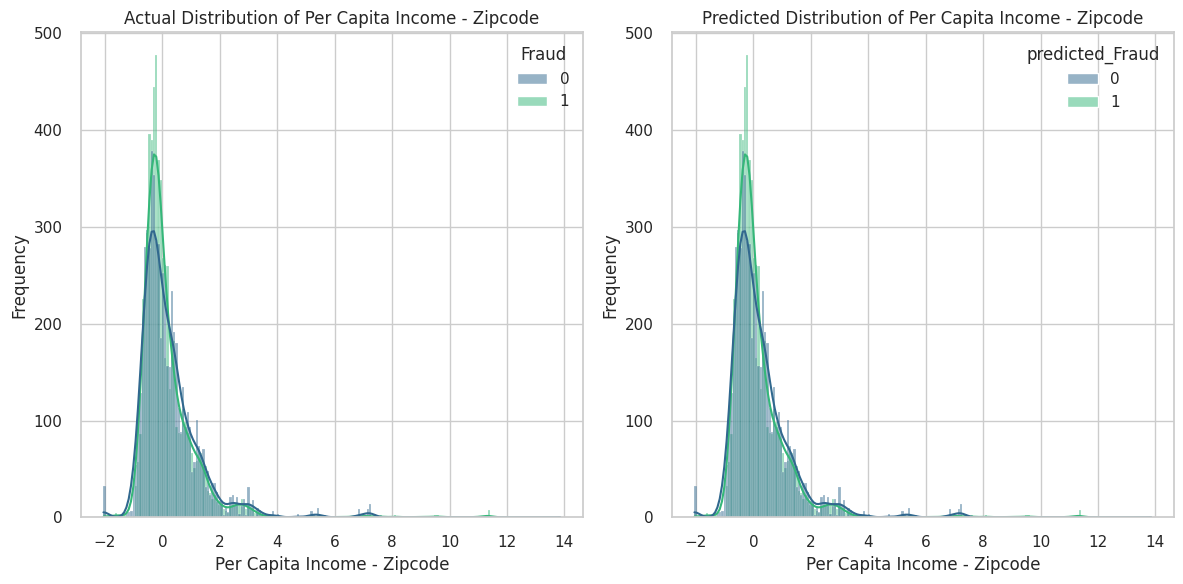

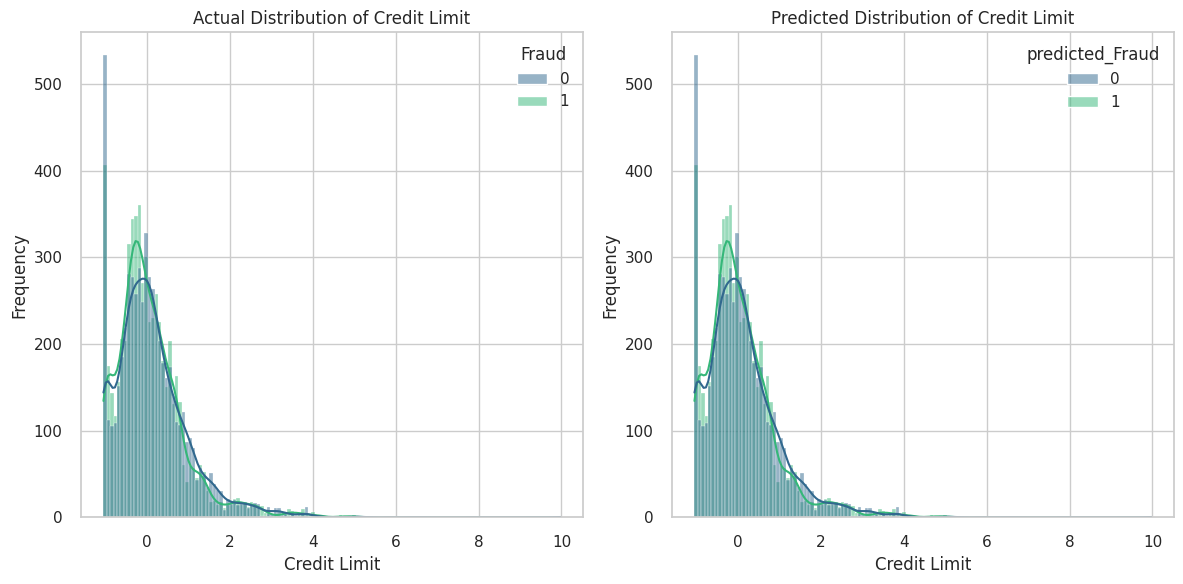

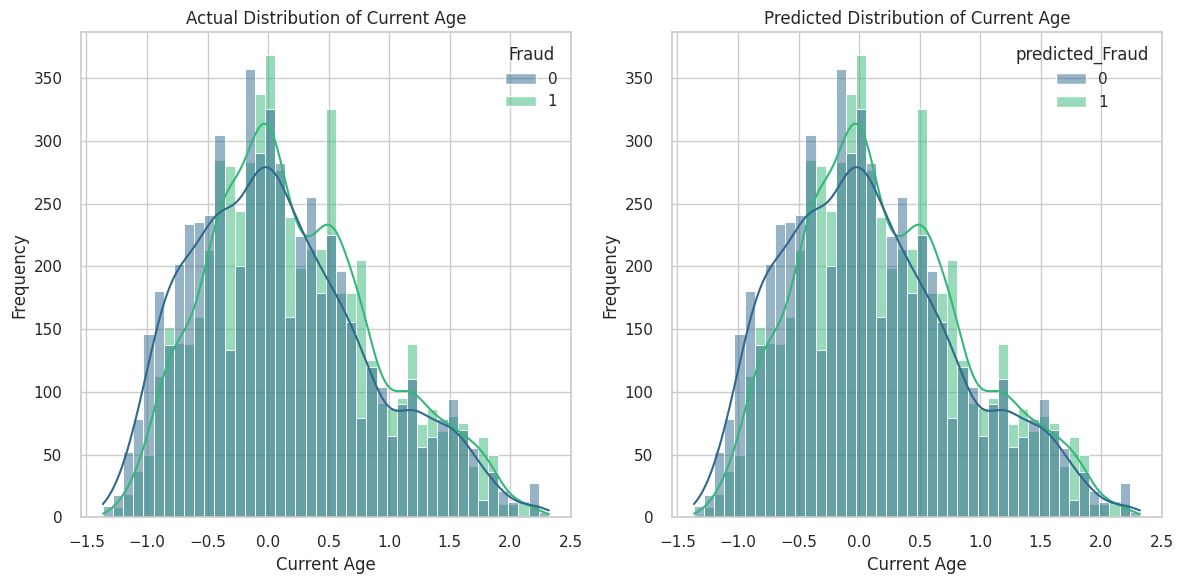

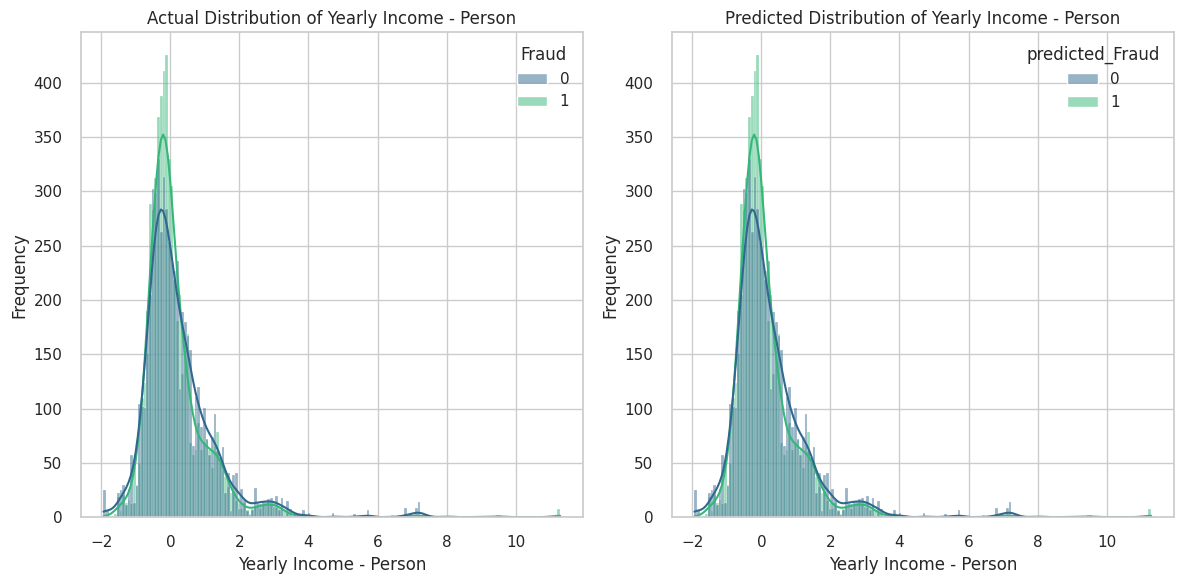

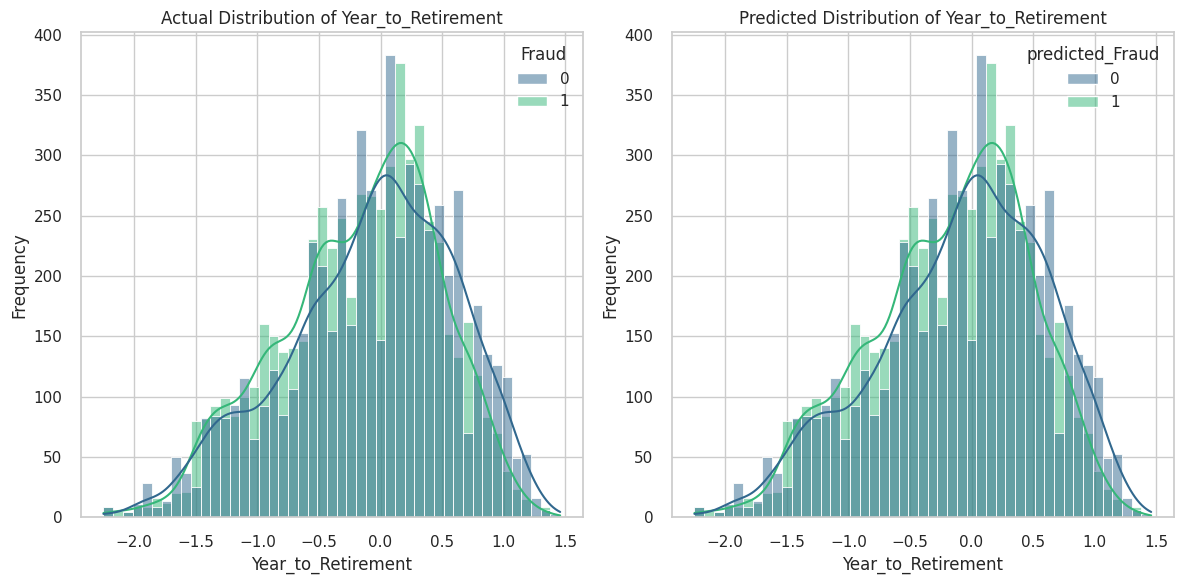

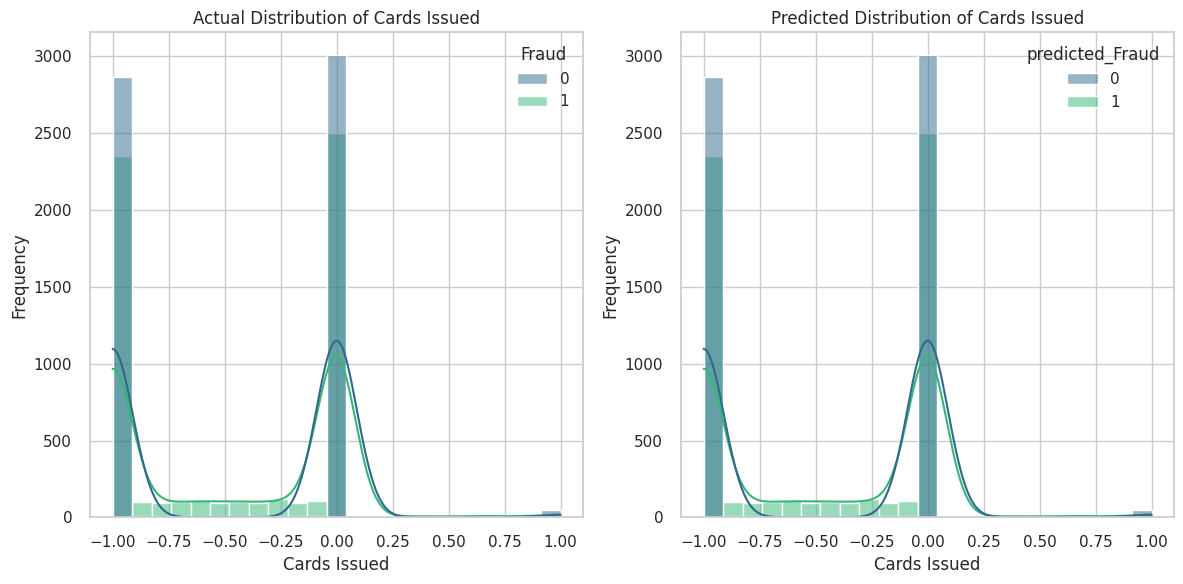

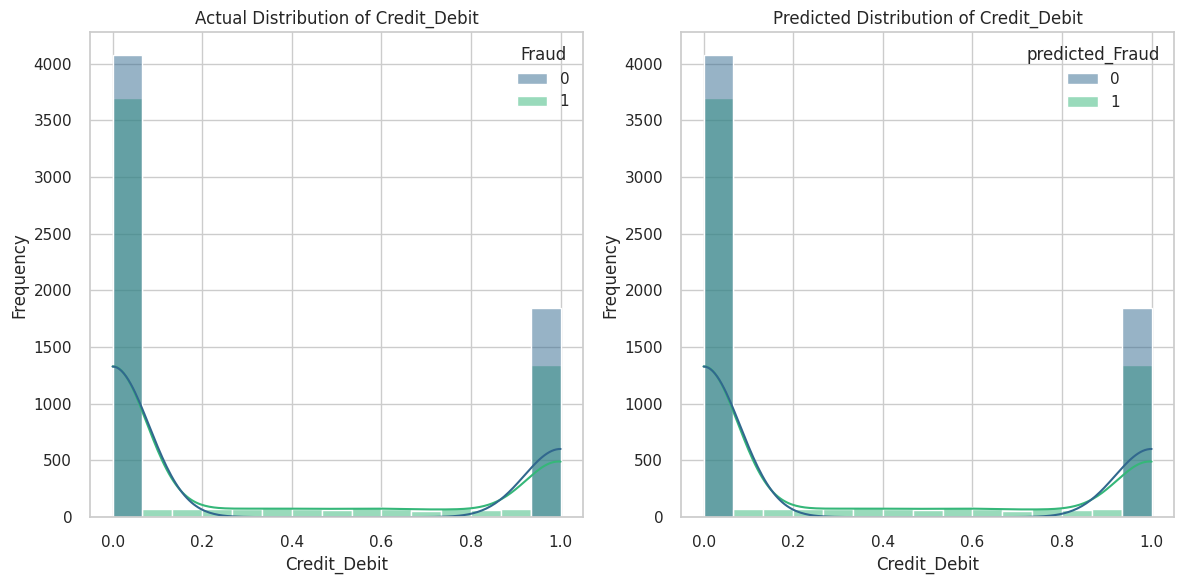

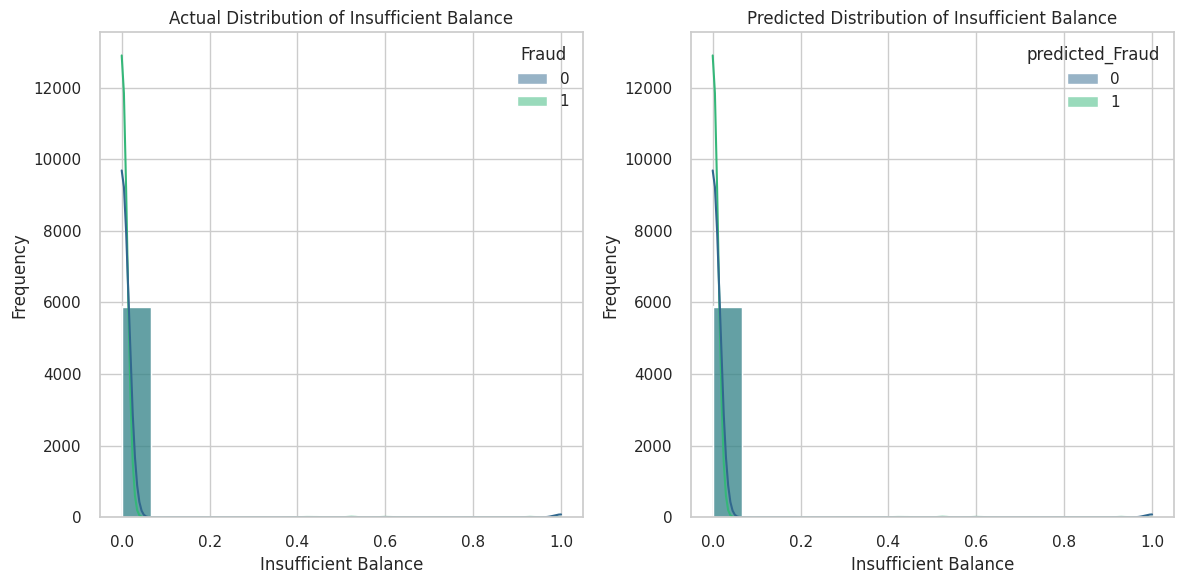

In [ ]:
for feature in important_features:
    plt.figure(figsize=(12, 6))

    # Plotting actual distribution
    plt.subplot(1, 2, 1)
    sns.histplot(df_sampled_05, x=feature, hue='Fraud', palette='viridis', kde=True)
    plt.title(f'Actual Distribution of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Frequency')


    # Plotting predicted distribution
    plt.subplot(1, 2, 2)
    sns.histplot(df_sampled_05, x=feature, hue='predicted_Fraud', palette='viridis', kde=True)
    plt.title(f'Predicted Distribution of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Frequency')


    plt.tight_layout()
    plt.show()

## Extra works - Dimensional Reduction(TSNE)

In [97]:
from sklearn.manifold import TSNE

In [103]:
# Selecting relevant features for t-SNE, excluding 'User' and 'Card' if they are not numerical
features = df_user_gb.columns.difference(['User', 'Card'])

# Applying t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)  # You can adjust perplexity and n_iter
tsne_results = tsne.fit_transform(df_user_card_gb[features])

In [101]:
tsne_results.shape

(4327, 2)

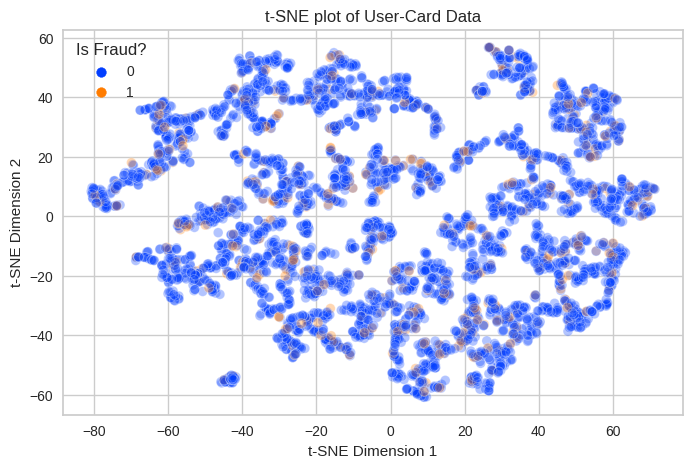

In [105]:
# Adding the t-SNE results to the dataframe
df_user_card_gb['tsne-2d-one'] = tsne_results[:,0]
df_user_card_gb['tsne-2d-two'] = tsne_results[:,1]

# Selecting a contrasting color palette
palette = sns.color_palette("bright", 2)  # 'bright' palette with 2 colors for binary data

# Plotting
plt.figure(figsize=(8,5))
sns.scatterplot(
    x='tsne-2d-one', y='tsne-2d-two',
    hue = 'Is Fraud?',
    palette=palette,
    data=df_user_card_gb,
    legend="full",
    alpha=0.3
)

plt.title('t-SNE plot of User-Card Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

The scatterness of fradulent transaction are basically overlapping with the normal transactions, which is also kind of predctable since in our original space of features, there's barely correlation we can derive from the dataset. But let's try further compress the feature information using AutoEncoder!

In [115]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()

X = robust_scaler.fit_transform(df_user_card_gb)
X_norm, X_fraud = X[df_user_card_gb['Is Fraud?']==0], X[df_user_card_gb['Is Fraud?']==1]

In [118]:
autoencoder = Sequential()

In [119]:
autoencoder.add(Dense(df_user_card_gb.shape[1], activation='tanh'))
autoencoder.add(Dense(100, activation='tanh'))
autoencoder.add(Dense(50, activation='relu'))
autoencoder.add(Dense(50, activation='tanh'))
autoencoder.add(Dense(100, activation='tanh'))
autoencoder.add(Dense(df_user_card_gb.shape[1], activation='relu'))

In [120]:
autoencoder.compile(optimizer='adam', loss='mse')

In [122]:
history = autoencoder.fit(X_norm,
                X_norm,
                batch_size = 64,
                epochs = 25,
                shuffle=True,
                validation_split=0.15)

Epoch 1/25
53/53 [==============================] - 0s 8ms/step - loss: 0.3231 - val_loss: 0.3867
Epoch 2/25
53/53 [==============================] - 0s 6ms/step - loss: 0.3216 - val_loss: 0.3848
Epoch 3/25
53/53 [==============================] - 0s 6ms/step - loss: 0.3201 - val_loss: 0.3850
Epoch 4/25
53/53 [==============================] - 0s 5ms/step - loss: 0.3200 - val_loss: 0.3854
Epoch 5/25
53/53 [==============================] - 0s 6ms/step - loss: 0.3185 - val_loss: 0.4026
Epoch 6/25
53/53 [==============================] - 0s 6ms/step - loss: 0.3300 - val_loss: 0.3910
Epoch 7/25
53/53 [==============================] - 0s 9ms/step - loss: 0.3195 - val_loss: 0.3844
Epoch 8/25
53/53 [==============================] - 0s 7ms/step - loss: 0.3226 - val_loss: 0.3861
Epoch 9/25
53/53 [==============================] - 1s 11ms/step - loss: 0.3166 - val_loss: 0.3833
Epoch 10/25
53/53 [==============================] - 0s 7ms/step - loss: 0.3119 - val_loss: 0.3781
Epoch 11/25
53/53 

In [125]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

<Axes: >

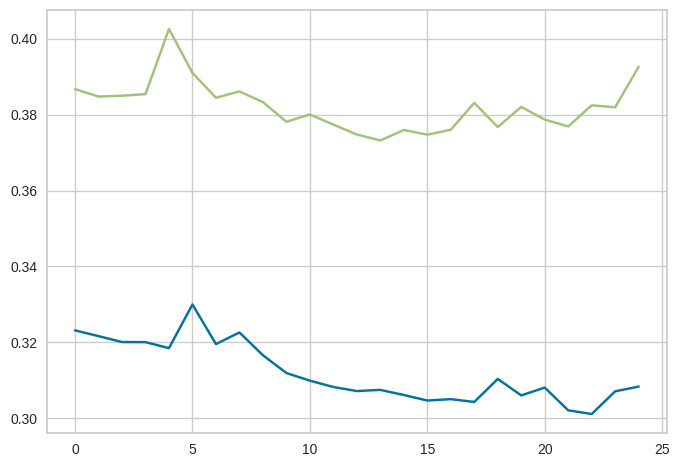

In [128]:
sns.lineplot(history.history['loss'])
sns.lineplot(history.history['val_loss'])

In [129]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

norm_hid_rep = hidden_representation.predict(X_norm)
fraud_hid_rep = hidden_representation.predict(X_fraud)

rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

13/13 [==============================] - 0s 7ms/step


In [135]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=2000)
tsne_results = tsne.fit_transform(rep_x)

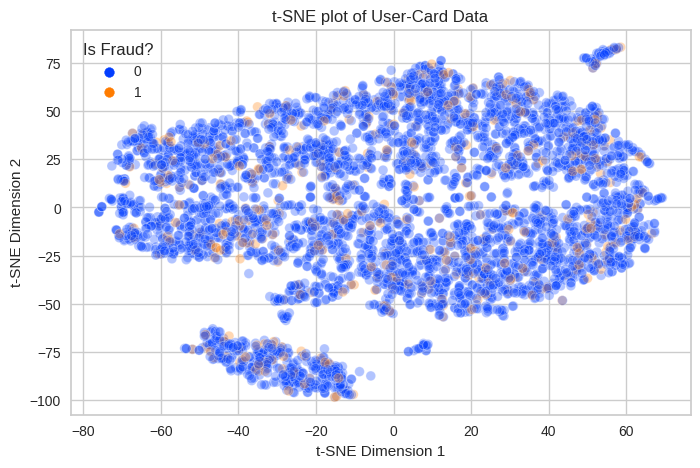

In [136]:
# Adding the t-SNE results to the dataframe
df_user_card_gb['encoded-tsne-2d-one'] = tsne_results[:,0]
df_user_card_gb['encoded-tsne-2d-two'] = tsne_results[:,1]

# Selecting a contrasting color palette
palette = sns.color_palette("bright", 2)  # 'bright' palette with 2 colors for binary data

# Plotting
plt.figure(figsize=(8,5))
sns.scatterplot(
    x='encoded-tsne-2d-one', y='encoded-tsne-2d-two',
    hue = 'Is Fraud?',
    palette=palette,
    data=df_user_card_gb,
    legend="full",
    alpha=0.3
)

plt.title('t-SNE plot of User-Card Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [ ]:
tsne_df = pd.DataFrame({'tsne-2d-one': tsne_results[:,0], 'tsne-2d-two': tsne_results[:,1], 'label': rep_y})

plt.figure(figsize=(16,10))
sns.scatterplot(
    x='tsne-2d-one', y='tsne-2d-two',
    hue='label',
    palette=sns.color_palette('hsv', 2),
    data=tsne_df,
    legend="full",
    alpha=0.3
)
plt.title('t-SNE plot of Autoencoder Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()